In [1]:
import numpy as np
import pandas as pd
import pandasql
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
import matplotlib.patches as mpatches #personalizar legenda
import seaborn as sns
from ydata_profiling import ProfileReport
from datetime import datetime
pd.options.display.float_format = '{:,.2f}'.format
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "C:/Users/danil/Desktop/Case Mercado Livre/Files/"
file_1 = "ofertas_relampago.csv"
data_1 = pd.read_csv(path+file_1)
data_1.head(5)

OFFER_START_DATE           OFFER_START_DTTM          OFFER_FINISH_DTTM  \
0       2021-06-22  2021-06-22 16:00:00+00:00  2021-06-22 23:02:43+00:00   
1       2021-06-22  2021-06-22 13:00:00+00:00  2021-06-22 19:00:02+00:00   
2       2021-06-22  2021-06-22 07:00:00+00:00  2021-06-22 13:00:01+00:00   
3       2021-06-22  2021-06-22 19:00:00+00:00  2021-06-23 01:36:12+00:00   
4       2021-06-22  2021-06-22 13:00:00+00:00  2021-06-22 15:48:12+00:00   

       OFFER_TYPE  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  \
0  lightning_deal               4                         -2         4.72   
1  lightning_deal               5                          5          NaN   
2  lightning_deal              15                         12        10.73   
3  lightning_deal              15                         13         7.03   
4  lightning_deal              15                          0        39.65   

   SOLD_QUANTITY ORIGIN SHIPPING_PAYMENT_TYPE DOM_DOMAIN_AGG1 VERTICAL  \
0           6.00      A                  none       PETS FOOD      CPG   
1            NaN    NaN         free_shipping    PET PRODUCTS   OTHERS   
2           3.00    NaN                  none       COMPUTERS       CE   
3           2.00    NaN                  none       COMPUTERS       CE   
4          15.00    NaN                  none       COMPUTERS       CE   

                     DOMAIN_ID  
0               MLM-BIRD_FOODS  
1  MLM-ANIMAL_AND_PET_PRODUCTS  
2                 MLM-SPEAKERS  
3               MLM-HEADPHONES  
4               MLM-HEADPHONES

# 1. Variáveis calculadas

Após identificação das variáveis disponíveis, foram geradas as variáveis:
- OFFER_HOURS: tempo da oferta relâmpago 
- unit_price: valor unitário do item vendido gerado a partir da divisão de SOLD_AMOUNT por SOLD_QUANTITY

In [3]:
df = data_1.copy()
df["OFFER_START_DATE"] = pd.to_datetime(df["OFFER_START_DATE"]) #Transformando variável em datetime
df["OFFER_START_DTTM"] = pd.to_datetime(df["OFFER_START_DTTM"]) #Transformando variável em datetime
df["OFFER_FINISH_DTTM"] = pd.to_datetime(df["OFFER_FINISH_DTTM"]) #Transformando variável em datetime
df["OFFER_HOURS"] = (df["OFFER_FINISH_DTTM"] - df["OFFER_START_DTTM"]).apply(lambda x: x.total_seconds() / 3600)
df["MONTH"] = df["OFFER_START_DATE"].dt.month #Adicionando variável mês para análises de negócio (usar data final da oferta?)

df = df[['OFFER_START_DATE','OFFER_START_DTTM'
         ,'OFFER_FINISH_DTTM','OFFER_HOURS'
         ,'MONTH','OFFER_TYPE'
         ,'INVOLVED_STOCK','REMAINING_STOCK_AFTER_END'
         ,'SOLD_AMOUNT','SOLD_QUANTITY'
         ,'ORIGIN','SHIPPING_PAYMENT_TYPE'
         ,'DOM_DOMAIN_AGG1','VERTICAL'
         ,'DOMAIN_ID']]
#Criação de preço unitário
df["unit_price"] = df["SOLD_AMOUNT"]/df["SOLD_QUANTITY"]
df.sort_values(by="OFFER_START_DTTM", inplace = True)

# 2. Validações

Nesta seção foi realizado a validação dos dados, como por exemplo, identificação de observações duplicadas, dados faltantes e consistência do valor apresentado.

O reporte abaixo foi utilizado para avaliação inicial.

In [4]:
profile = ProfileReport(df, title = "EDA report", progress_bar = False)
profile.to_file('profile_report_Ex1.html') 
profile.to_notebook_iframe()

## Destaques/Observações
- O banco de dados disponibilizado apresenta promoções de um período de 2 meses (junho/2021 à julho/2021);
- A variável OFFER_HOURS possui observações iguais a zero, ou seja, há ofertas que não estiveram disponíveis ao público;
- A variável OFFER_TYPE apresenta valor constante ('lightning_deal') e não será considerada para as análises;
- INVOLVED_STOCK mínimo é 1, poderia ser um risco reputacional? Como que a experiência do usuário pode ser afetada?
- REMAINING_STOCK_AFTER_END possui valores negativos: vendeu a mais ou erro de registro?
- As variáveis SOLD_AMOUNT, SOLD_QUANTITY e ORIGIN apresentaram 49.6% valores faltantes.


## 2.1 Observações idênticas (duplicadas)

O dataset apresentou 782 linhas duplicadas (1.6%) e foram removidas.

In [5]:
#Remoção das linhas duplicadas
df.drop_duplicates(inplace = True, ignore_index = True)
df.shape

(47820, 16)

## 2.2 Observações similares

### 2.2.1 Observações repetidas exceto em OFFER_FINISH_DTTM

Apesar da remoção de linhas duplicadas, observa-se que existem linhas muitos similares, nas quais apenas o valor de OFFER_FINISH_DTTM difere em poucos segundos entre uma linha e outra.

Para avaliar essa questão, considerou-se que ofertas possivelmente repetidas são aquelas que possuem os mesmos valores para DOMAIN_ID, OFFER_START_DTTM, INVOLVED_STOCK, REMAINING_STOCK_AFTER_END, SOLD_AMOUNT, SOLD_QUANTITY e SHIPPING_PAYMENT_TYPE. Além disso, a difereça entre o valor máximo e mínimo de OFFER_FINISH_DTTM é menor ou igual a 10 segundos.

Isso implica em 2610 observações repetidas, sendo no total 1239 observações distintas. 

São necessárias mais informações de negócios para confirmar este tipo de repetição de linhas, como por exemplo, a incorporação ou confirmação de uma chave primária na base de dados. Portanto, nenhuma linha foi removida com base nos critérios discutidos nesta subseção.

In [6]:
#buscar dados repetidos com critério de timestamp
df_validacao = pandasql.sqldf("""
    SELECT 
        DOMAIN_ID, 
        OFFER_START_DTTM, 
        INVOLVED_STOCK,
        REMAINING_STOCK_AFTER_END, 
        SOLD_AMOUNT,
        SOLD_QUANTITY,
        SHIPPING_PAYMENT_TYPE,
        COUNT(*) AS QTY, 
        MAX(OFFER_FINISH_DTTM) AS MAX_OFFER_FINISH_DTTM, 
        MIN(OFFER_FINISH_DTTM) AS MIN_OFFER_FINISH_DTTM, 
        (JULIANDAY(MAX(OFFER_FINISH_DTTM)) - JULIANDAY(MIN(OFFER_FINISH_DTTM))) * 24 * 60 * 60 AS diff_seconds
    FROM df
    GROUP BY 1,2,3,4,5,6,7 
    HAVING 
        COUNT(*) > 1 
        AND (JULIANDAY(MAX(OFFER_FINISH_DTTM)) - JULIANDAY(MIN(OFFER_FINISH_DTTM))) * 24 * 60 * 60 <= 10
    ORDER BY 8 DESC

""")
df_validacao

DOMAIN_ID            OFFER_START_DTTM  \
0                MLM-BOOTS_AND_BOOTIES  2021-07-09 07:00:00.000000   
1                       MLM-COMFORTERS  2021-06-23 07:00:00.000000   
2                     MLM-TABLET_CASES  2021-07-13 07:00:00.000000   
3                   MLM-ACTION_FIGURES  2021-07-08 11:00:00.000000   
4                   MLM-ACTION_FIGURES  2021-07-09 17:00:00.000000   
...                                ...                         ...   
1234                  MLM-WRISTWATCHES  2021-07-30 13:00:00.000000   
1235                  MLM-WRISTWATCHES  2021-07-31 19:00:00.000000   
1236  MLM-WRISTWATCH_SCREEN_PROTECTORS  2021-06-28 07:00:00.000000   
1237  MLM-WRISTWATCH_SCREEN_PROTECTORS  2021-07-05 07:00:00.000000   
1238  MLM-WRISTWATCH_SCREEN_PROTECTORS  2021-07-09 07:00:00.000000   

      INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  SOLD_QUANTITY  \
0                  5                          5          NaN            NaN   
1                  5                          5          NaN            NaN   
2                  5                          5          NaN            NaN   
3                 30                         30          NaN            NaN   
4                  8                          8          NaN            NaN   
...              ...                        ...          ...            ...   
1234               5                          5          NaN            NaN   
1235               5                          5          NaN            NaN   
1236              15                         15          NaN            NaN   
1237              15                         15          NaN            NaN   
1238              15                         15          NaN            NaN   

     SHIPPING_PAYMENT_TYPE  QTY       MAX_OFFER_FINISH_DTTM  \
0            free_shipping    5  2021-07-09 13:00:06.000000   
1            free_shipping    5  2021-06-23 13:00:04.000000   
2            free_shipping    5  2021-07-13 13:00:09.000000   
3            free_shipping    4  2021-07-08 19:00:04.000000   
4            free_shipping    4  2021-07-10 01:00:06.000000   
...                    ...  ...                         ...   
1234         free_shipping    2  2021-07-30 19:00:04.000000   
1235         free_shipping    2  2021-08-01 01:00:05.000000   
1236                  none    2  2021-06-28 13:00:05.000000   
1237                  none    2  2021-07-05 13:00:03.000000   
1238                  none    2  2021-07-09 13:00:06.000000   

           MIN_OFFER_FINISH_DTTM  diff_seconds  
0     2021-07-09 13:00:00.000000          6.00  
1     2021-06-23 13:00:00.000000          4.00  
2     2021-07-13 13:00:00.000000          9.00  
3     2021-07-08 19:00:01.000000          3.00  
4     2021-07-10 01:00:00.000000          6.00  
...                          ...           ...  
1234  2021-07-30 19:00:00.000000          4.00  
1235  2021-08-01 01:00:00.000000          5.00  
1236  2021-06-28 13:00:02.000000          3.00  
1237  2021-07-05 13:00:00.000000          3.00  
1238  2021-07-09 13:00:01.000000          5.00  

[1239 rows x 11 columns]

In [7]:
#total de linhas impactas
df_validacao["QTY"].sum()

2610

In [8]:
#Verificar se o mesmo ocorre em OFFER_START_DTTM
df_validacao = pandasql.sqldf("""
    SELECT 
        DOMAIN_ID, 
        OFFER_FINISH_DTTM, 
        INVOLVED_STOCK,
        REMAINING_STOCK_AFTER_END, 
        SOLD_AMOUNT,
        SOLD_QUANTITY,
        SHIPPING_PAYMENT_TYPE,
        COUNT(*) AS QTY, 
        MAX(OFFER_START_DTTM) AS MAX_OFFER_START_DTTMM, 
        MIN(OFFER_START_DTTM) AS MIN_OFFER_START_DTTM, 
        (JULIANDAY(MAX(OFFER_START_DTTM)) - JULIANDAY(MIN(OFFER_START_DTTM))) * 24 * 60 * 60 AS diff_seconds
    FROM df
    GROUP BY 1,2,3,4,5,6,7 
    HAVING 
        COUNT(*) > 1  
        AND (JULIANDAY(MAX(OFFER_START_DTTM)) - JULIANDAY(MIN(OFFER_START_DTTM))) * 24 * 60 * 60 <= 10
    ORDER BY 8 DESC

""")
df_validacao

Empty DataFrame
Columns: [DOMAIN_ID, OFFER_FINISH_DTTM, INVOLVED_STOCK, REMAINING_STOCK_AFTER_END, SOLD_AMOUNT, SOLD_QUANTITY, SHIPPING_PAYMENT_TYPE, QTY, MAX_OFFER_START_DTTMM, MIN_OFFER_START_DTTM, diff_seconds]
Index: []

### 2.2.2 Observações repetidas exceto em SOLD_AMOUNT e SOLD_QUANTITY

Devido à falta de uma chave primária, pode-se suspeitar de ofertas repetidas aquelas que possuem o mesmo valor para DOMAIN_ID, OFFER_START_DTTM, INVOLVED_STOCK, REMAINING_STOCK_AFTER_END, SOLD_AMOUNT, SOLD_QUANTITY e SHIPPING_PAYMENT_TYPE. A diferença não capturada pela remoção de duplicatas pode estar nas variáveis SOLD_AMOUNT e SOLD_QUANTITY. Como as informações de vendas podem estar registradas em outras tabelas, um erro comum ocorre no cruzamento de dados não tratados, resultando repetições na tabela final.  

No total, há 779 ofertas nesta condição, sendo apenas 386 distintas ao desconsiderar SOLD_AMOUNT e SOLD_QUANTITY. Assim como na subseção anterior, sugere-se a validação com o contexto de negócios para confirmar este tipo de repetição.

In [9]:
#Verificar repetições
df_validacao = pandasql.sqldf("""
    SELECT 
        DOMAIN_ID, 
        OFFER_FINISH_DTTM,
        OFFER_START_DTTM,
        INVOLVED_STOCK,
        REMAINING_STOCK_AFTER_END, 
        SHIPPING_PAYMENT_TYPE,
        COUNT(*) AS QTY, 
        MAX(IFNULL(SOLD_AMOUNT,-99)) AS MAX_SOLD_AMOUNT, 
        MIN(IFNULL(SOLD_AMOUNT,-99)) AS MIN_SOLD_AMOUNT, 
        MAX(IFNULL(SOLD_QUANTITY,-99)) AS MAX_SOLD_QUANTITY, 
        MIN(IFNULL(SOLD_QUANTITY,-99)) AS MIN_SOLD_QUANTITY
    FROM df
    GROUP BY 1,2,3,4,5,6 
    HAVING 
        COUNT(*) > 1 
    ORDER BY 7 DESC

""")
df_validacao

DOMAIN_ID           OFFER_FINISH_DTTM  \
0             MLM-SPEAKERS  2021-07-23 10:24:24.000000   
1    MLM-BOOTS_AND_BOOTIES  2021-07-10 19:00:01.000000   
2        MLM-COMPUTER_MICE  2021-06-03 16:50:23.000000   
3        MLM-COMPUTER_MICE  2021-07-24 01:00:02.000000   
4         MLM-SMARTWATCHES  2021-07-27 00:00:00.000000   
..                     ...                         ...   
381   MLM-WELDING_MACHINES  2021-07-19 22:00:00.000000   
382   MLM-WELDING_MACHINES  2021-07-22 22:00:00.000000   
383   MLM-WELDING_MACHINES  2021-07-30 21:43:53.000000   
384       MLM-WINE_CELLARS  2021-07-28 22:00:00.000000   
385       MLM-WRISTWATCHES  2021-07-13 13:00:04.000000   

               OFFER_START_DTTM  INVOLVED_STOCK  REMAINING_STOCK_AFTER_END  \
0    2021-07-23 07:00:00.000000              15                         -2   
1    2021-07-10 13:00:00.000000               5                          4   
2    2021-06-03 13:00:00.000000              15                          0   
3    2021-07-23 19:00:00.000000              15                          8   
4    2021-07-26 22:00:00.000000             100                         99   
..                          ...             ...                        ...   
381  2021-07-19 14:00:00.000000              12                          4   
382  2021-07-22 14:00:00.000000              14                         13   
383  2021-07-30 19:00:00.000000               5                          0   
384  2021-07-28 14:00:00.000000              50                         47   
385  2021-07-13 07:00:00.000000               5                          5   

    SHIPPING_PAYMENT_TYPE  QTY  MAX_SOLD_AMOUNT  MIN_SOLD_AMOUNT  \
0                    none    4            13.59           -99.00   
1           free_shipping    3            19.46            11.25   
2                    none    3             6.41           -99.00   
3                    none    3            16.88           -99.00   
4           free_shipping    3            73.15           -99.00   
..                    ...  ...              ...              ...   
381         free_shipping    2           120.25            72.15   
382         free_shipping    2            23.71           -99.00   
383         free_shipping    2           117.16           -99.00   
384         free_shipping    2           111.22            55.61   
385         free_shipping    2            39.89           -99.00   

     MAX_SOLD_QUANTITY  MIN_SOLD_QUANTITY  
0                11.00             -99.00  
1                 1.00               1.00  
2                12.00             -99.00  
3                 4.00             -99.00  
4                 1.00             -99.00  
..                 ...                ...  
381               5.00               3.00  
382               1.00             -99.00  
383               4.00             -99.00  
384               2.00               1.00  
385               1.00             -99.00  

[386 rows x 11 columns]

In [10]:
df_validacao["QTY"].sum()

779

## 2.3 Validação de OFFER_HOURS

Abaixo estão apresentadas as 1.271 ofertas que não possuem tempo de disponibilidade. É necessário validar se há algum erro na base de dados ou, se essa condição for real, identificar os motivos que levaram essas ofertas a essa situação.

In [11]:
df.loc[(df["OFFER_HOURS"] == 0)&(df["OFFER_START_DTTM"] == df["OFFER_FINISH_DTTM"])]

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
53          2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 07:00:00+00:00   
90          2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 07:00:00+00:00   
121         2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 07:00:00+00:00   
160         2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 07:00:00+00:00   
179         2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 07:00:00+00:00   
...                ...                       ...                       ...   
47462       2021-07-31 2021-07-31 15:00:00+00:00 2021-07-31 15:00:00+00:00   
47516       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 19:00:00+00:00   
47542       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 19:00:00+00:00   
47757       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 19:00:00+00:00   
47776       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 19:00:00+00:00   

       OFFER_HOURS  MONTH      OFFER_TYPE  INVOLVED_STOCK  \
53            0.00      6  lightning_deal               5   
90            0.00      6  lightning_deal              11   
121           0.00      6  lightning_deal               8   
160           0.00      6  lightning_deal              15   
179           0.00      6  lightning_deal              15   
...            ...    ...             ...             ...   
47462         0.00      7  lightning_deal              24   
47516         0.00      7  lightning_deal              15   
47542         0.00      7  lightning_deal              15   
47757         0.00      7  lightning_deal              15   
47776         0.00      7  lightning_deal               5   

       REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  SOLD_QUANTITY ORIGIN  \
53                             5          NaN            NaN    NaN   
90                            11          NaN            NaN    NaN   
121                            8          NaN            NaN    NaN   
160                           15          NaN            NaN    NaN   
179                           15          NaN            NaN    NaN   
...                          ...          ...            ...    ...   
47462                         24          NaN            NaN      A   
47516                         15          NaN            NaN    NaN   
47542                         15          NaN            NaN    NaN   
47757                         15          NaN            NaN    NaN   
47776                          5          NaN            NaN    NaN   

      SHIPPING_PAYMENT_TYPE       DOM_DOMAIN_AGG1         VERTICAL  \
53            free_shipping             COMPUTERS               CE   
90            free_shipping    APPAREL ACCESORIES     APP & SPORTS   
121           free_shipping           ELECTRONICS               CE   
160           free_shipping  VEHICULAR MULTIMEDIA              ACC   
179                    none                SPORTS     APP & SPORTS   
...                     ...                   ...              ...   
47462         free_shipping              FOOTWEAR     APP & SPORTS   
47516                  none         PHARMACEUTICS  BEAUTY & HEALTH   
47542                  none             BATTERIES              CPG   
47757                  none         PERSONAL CARE  BEAUTY & HEALTH   
47776         free_shipping         PERSONAL CARE  BEAUTY & HEALTH   

                        DOMAIN_ID  unit_price  
53                   MLM-USB_HUBS         NaN  
90                   MLM-HANDBAGS         NaN  
121             MLM-HAIR_CLIPPERS         NaN  
160           MLM-VEHICLE_CAMERAS         NaN  
179              MLM-CAMPING_COTS         NaN  
...                           ...         ...  
47462  MLM-SANDALS_AND_FLIP_FLOPS         NaN  
47516          MLM-ESSENTIAL_OILS         NaN  
47542          MLM-CELL_BATTERIES         NaN  
47757              MLM-FACE_MASKS         NaN  
47776              MLM-FACE_MASKS         NaN  

[1271 rows x 16 columns]

In [12]:
df["NO_OFFER_TIME"] = np.where ((df["OFFER_START_DTTM"] == df["OFFER_FINISH_DTTM"]), 1, 0)

## 2.4 Validação INVOLVED_STOCK

Há 256 ofertas que envolvem um único produto no estoque.

In [13]:
df.loc[(df["INVOLVED_STOCK"] == 1)]

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
596         2021-06-01 2021-06-01 18:00:00+00:00 2021-06-02 02:00:00+00:00   
1892        2021-06-03 2021-06-03 17:00:00+00:00 2021-06-04 00:00:00+00:00   
2042        2021-06-03 2021-06-03 20:00:00+00:00 2021-06-03 20:00:06+00:00   
2211        2021-06-04 2021-06-04 13:00:00+00:00 2021-06-04 21:00:44+00:00   
2336        2021-06-04 2021-06-04 14:00:00+00:00 2021-06-04 14:05:26+00:00   
...                ...                       ...                       ...   
46963       2021-07-31 2021-07-31 11:00:00+00:00 2021-07-31 11:00:00+00:00   
47090       2021-07-31 2021-07-31 13:00:00+00:00 2021-07-31 13:00:05+00:00   
47337       2021-07-31 2021-07-31 13:00:00+00:00 2021-07-31 21:00:00+00:00   
47439       2021-07-31 2021-07-31 14:00:00+00:00 2021-07-31 20:23:58+00:00   
47460       2021-07-31 2021-07-31 15:00:00+00:00 2021-07-31 23:00:00+00:00   

       OFFER_HOURS  MONTH      OFFER_TYPE  INVOLVED_STOCK  \
596           8.00      6  lightning_deal               1   
1892          7.00      6  lightning_deal               1   
2042          0.00      6  lightning_deal               1   
2211          8.01      6  lightning_deal               1   
2336          0.09      6  lightning_deal               1   
...            ...    ...             ...             ...   
46963         0.00      7  lightning_deal               1   
47090         0.00      7  lightning_deal               1   
47337         8.00      7  lightning_deal               1   
47439         6.40      7  lightning_deal               1   
47460         8.00      7  lightning_deal               1   

       REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  SOLD_QUANTITY ORIGIN  \
596                            1          NaN            NaN      A   
1892                           1          NaN            NaN      A   
2042                           1          NaN            NaN      A   
2211                           1          NaN            NaN      A   
2336                           0         7.92           1.00      A   
...                          ...          ...            ...    ...   
46963                          1          NaN            NaN      A   
47090                          1          NaN            NaN      A   
47337                          1          NaN            NaN      A   
47439                          0          NaN            NaN      A   
47460                          1          NaN            NaN      A   

      SHIPPING_PAYMENT_TYPE     DOM_DOMAIN_AGG1         VERTICAL  \
596           free_shipping           COMPUTERS               CE   
1892          free_shipping                BABY            T & B   
2042          free_shipping           COMPUTERS               CE   
2211          free_shipping           COMPUTERS               CE   
2336          free_shipping       PHARMACEUTICS  BEAUTY & HEALTH   
...                     ...                 ...              ...   
46963         free_shipping  APPAREL ACCESORIES     APP & SPORTS   
47090         free_shipping  APPAREL ACCESORIES     APP & SPORTS   
47337         free_shipping         ELECTRONICS               CE   
47439         free_shipping         ELECTRONICS               CE   
47460         free_shipping           COMPUTERS               CE   

                         DOMAIN_ID  unit_price  NO_OFFER_TIME  
596                  MLM-NOTEBOOKS         NaN              0  
1892             MLM-BABY_SUPPLIES         NaN              0  
2042                 MLM-NOTEBOOKS         NaN              0  
2211                 MLM-NOTEBOOKS         NaN              0  
2336   MLM-BLOOD_PRESSURE_MONITORS        7.92              0  
...                            ...         ...            ...  
46963             MLM-WRISTWATCHES         NaN              1  
47090             MLM-WRISTWATCHES         NaN              0  
47337          MLM-VACUUM_CLEANERS         NaN              0  
47439       MLM-HAIR_STRAI

## 2.5 Validação REMAINING_STOCK_AFTER_END

Existem 1.263 ofertas com REMAINING_STOCK_AFTER_END com valores negativos, totalizando 3.805 unidades de produtos. Para não afetar as agregações, os valores negativos serão substituídos por zero.

In [14]:
df.loc[(df["REMAINING_STOCK_AFTER_END"] < 0)]

OFFER_START_DATE          OFFER_START_DTTM         OFFER_FINISH_DTTM  \
45          2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 12:25:41+00:00   
84          2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 10:15:51+00:00   
128         2021-06-01 2021-06-01 07:00:00+00:00 2021-06-01 12:35:11+00:00   
326         2021-06-01 2021-06-01 13:00:00+00:00 2021-06-01 14:56:08+00:00   
355         2021-06-01 2021-06-01 13:00:00+00:00 2021-06-01 13:30:45+00:00   
...                ...                       ...                       ...   
47636       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 21:50:27+00:00   
47637       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 21:20:41+00:00   
47644       2021-07-31 2021-07-31 19:00:00+00:00 2021-08-01 00:54:52+00:00   
47717       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 21:12:15+00:00   
47733       2021-07-31 2021-07-31 19:00:00+00:00 2021-07-31 23:52:51+00:00   

       OFFER_HOURS  MONTH      OFFER_TYPE  INVOLVED_STOCK  \
45            5.43      6  lightning_deal              15   
84            3.26      6  lightning_deal              15   
128           5.59      6  lightning_deal              15   
326           1.94      6  lightning_deal              15   
355           0.51      6  lightning_deal              15   
...            ...    ...             ...             ...   
47636         2.84      7  lightning_deal              15   
47637         2.34      7  lightning_deal               5   
47644         5.91      7  lightning_deal              15   
47717         2.20      7  lightning_deal              15   
47733         4.88      7  lightning_deal               5   

       REMAINING_STOCK_AFTER_END  SOLD_AMOUNT  SOLD_QUANTITY ORIGIN  \
45                            -1        32.00          16.00    NaN   
84                            -3        12.32          18.00    NaN   
128                           -1        41.39          16.00    NaN   
326                           -4        11.09          19.00    NaN   
355                          -10        15.97          25.00    NaN   
...                          ...          ...            ...    ...   
47636                         -1        48.71          16.00    NaN   
47637                         -1        15.31           6.00    NaN   
47644                         -6        15.98          21.00    NaN   
47717                         -2        33.35          17.00    NaN   
47733                         -1        18.63           6.00    NaN   

      SHIPPING_PAYMENT_TYPE         DOM_DOMAIN_AGG1         VERTICAL  \
45                     none           PHARMACEUTICS  BEAUTY & HEALTH   
84                     none                INDUSTRY  HOME & INDUSTRY   
128                    none  TOOLS AND CONSTRUCTION  HOME & INDUSTRY   
326                    none                   FOODS              CPG   
355                    none           PHARMACEUTICS  BEAUTY & HEALTH   
...                     ...                     ...              ...   
47636                  none              HOME&DECOR  HOME & INDUSTRY   
47637                  none              HOME&DECOR  HOME & INDUSTRY   
47644                  none  TOOLS AND CONSTRUCTION  HOME & INDUSTRY   
47717                  none               AUTOPARTS              ACC   
47733                  none                  SPORTS     APP & SPORTS   

                               DOMAIN_ID  unit_price  NO_OFFER_TIME  
45     MLM-SURGICAL_AND_INDUSTRIAL_MASKS        2.00              0  
84         MLM-SAFETY_FACE_SHIELD_VISORS        0.68              0  
128                      MLM-MULTIMETERS        2.59              0  
326                  MLM-INSTANT_NOODLES        0.58              0  
355    MLM-SURGICAL_AND_INDUSTRIAL_MASKS        0.64              0  
...                                  ...         ...            ...  
47636                    MLM-LIGHT_BULBS        3.04              0  
47637                     MLM-LED_STRIPS        2.55      

In [15]:
df.loc[(df["REMAINING_STOCK_AFTER_END"] < 0)]["REMAINING_STOCK_AFTER_END"].sum()

-3805

In [16]:
df["REMAINING_STOCK_AFTER_END_POSITIVE"] = np.where(df["REMAINING_STOCK_AFTER_END"] < 0, 0, df["REMAINING_STOCK_AFTER_END"] )

## 2.6 Validação SOLD_AMOUNT e SOLD_QUANTITY

A maior parte dos valores faltantes nas variáveis SOLD_QUANTITY/SOLD_AMOUNT são referentes a situações em que não ocorreram alterações entre o estoque inicial e final. Entretanto, existem alguns casos em que foram registradas diferenças de estoque, porém os valores de venda não foram registrados, sendo a vertical CE a mais afetadas por esse tipo de evento (9.5% de vendas não apontadas).

Sendo assim, os valores NAN da variável SOLD_QUANTITY serão preenchidos com a diferença entre o estoque inicial e o estoque final. Já para SOLD_AMOUNT, será utilizado o preço unitário do produto (mediana da categoria DOM_DOMAIN_AGG1, quando disponível), multiplicado pela quantidade de vendas. Para observações que apresentaram o SOLD_QUANTITY faltante, além de uma diferença entre os dados de estoque igual a 0, o SOLD_AMOUNT será assumido imediatamente como 0.

#### SOLD_QUANTITY

In [17]:
#gerar sold quantity calculado
df["SOLD_QUANTITY_CALCULATED"] = df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"]

In [18]:
df.loc[(df["SOLD_QUANTITY"].isna() == True)].shape

(23272, 19)

In [19]:
df.loc[(df["SOLD_QUANTITY"].fillna(0) != df["SOLD_QUANTITY_CALCULATED"])].shape

(3510, 19)

In [20]:
df["delta_sales"] = df["SOLD_QUANTITY"] - df["SOLD_QUANTITY_CALCULATED"]

df.groupby(["MONTH", "VERTICAL", "DOM_DOMAIN_AGG1"]).agg(SOLD_MEAN = ("delta_sales", lambda x: x.mean()),
                                    SOLD_STD = ("delta_sales", lambda x: x.std()),
                                    SOLD_MAX = ("delta_sales", lambda x: x.max()),
                                    SOLD_MIN = ("delta_sales", lambda x: x.min())).reset_index().sort_values(ascending = False, by = "SOLD_MAX").head(10)

MONTH         VERTICAL     DOM_DOMAIN_AGG1  SOLD_MEAN  SOLD_STD  SOLD_MAX  \
48      7  BEAUTY & HEALTH       PHARMACEUTICS      27.53     89.72    752.00   
13      6  BEAUTY & HEALTH       PHARMACEUTICS      19.76     61.84    607.00   
41      7     APP & SPORTS             APPAREL       0.47     10.19    319.00   
46      7  BEAUTY & HEALTH    BEAUTY EQUIPMENT       2.00     12.10    153.00   
26      6  HOME & INDUSTRY            INDUSTRY       0.64      6.98     84.00   
7       6     APP & SPORTS  APPAREL ACCESORIES       0.65      5.63     76.00   
51      7               CE              MOBILE      -0.47      5.16     53.00   
6       6     APP & SPORTS             APPAREL       0.08      1.10     28.00   
16      6               CE              MOBILE      -0.90      5.55     20.00   
67      7            T & B               PARTY       0.17      1.60     16.00   

    SOLD_MIN  
48    -25.00  
13    -47.00  
41    -10.00  
46    -25.00  
26     -6.00  
7      -6.00  
51    -67.00  
6      -3.00  
16    -53.00  
67     -3.00

A tabela acima apresenta os 20 segmentos com maiores desvios positivos entre os dados de estoque (inicial - final). Pelo padrão encontrado anteriormente de dados faltantes de registros de vendas, onde a grande maioria dos eventos ocorreu em observações que não apresentaram diferença entre o estoque inicial e final, é possível estimar que as informações são agrupadas aqui por meio de combinações de tabelas (LEFT JOIN). Para formular esta hipótese, assume-se que os produtos vendidos na modalidade "ofertas relâmpago" não se relacionam com outros produtos do site, dado que a oferta tem um prazo definido e uma quantidade limitada no estoque (conforme enunciado). Sendo assim, as hipóteses para os desvios acima são:

1. Os registros de vendas vs. registros de estoque podem ser atualizados em momentos diferentes, causando essas divergências. Por exemplo, algumas plataformas de gerenciamento de dados como Google Analytics costumam registrar todas as vendas realizadas no site de um E-Commerce. No meio dessas vendas, podem existir compras que não serão finalizadas por determinado motivo, como as geradas via boleto ou canceladas por algum motivo.

2. Podem existir inconsistências entre as tabelas agrupadas, possivelmente nas chaves primárias utilizadas. Um fator que contribui com essa hipótese é a presença de observações com diferença entre o estoque inicial e final, porém sem registros de vendas ou amount.

Ressalta-se que em um cenário real, deve-se entrar em contato com as áreas responsáveis pela tratativa e coleta desses dados, para entender o motivo da divergência. Será que essa divergência sempre ocorreu ou foi algo que começou a acontecer agora? Ocorreu alguma mudança no pipeline de dados? Além disso, deve ser feito um levantamento dos modelos e iniciativas que utilizam dessa base de dados e estimar os possíveis impactos do desvio.

In [21]:
#Verificando a quantidade de NaN por vertical geral
df.groupby(["VERTICAL"]).agg(Total_Sold = ('DOMAIN_ID', lambda x: x.count()),
                             Total_naQuantity = ('SOLD_QUANTITY', lambda x: x.isna().sum()),
                             pct_naQuantity = ('SOLD_QUANTITY', lambda x: round(x.isna().sum()/len(x)*100,2)),
                             total_naQuantityHZero = ('SOLD_QUANTITY', lambda x: x[df["SOLD_QUANTITY_CALCULATED"] > 0].isna().sum()),
                             pct_naQuantityHZero = ('SOLD_QUANTITY', lambda x: round(x[df["SOLD_QUANTITY_CALCULATED"] > 0].isna().sum()/x.isna().sum()*100,2)),
                             total_naQuantityLZero = ('SOLD_QUANTITY', lambda x: x[df["SOLD_QUANTITY_CALCULATED"] == 0].isna().sum()),
                             pct_naQuantityLZero = ('SOLD_QUANTITY', lambda x: round(x[df["SOLD_QUANTITY_CALCULATED"] == 0].isna().sum()/x.isna().sum()*100,2))
                             ).reset_index().sort_values(by = 'pct_naQuantityLZero')

VERTICAL  Total_Sold  Total_naQuantity  pct_naQuantity  \
3               CE        8373              3858           46.08   
4              CPG        2631              1427           54.24   
8            T & B        2534              1755           69.26   
6  HOME & INDUSTRY       10822              5447           50.33   
0              ACC        2553              1244           48.73   
5    ENTERTAINMENT         498               320           64.26   
2  BEAUTY & HEALTH        7068              2646           37.44   
1     APP & SPORTS       13065              6418           49.12   
7           OTHERS         276               157           56.88   

   total_naQuantityHZero  pct_naQuantityHZero  total_naQuantityLZero  \
3                    367                 9.51                   3491   
4                     28                 1.96                   1399   
8                     34                 1.94                   1721   
6                     76                 1.40                   5371   
0                      8                 0.64                   1236   
5                      2                 0.62                    318   
2                     16                 0.60                   2630   
1                      3                 0.05                   6415   
7                      0                 0.00                    157   

   pct_naQuantityLZero  
3                90.49  
4                98.04  
8                98.06  
6                98.60  
0                99.36  
5                99.38  
2                99.40  
1                99.95  
7               100.00

In [22]:
#Estimativa de vendas faltantes pelos valores de estoque
df["SOLD_QUANTITY"] = df["SOLD_QUANTITY"].fillna(df["INVOLVED_STOCK"] - df["REMAINING_STOCK_AFTER_END"])

#### SOLD_AMOUNT

In [23]:
#Verificando a quantidade de NaN por vertical geral
df.groupby(['VERTICAL']).agg(amount_total = ('DOMAIN_ID', lambda x: x.count()),
                             amount_na = ('SOLD_AMOUNT', lambda x: x.isna().sum()),
                             pct_amount_na = ('SOLD_AMOUNT', lambda x: round(x.isna().sum()/len(x)*100,2))
                                                                   ).reset_index()

VERTICAL  amount_total  amount_na  pct_amount_na
0              ACC          2553       1244          48.73
1     APP & SPORTS         13065       6418          49.12
2  BEAUTY & HEALTH          7068       2646          37.44
3               CE          8373       3858          46.08
4              CPG          2631       1427          54.24
5    ENTERTAINMENT           498        320          64.26
6  HOME & INDUSTRY         10822       5447          50.33
7           OTHERS           276        157          56.88
8            T & B          2534       1755          69.26

In [24]:
#Preenchimento de SOLD_AMOUNT para observações que não apresentaram variação no estoque
df.loc[(df["SOLD_AMOUNT"].isna()) & (df["SOLD_QUANTITY_CALCULATED"] == 0), "SOLD_AMOUNT"] = 0

In [25]:
#Estimando os preços unitarios faltantes pela mediana da categoria DOM_DOMAIN_AGG1
median_gg = df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1'])['unit_price'].transform(lambda x: x[df["unit_price"].notna()].median())
df['unit_price'] = df['unit_price'].fillna(median_gg)
df['unit_price'] = df['unit_price'].fillna(0)

#Estimando o SOLD_AMOUNT com base no preço unitário estimado
df["ESTIMATED_SOLD_AMOUNT"] = df["unit_price"] * df["SOLD_QUANTITY"]
#Preenchendo os valores do SOLD_AMOUNT original com 0, com o intuito de estimar a incerteza dos ajustes
df["SOLD_AMOUNT"] = df["SOLD_AMOUNT"].fillna(0)

#Verificando a quantidade de NaN por vertical geral

df_uncertainty = df.groupby(['VERTICAL', 'DOM_DOMAIN_AGG1']).agg(amount_1 = ('SOLD_AMOUNT', lambda x: x.sum()),
                                               amount_2 = ('ESTIMATED_SOLD_AMOUNT', lambda x: x.sum())).reset_index()

df_uncertainty["estimation_delta"] = round(df_uncertainty["amount_2"] - df_uncertainty["amount_1"], 2) 
df_uncertainty["estimation_uncertainty"] = round(df_uncertainty['estimation_delta']/df_uncertainty['amount_2']*100,2).fillna(0)
general_uncertainty = round((np.sum(df_uncertainty["amount_2"]) - np.sum(df_uncertainty["amount_1"]))/np.sum(df_uncertainty["amount_2"])*100,2)

print(f'Total uncertainty: {general_uncertainty} %')
display(df_uncertainty.sort_values(ascending = False, by = "estimation_uncertainty"))

Total uncertainty: 1.0 %


VERTICAL               DOM_DOMAIN_AGG1   amount_1   amount_2  \
24    ENTERTAINMENT           MUSICAL INSTRUMENTS     248.33     343.59   
33            T & B                          BABY   4,409.04   5,611.31   
5               ACC                WHEELS & TIRES   1,007.59   1,141.33   
21              CPG              PERSONAL HYGIENE   4,993.08   5,260.83   
22              CPG                     PETS FOOD   4,698.42   4,928.34   
14               CE                     COMPUTERS  83,085.60  86,266.69   
15               CE                   ELECTRONICS 119,307.41 123,762.72   
4               ACC          VEHICULAR MULTIMEDIA   4,144.59   4,255.73   
29  HOME & INDUSTRY        TOOLS AND CONSTRUCTION  23,878.76  24,475.31   
26  HOME & INDUSTRY                      INDUSTRY  25,874.22  26,313.18   
16               CE                        MOBILE 158,429.52 159,760.40   
2               ACC                     AUTOPARTS  14,905.65  14,996.63   
25  HOME & INDUSTRY                    HOME&DECOR  87,754.16  88,052.78   
28  HOME & INDUSTRY                    STATIONARY   7,115.78   7,135.53   
12  BEAUTY & HEALTH                 PERSONAL CARE  18,364.08  18,404.88   
18              CPG                      CLEANING   3,579.90   3,586.24   
35            T & B                TOYS AND GAMES   8,171.46   8,181.41   
11  BEAUTY & HEALTH              BEAUTY EQUIPMENT  88,830.25  88,928.26   
13  BEAUTY & HEALTH                 PHARMACEUTICS 440,073.69 440,150.43   
9      APP & SPORTS                        SPORTS  33,118.70  33,125.04   
6      APP & SPORTS                       APPAREL  36,534.20  36,539.19   
17              CPG                     BATTERIES     291.35     291.35   
7      APP & SPORTS            APPAREL ACCESORIES  36,556.99  36,556.99   
34            T & B                         PARTY   1,671.26   1,671.26   
3               ACC                     MOTOPARTS   5,774.64   5,774.64   
32           OTHERS                  PET PRODUCTS   1,678.69   1,678.69   
31           OTHERS                         OTHER     136.75     136.75   
30           OTHERS            ANTIQUES & HOBBIES     113.80     113.80   
8      APP & SPORTS                      FOOTWEAR  20,685.71  20,685.71   
27  HOME & INDUSTRY                      SECURITY  10,789.33  10,789.33   
1               ACC                          AGRO       0.00       0.00   
10     APP & SPORTS                    SUPLEMENTS   4,161.42   4,161.42   
23    ENTERTAINMENT  BOOKS, MULTIMEDIA & OTHER E!   1,740.24   1,740.24   
20              CPG                         FOODS   2,759.11   2,759.11   
19              CPG                        DRINKS     432.01     432.01   
0               ACC                     ACC TOOLS     987.51     987.51   

    estimation_delta  estimation_uncertainty  
24             95.26                   27.73  
33          1,202.27                   21.43  
5             133.74                   11.72  
21            267.75                    5.09  
22            229.92                    4.67  
14          3,181.09                    3.69  
15          4,455.31                    3.60  
4             111.14                    2.61  
29            596.55                    2.44  
26            438.96                    1.67  
16          1,330.88                    0.83  
2              90.98                    0.61  
25            298.62                    0.34  
28             19.75                    0.28  
12             40.80                    0.22  
18              6.34                    0.18  
35              9.94                    0.12  
11             98.01                    0.11  
13             76.74                    0.02  
9               6.34                    0.02  
6               4.99                    0.01  
17              0.00                    0.00  
7               0.00                    0.00  
34              0.00                    0.00  
3               0.00                    0.00  
32           

## 2.7 Preenchimento ORIGIN

Para variável ORIGIN, valores faltantes serão preenchidos com unknown.

In [26]:
#Preenchimento de valores NAN na variável ORIGIN
df["ORIGIN"] = df["ORIGIN"].fillna("unknown")

## 2.8 Validação DOM_DOMAIN_AGG1, VERTICAL, DOMAIN_ID

Nesta subseção é avaliado a relação de aninhamento entre as variáveis DOM_DOMAIN_AGG1, VERTICAL e DOMAIN_ID.

Conclui-se que para cada DOMAIN_ID, só há um distinto DOM_DOMAIN_AGG1, assim como DOM_DOMAIN_AGG1 em relação à VERTICAL. 

A relação de granularidade entre as 3 variáveis é: DOMAIN_ID > DOM_DOMAIN_AGG1 > VERTICAL

#### DOMAIN_ID

In [27]:
df_validacao = df.groupby('DOMAIN_ID').agg(
        DIST_DOM_DOMAIN_AGG1=('DOM_DOMAIN_AGG1', 'nunique'),
        DIST_VERTICAL=('VERTICAL', 'nunique'))
df_validacao.head()

DIST_DOM_DOMAIN_AGG1  DIST_VERTICAL
DOMAIN_ID                                                      
MLM-3D_PENS                                    1              1
MLM-3D_PRINTERS                                1              1
MLM-3D_PRINTER_FILAMENTS                       1              1
MLM-3D_PRINTER_NOZZLES                         1              1
MLM-ABDOMINAL_TONING_BELTS                     1              1

In [28]:
df_validacao.describe()

DIST_DOM_DOMAIN_AGG1  DIST_VERTICAL
count              1,266.00       1,266.00
mean                   1.00           1.00
std                    0.00           0.00
min                    1.00           1.00
25%                    1.00           1.00
50%                    1.00           1.00
75%                    1.00           1.00
max                    1.00           1.00

#### DOM_DOMAIN_AGG1

In [29]:
df_validacao = df.groupby('DOM_DOMAIN_AGG1').agg(
        DIST_VERTICAL=('VERTICAL', 'nunique'),
        DIST_DOMAIN_ID = ('DOMAIN_ID', 'nunique')
)
df_validacao.head()

DIST_VERTICAL  DIST_DOMAIN_ID
DOM_DOMAIN_AGG1                                  
ACC TOOLS                       1               2
AGRO                            1               1
ANTIQUES & HOBBIES              1               3
APPAREL                         1              29
APPAREL ACCESORIES              1              46

In [30]:
df_validacao.describe()

DIST_VERTICAL  DIST_DOMAIN_ID
count          36.00           36.00
mean            1.00           35.17
std             0.00           40.44
min             1.00            1.00
25%             1.00            7.50
50%             1.00           23.00
75%             1.00           47.75
max             1.00          190.00

#### VERTICAL	

In [31]:
df_validacao = df.groupby('VERTICAL').agg(
        DIST_DOM_DOMAIN_AGG1=('DOM_DOMAIN_AGG1', 'nunique'),
        DIST_DOMAIN_ID = ('DOMAIN_ID', 'nunique')
)
df_validacao.head()

DIST_DOM_DOMAIN_AGG1  DIST_DOMAIN_ID
VERTICAL                                             
ACC                                 6              84
APP & SPORTS                        5             191
BEAUTY & HEALTH                     3             146
CE                                  3             185
CPG                                 6              94

In [32]:
df_validacao.describe()

DIST_DOM_DOMAIN_AGG1  DIST_DOMAIN_ID
count                  9.00            9.00
mean                   4.00          140.67
std                    1.50          116.13
min                    2.00           17.00
25%                    3.00           84.00
50%                    3.00          103.00
75%                    5.00          185.00
max                    6.00          407.00

# 3. Análises ao longo do tempo

## 3.1 Volumetria geral

### Destaques/Observações
- Quantidade de novas ofertas apresenta tendência crescente ao longo do tempo, com uma queda pontual no dia 2021-06-30;
- Foi verificado a hipótese que a queda de novas ofertas no dia 2021-06-30 seja explicada pela existência de ofertas que estavam ativas e foram iniciadas no dia anterior. Tal hipótese foi descartada já que há também queda de ofertas ativas em 2021-06-30;
- O percentual de itens vendidos varia normalmente entre 10% e 25%. Caso o objetivo seja esgotar o estoque, recomenda-se aprofundar estudos na segmentação de público-alvo das ofertas relâmpago. 

In [33]:
df_plot = df.groupby(["OFFER_START_DATE"]).agg(
    TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()),
    
    TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
    TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
    TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
    TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
    TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum()),
    
    MEAN_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.mean()),
    MEAN_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.mean()),
    MEAN_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.mean()),
    MEAN_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.mean()),
    MEAN_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.mean())

)
df_plot = df_plot.reset_index()
df_plot["OFFER_START_DATE"] = df_plot["OFFER_START_DATE"].astype(str)
df_plot["PERCENTUAL_SOLD_QUANTITY"] = (df_plot["TOTAL_SOLD_QUANTITY"] / df_plot["TOTAL_INVOLVED_STOCK"])*100
df_plot

OFFER_START_DATE  TOTAL_OFFER_QTY  TOTAL_OFFER_HOURS  TOTAL_INVOLVED_STOCK  \
0        2021-06-01              875           4,465.14                 23529   
1        2021-06-02              665           3,406.95                 22178   
2        2021-06-03              504           2,750.54                 21995   
3        2021-06-04              457           2,556.39                 14208   
4        2021-06-05              428           2,511.33                 14151   
..              ...              ...                ...                   ...   
56       2021-07-27             1082           6,010.86                 50545   
57       2021-07-28             1196           6,793.03                 33785   
58       2021-07-29             1285           8,245.11                 31328   
59       2021-07-30             1290           7,301.39                 31126   
60       2021-07-31             1201           6,702.22                 28825   

    TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE  TOTAL_SOLD_QUANTITY  \
0                                      21249             2,933.00   
1                                      20217             2,428.00   
2                                      19875             3,018.00   
3                                      12573             1,807.00   
4                                      12445             1,999.00   
..                                       ...                  ...   
56                                     40430            10,219.00   
57                                     26925             6,952.00   
58                                     27301             4,203.00   
59                                     27254             3,897.00   
60                                     25490             3,400.00   

    TOTAL_ESTIMATED_SOLD_AMOUNT  MEAN_OFFER_HOURS  MEAN_INVOLVED_STOCK  \
0                     15,057.07              5.10                26.89   
1                     11,633.74              5.12                33.35   
2                     15,893.00              5.46                43.64   
3                      9,009.81              5.59                31.09   
4                     11,563.16              5.87                33.06   
..                          ...               ...                  ...   
56                    37,658.50              5.56                46.71   
57                    27,847.84              5.68                28.25   
58                    25,876.92              6.42                24.38   
59                    22,688.61              5.66                24.13   
60                    17,857.44              5.58                24.00   

    MEAN_REMAINING_STOCK_AFTER_END_POSITIVE  MEAN_SOLD_QUANTITY  \
0                                     24.28                3.35   
1                                     30.40                3.65   
2                                     39.43                5.99   
3                                     27.51                3.95   
4                                     29.08                4.67   
..                                      ...                 ...   
56                                    37.37                9.44   
57                                    22.51                5.81   
58                                    21.25                3.27   
59                                    21.13                3.02   
60                                    21.22                2.83   

    MEAN_ESTIMATED_SOLD_AMOUNT  PERCENTUAL_SOLD_QUANTITY  
0                        17.21                     12.47  
1                        17.49                     10.95  
2                        31.53                     13.72  
3                        19.72                     12.72  
4                        27.02                     14.13  
..                         ...                       ...  
56                       34.80                     20.22  
57                       23.28     

None

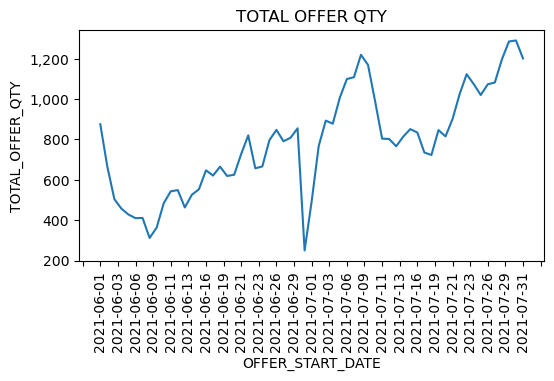

In [34]:
var = "TOTAL_OFFER_QTY"
fig, axes = plt.subplots(1,1, figsize = (6,3))
sns.lineplot(data = df_plot, x = "OFFER_START_DATE", y = var, ax = axes)
axes.tick_params(axis = 'x', labelrotation = 90)
plt.title(var.replace("_"," ")) 
axes.xaxis.set_major_locator(plt.MaxNLocator(30))
ylabels = ['{:,.0f}'.format(y) for y in axes.get_yticks()]
axes.set_yticklabels(ylabels)
display(fig.show())

In [35]:
df_plot.loc[df_plot["OFFER_START_DATE"]=="2021-06-30"]

OFFER_START_DATE  TOTAL_OFFER_QTY  TOTAL_OFFER_HOURS  TOTAL_INVOLVED_STOCK  \
29       2021-06-30              250           1,682.58                 24575   

    TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE  TOTAL_SOLD_QUANTITY  \
29                                     22343             3,778.00   

    TOTAL_ESTIMATED_SOLD_AMOUNT  MEAN_OFFER_HOURS  MEAN_INVOLVED_STOCK  \
29                    16,642.42              6.73                98.30   

    MEAN_REMAINING_STOCK_AFTER_END_POSITIVE  MEAN_SOLD_QUANTITY  \
29                                    89.37               15.11   

    MEAN_ESTIMATED_SOLD_AMOUNT  PERCENTUAL_SOLD_QUANTITY  
29                       66.57                     15.37

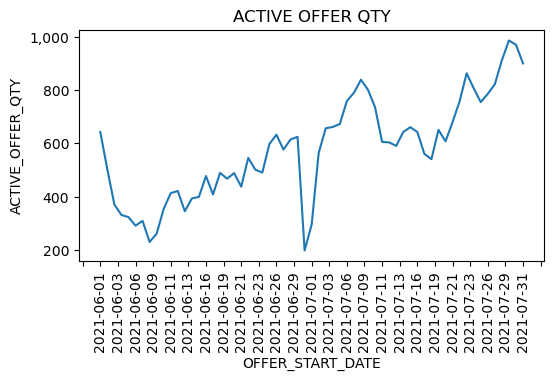

In [36]:
#Verificar OFERTAS ATIVAS
df_ativas = pandasql.sqldf("""
    SELECT 
        strftime('%Y-%m-%d',OFFER_START_DATE) OFFER_START_DATE, 
        SUM(CASE WHEN strftime('%Y-%m-%d',OFFER_FINISH_DTTM) <= strftime('%Y-%m-%d',OFFER_START_DATE) THEN 1 ELSE 0 END) AS ACTIVE_OFFER_QTY
  
    FROM df
      GROUP BY 1 
 
""")
df_ativas["OFFER_START_DATE"] = df_ativas["OFFER_START_DATE"].astype(str)
var = "ACTIVE_OFFER_QTY"
fig, axes = plt.subplots(1,1, figsize = (6,3))
sns.lineplot(data = df_ativas, x = "OFFER_START_DATE", y = var, ax = axes)
axes.tick_params(axis = 'x', labelrotation = 90)
plt.title(var.replace("_"," ")) 
axes.xaxis.set_major_locator(plt.MaxNLocator(30))
ylabels = ['{:,.0f}'.format(y) for y in axes.get_yticks()]
axes.set_yticklabels(ylabels)
fig.show();

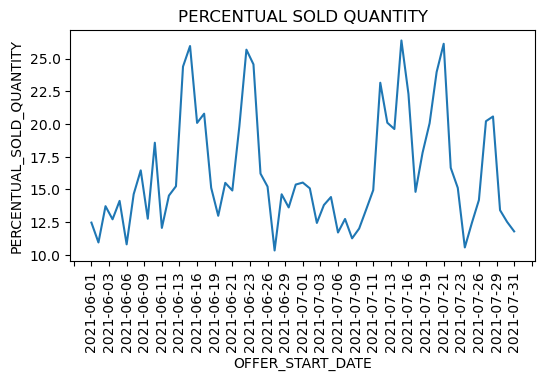

In [37]:
var = "PERCENTUAL_SOLD_QUANTITY"
fig, axes = plt.subplots(1,1, figsize = (6,3))
sns.lineplot(data = df_plot, x = "OFFER_START_DATE", y = var, ax = axes)
axes.tick_params(axis = 'x', labelrotation = 90)
plt.title(var.replace("_"," "))
axes.xaxis.set_major_locator(plt.MaxNLocator(30))
fig.show;

## 3.2 Variáveis numéricas

### Destaques/Observações

- Assim como a quantidade de novas ofertas apresenta tendência crescente ao longo do tempo, o estoque inicial, quantidade de venda e, por consequência, valor vendido,  também apresentam tendência positiva.

In [38]:
num_list = ["OFFER_HOURS", "INVOLVED_STOCK", "REMAINING_STOCK_AFTER_END_POSITIVE","SOLD_QUANTITY","ESTIMATED_SOLD_AMOUNT"] 

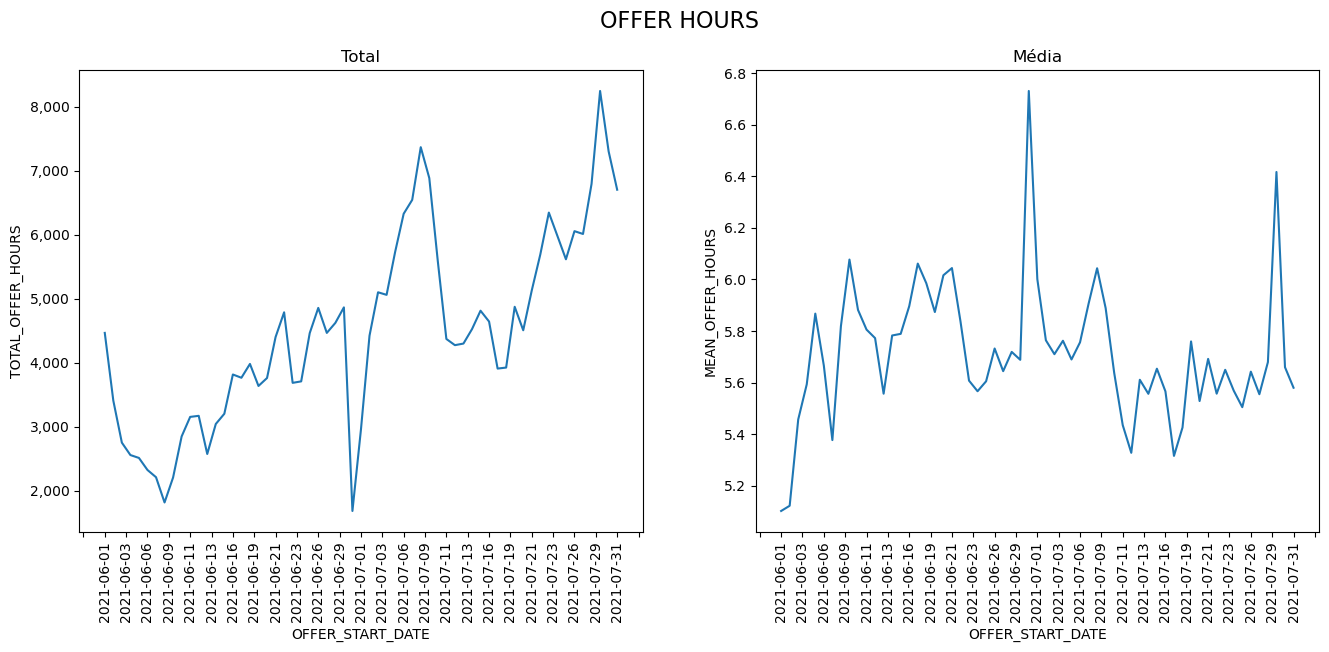

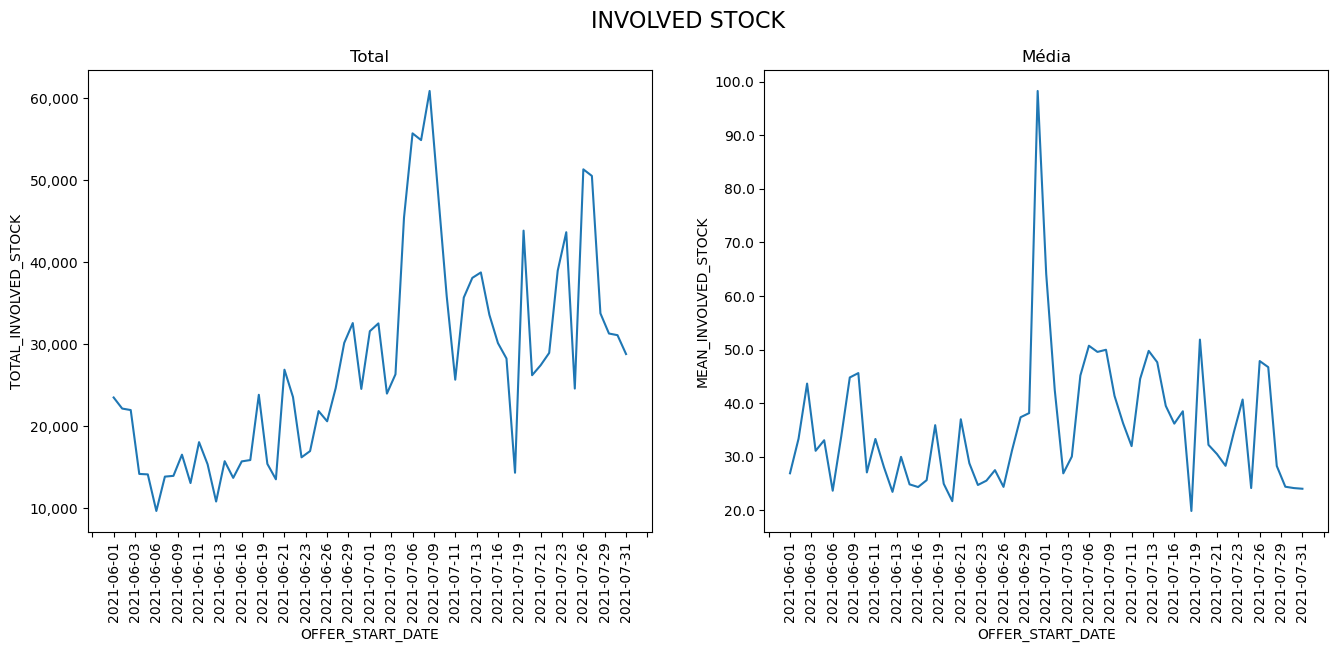

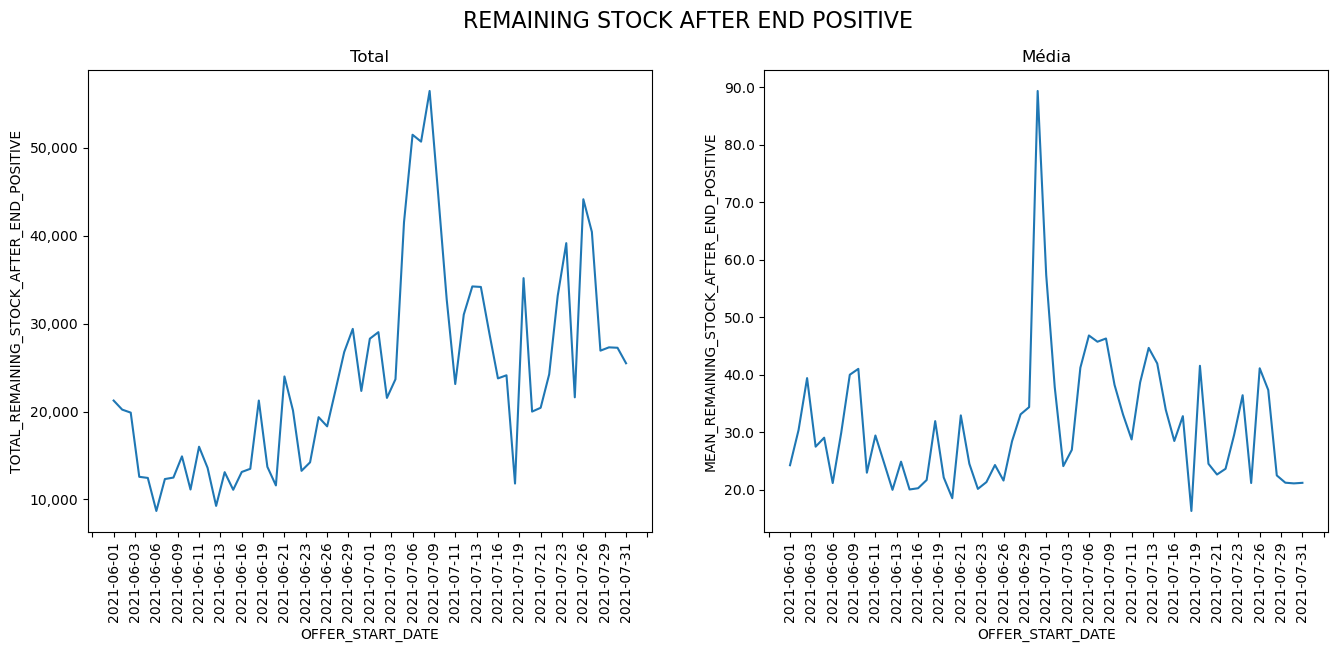

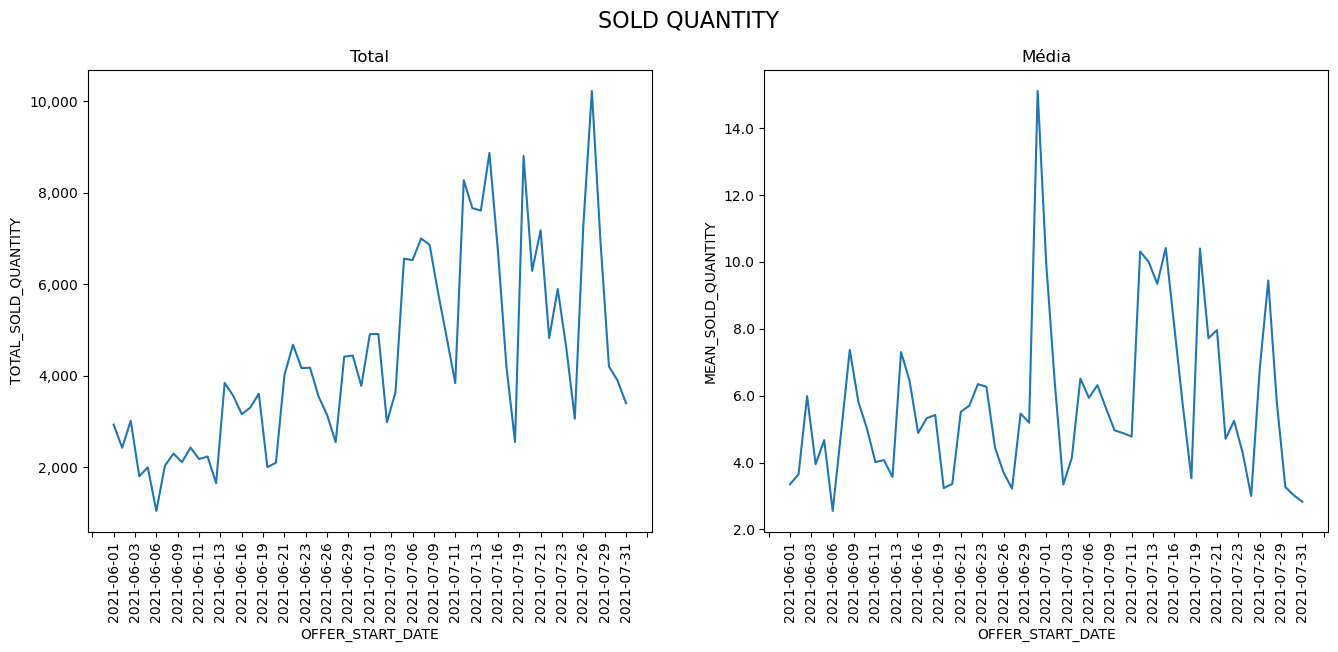

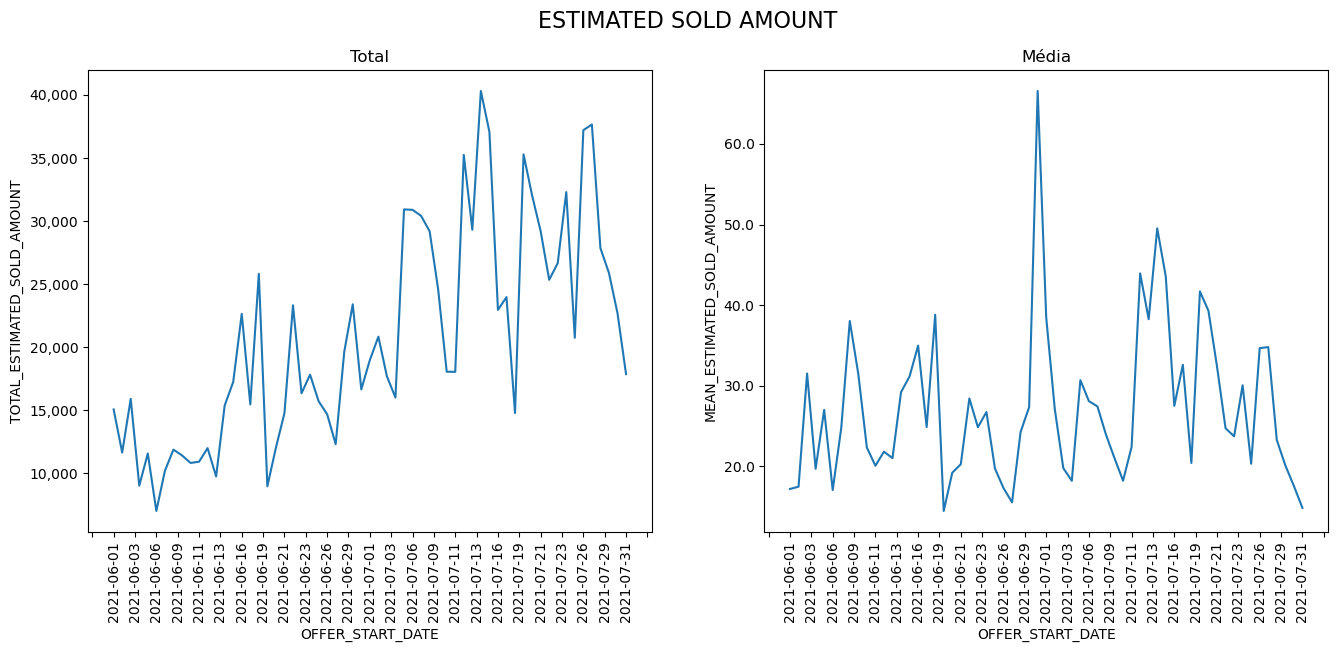

In [39]:
n_col = 2
n_row = 1

for num in num_list:
    fig, axes = plt.subplots(n_row, n_col, figsize = (n_col*8, n_row*6))
    fig.suptitle(num.replace("_"," "),size = 16)
    
    #total
    sns.lineplot(data = df_plot, x = "OFFER_START_DATE", y = "TOTAL_"+num, ax = axes[0])
    axes[0].tick_params(axis = 'x', labelrotation = 90)
    axes[0].title.set_text('Total')
    axes[0].xaxis.set_major_locator(plt.MaxNLocator(30))
    ylabels = ['{:,.0f}'.format(y) for y in axes[0].get_yticks()]
    axes[0].set_yticklabels(ylabels)

    #mean
    sns.lineplot(data = df_plot, x = "OFFER_START_DATE", y = "MEAN_"+num, ax = axes[1])
    axes[1].tick_params(axis = 'x', labelrotation = 90)
    axes[1].title.set_text('Média')
    axes[1].xaxis.set_major_locator(plt.MaxNLocator(30))
    ylabels = ['{:,.1f}'.format(y) for y in axes[1].get_yticks()]
    axes[1].set_yticklabels(ylabels)

    fig.show
    

## 3.3 Variáveis categóricas

### Destaques/Observações

- Cerca de 80% das ofertas possuem origem desconhecida, porém, 70% dos itens vendidados são da ORIGIN 'A';
- Dos itens vendidos, 75% não possuem informação de método de pagamento do envio (SHIPPING_PAYMENT_TYPE). Contudo, ao verificar por montante, observa-se que 59% do valor arrecadado veio de produtos que possuem 'free_shipping'. Este fenômeno pode estar relacionado à políticas internas de ofertas, como por exemplo, oferecer frete grátis a partir de uma compra de determinado valor;
- A principal VERTICAL é a 'BEAUTY & HEALTH', sendo responsável por 66% dos itens vendidos e 43% do montante total vendido. Isso pode ser atribuído ao período de pandemia (Covid-19) e não necessáriamente reflete outros períodos mais recentes;
- A VERTICAL 'CE' é a segunda mais importante em relação ao montante vendido. O valor unitário desta vertical é na média maior que 'HOME & INDUSTRY' e 'APP & SPORTS';
- As ofertas que não possuem tempo de duração (data e hora de início é igual à data e hora de finalização) representam 2.6% e estão uniformente distribuídas ao longo do tempo. O estoque inicial nos 2 meses destas ofertas representam 29,5 mil itens.

In [40]:
cat_list = ["ORIGIN", "SHIPPING_PAYMENT_TYPE", "VERTICAL","NO_OFFER_TIME"]

In [41]:
num_list = ['OFFER_QTY','OFFER_HOURS','INVOLVED_STOCK', 
            'REMAINING_STOCK_AFTER_END_POSITIVE', 'SOLD_QUANTITY', 'ESTIMATED_SOLD_AMOUNT'] #acrescentar TOTAL_OFFER_QTY

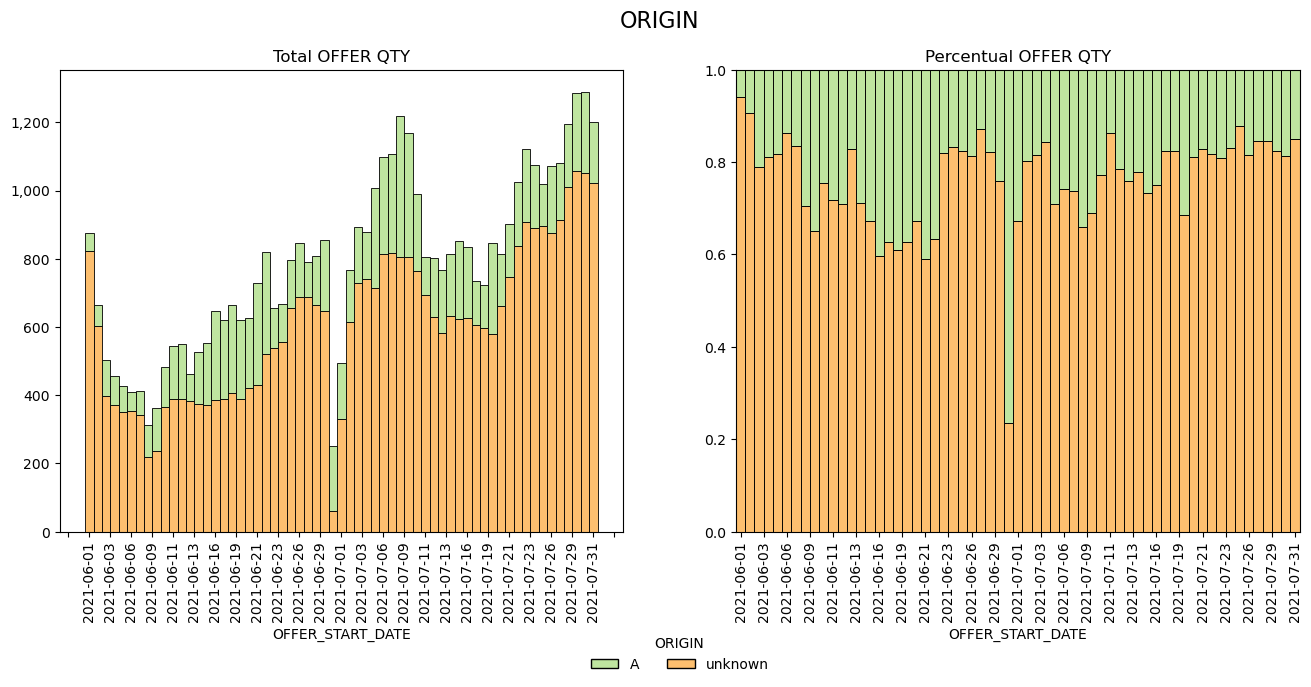

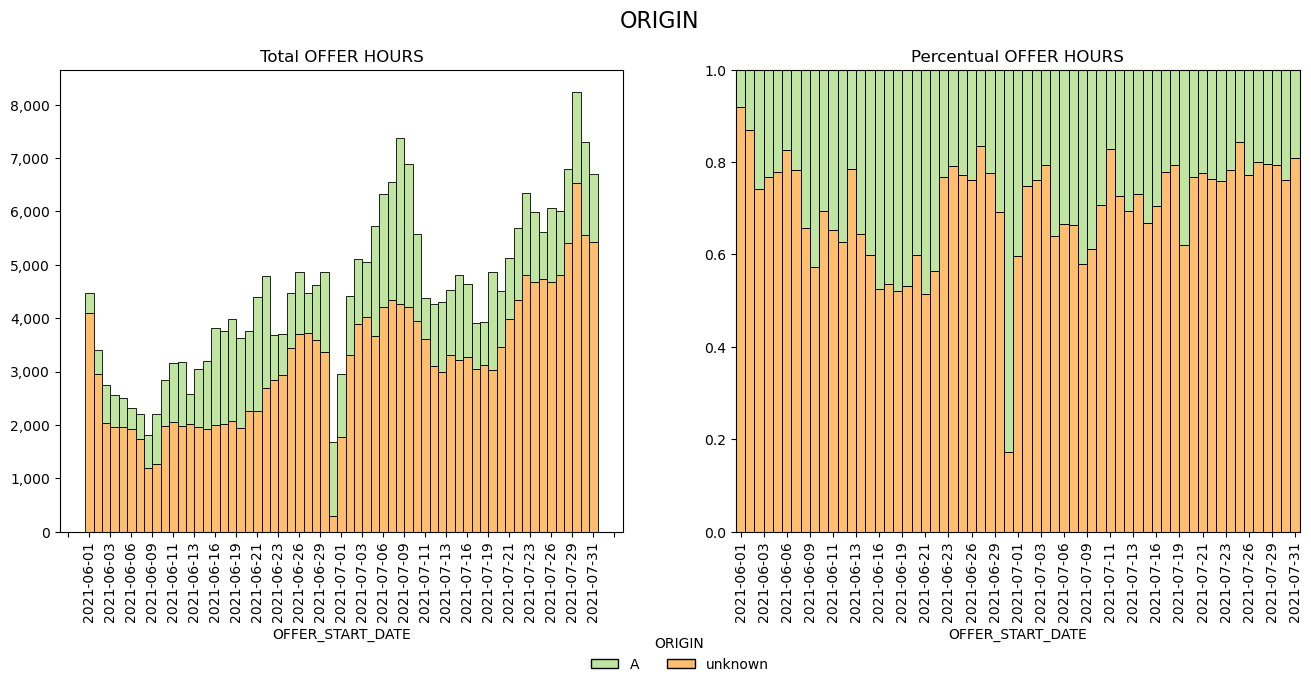

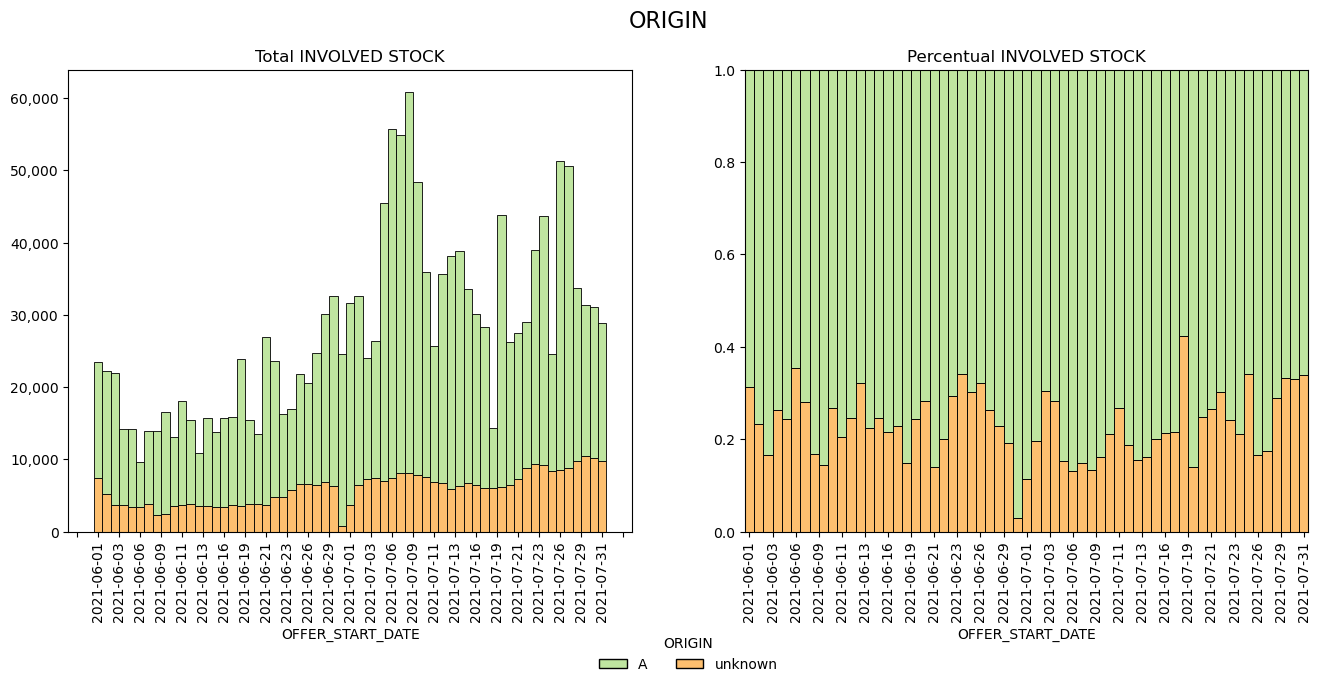

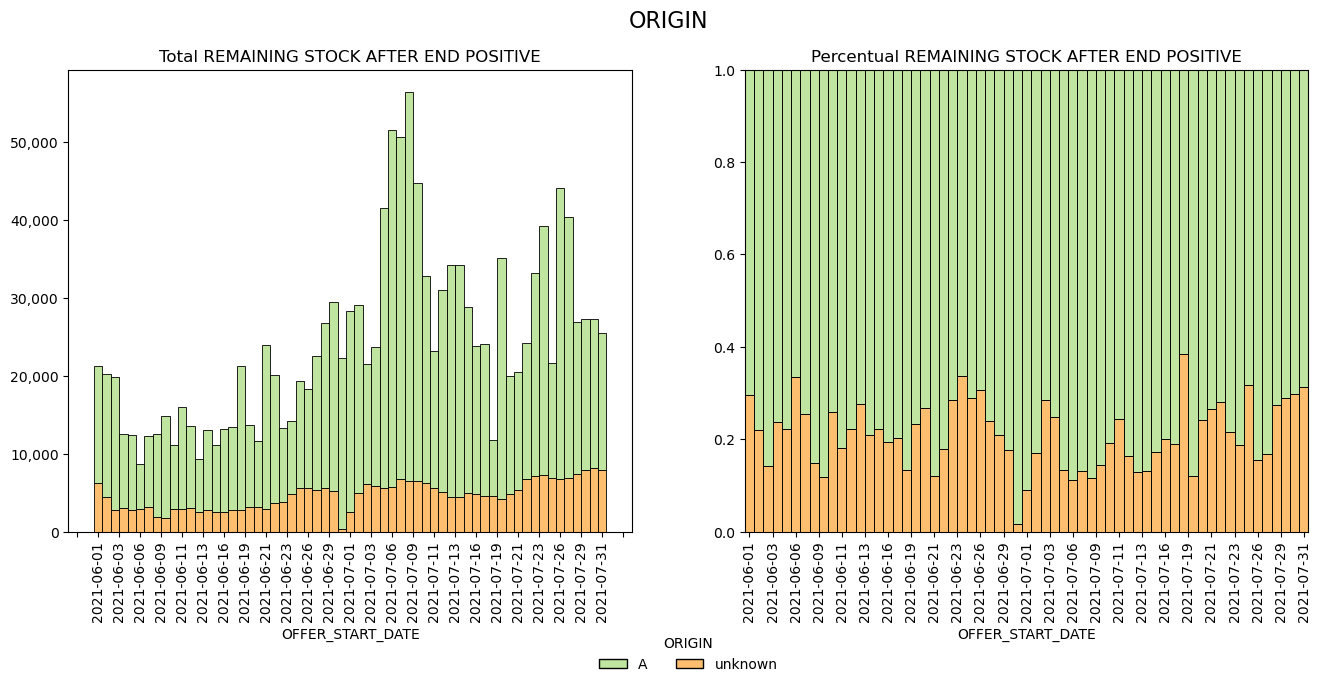

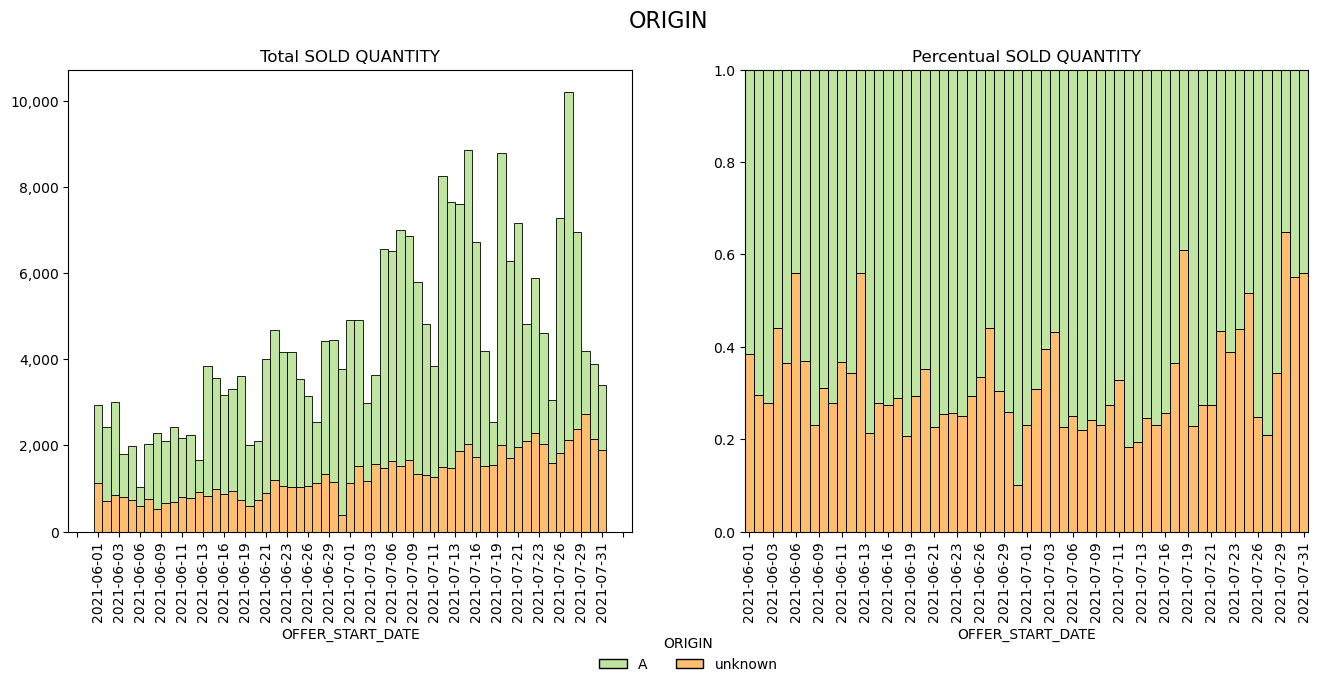

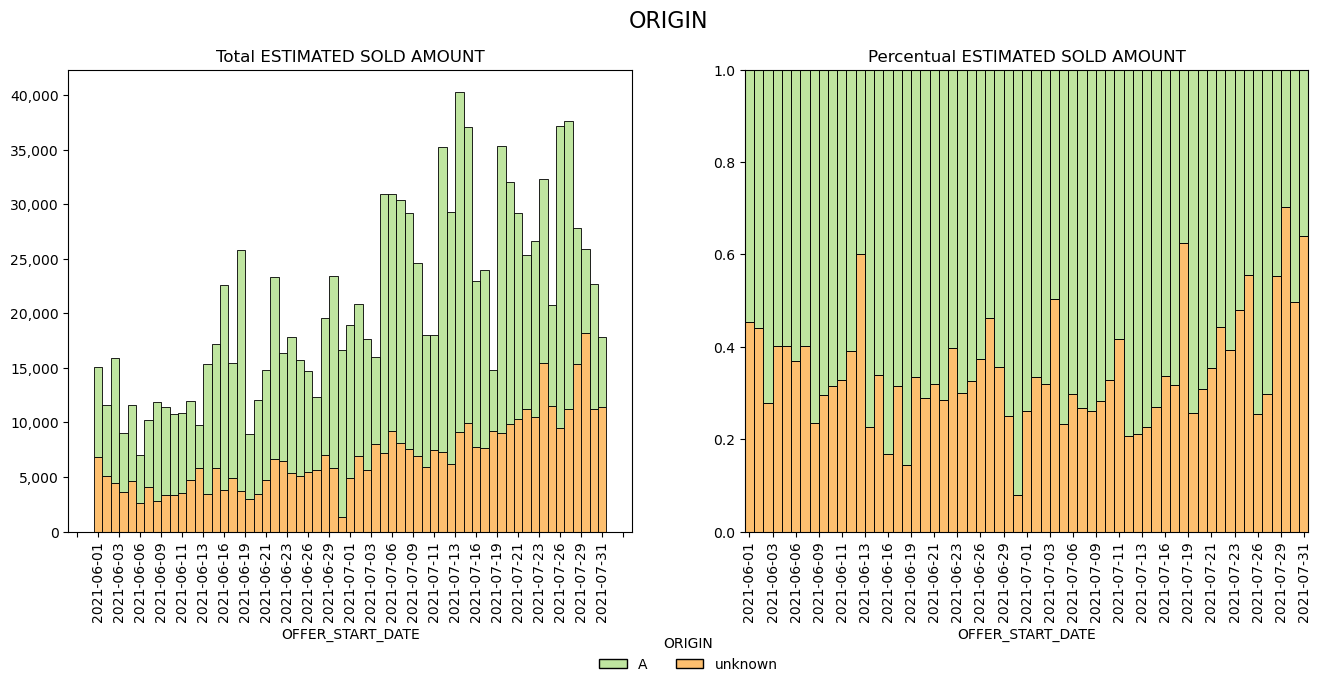

Valores consolidados


ORIGIN                                              A    unknown
TOTAL_OFFER_QTY                             10,845.00  36,975.00
PCT_OFFER_QTY                                   22.68      77.32
TOTAL_OFFER_HOURS                           77,833.02 194,850.75
PCT_OFFER_HOURS                                 28.54      71.46
TOTAL_INVOLVED_STOCK                     1,318,292.00 362,729.00
PCT_INVOLVED_STOCK                              78.42      21.58
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE 1,183,414.00 285,645.00
PCT_REMAINING_STOCK_AFTER_END_POSITIVE          80.56      19.44
TOTAL_SOLD_QUANTITY                        188,933.00  80,104.00
PCT_SOLD_QUANTITY                               70.23      29.77
TOTAL_ESTIMATED_SOLD_AMOUNT                842,014.01 426,984.60
PCT_ESTIMATED_SOLD_AMOUNT                       66.35      33.65

______________________________________________________________________________________________________________________________


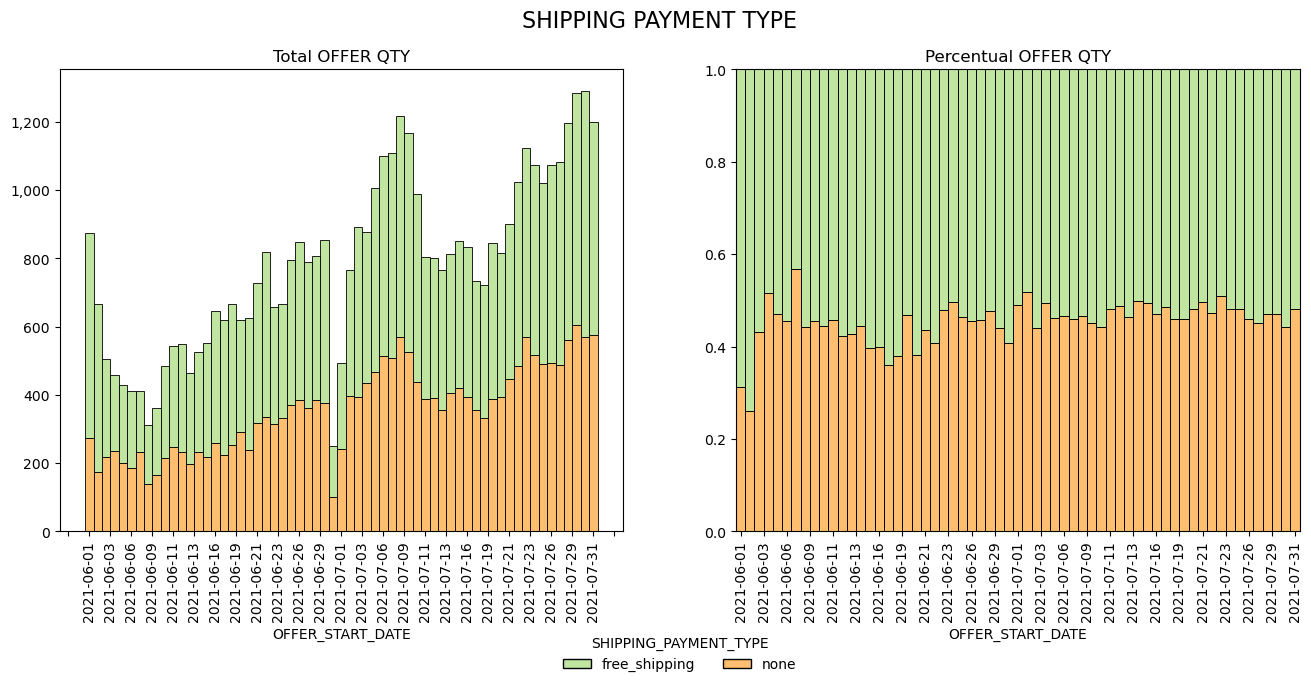

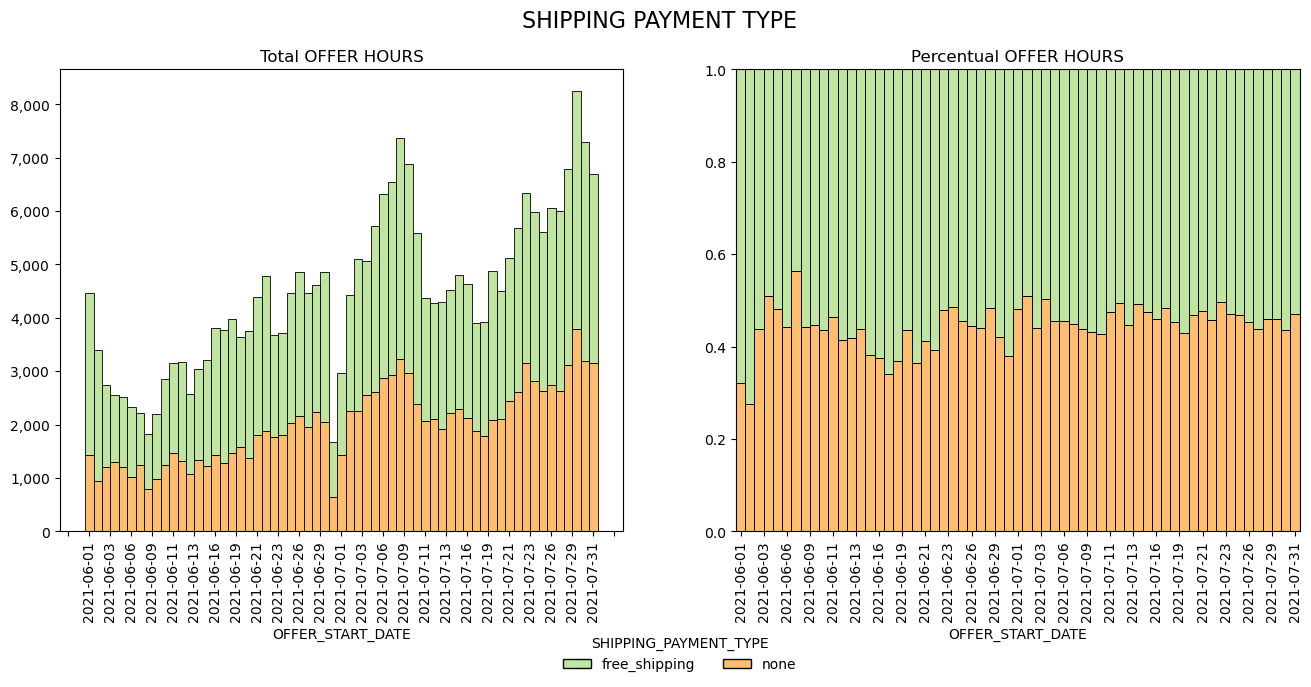

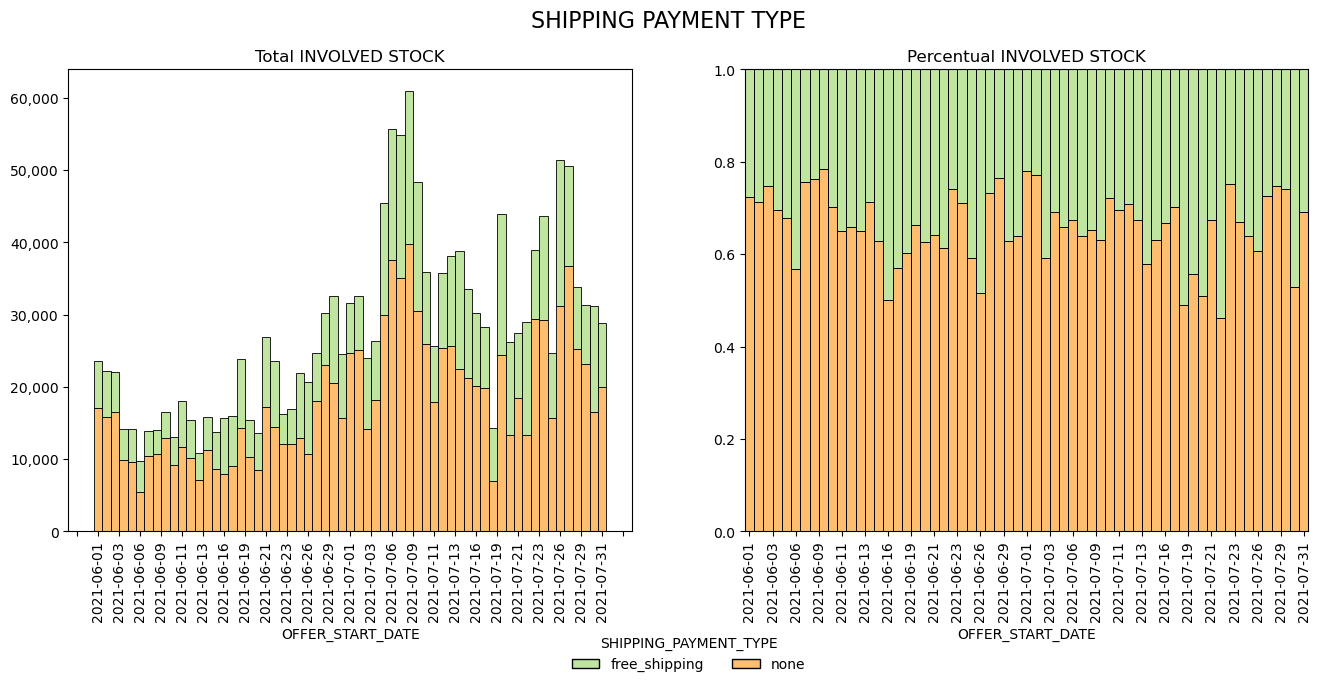

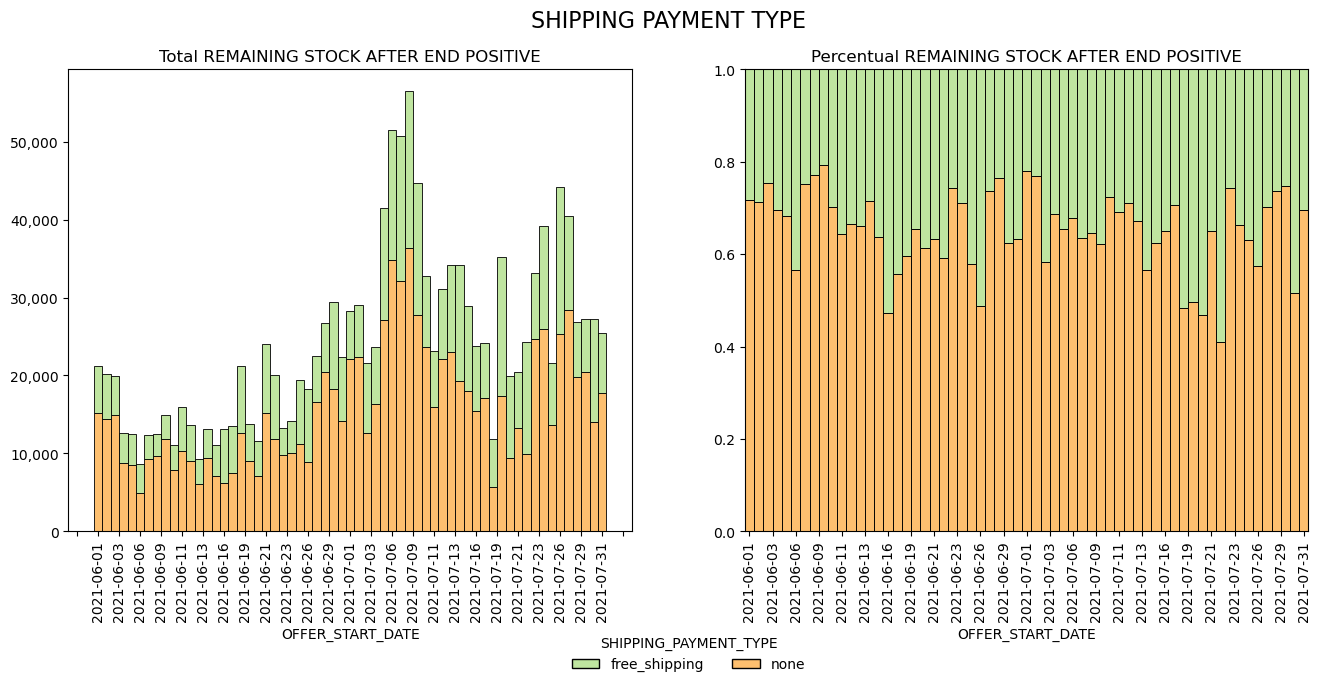

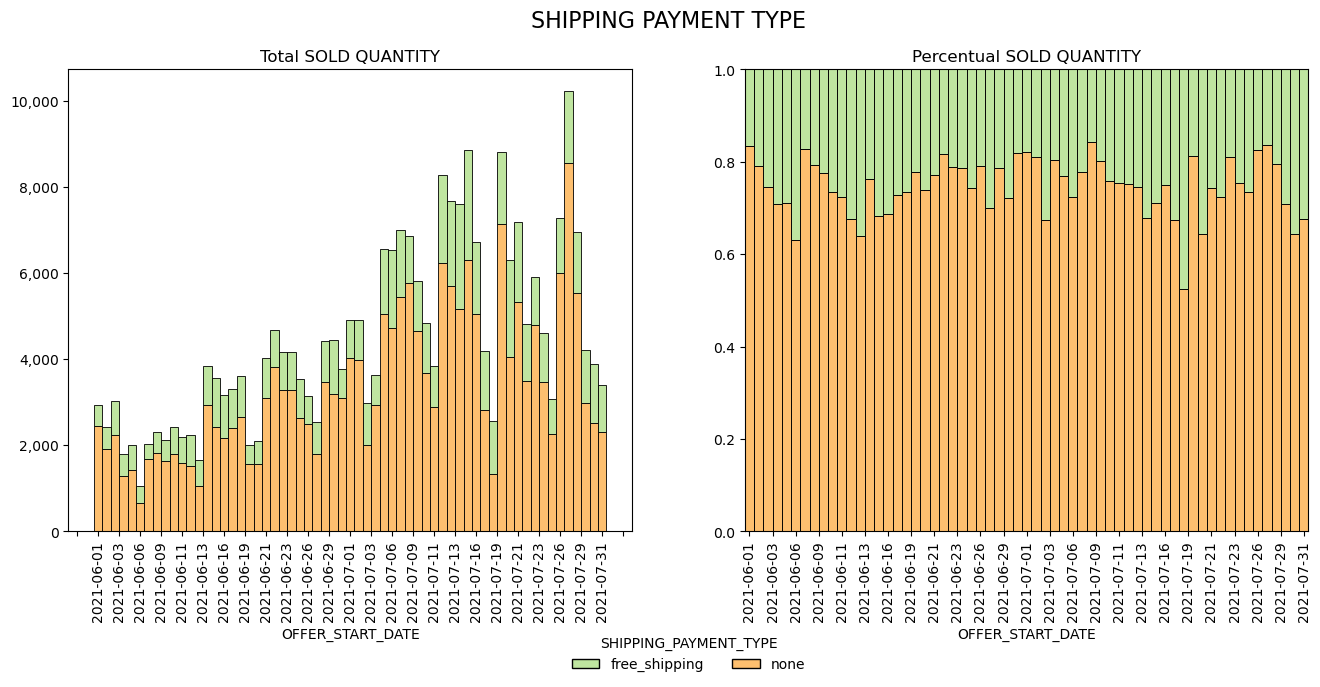

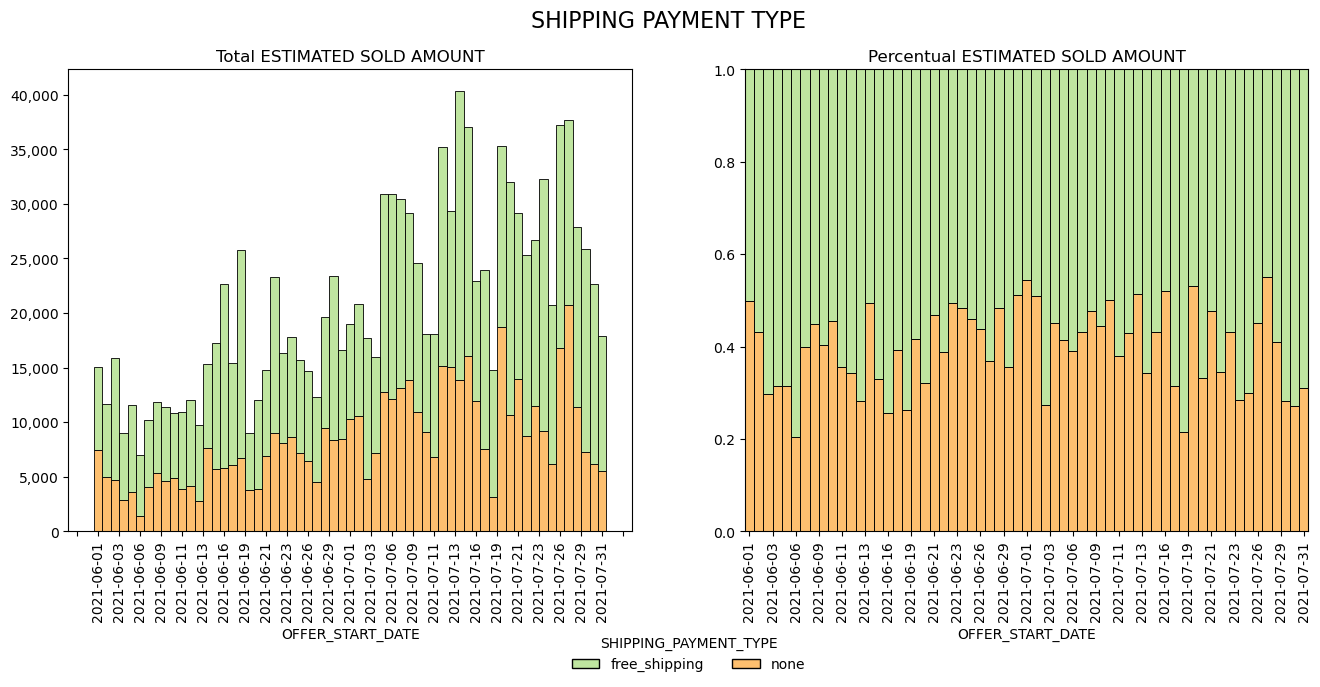

Valores consolidados


SHIPPING_PAYMENT_TYPE                     free_shipping         none
TOTAL_OFFER_QTY                               25,995.00    21,825.00
PCT_OFFER_QTY                                     54.36        45.64
TOTAL_OFFER_HOURS                            151,123.58   121,560.20
PCT_OFFER_HOURS                                   55.42        44.58
TOTAL_INVOLVED_STOCK                         570,693.00 1,110,328.00
PCT_INVOLVED_STOCK                                33.95        66.05
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE     510,924.00   958,135.00
PCT_REMAINING_STOCK_AFTER_END_POSITIVE            34.78        65.22
TOTAL_SOLD_QUANTITY                           65,993.00   203,044.00
PCT_SOLD_QUANTITY                                 24.53        75.47
TOTAL_ESTIMATED_SOLD_AMOUNT                  756,361.70   512,636.91
PCT_ESTIMATED_SOLD_AMOUNT                         59.60        40.40

______________________________________________________________________________________________________________________________


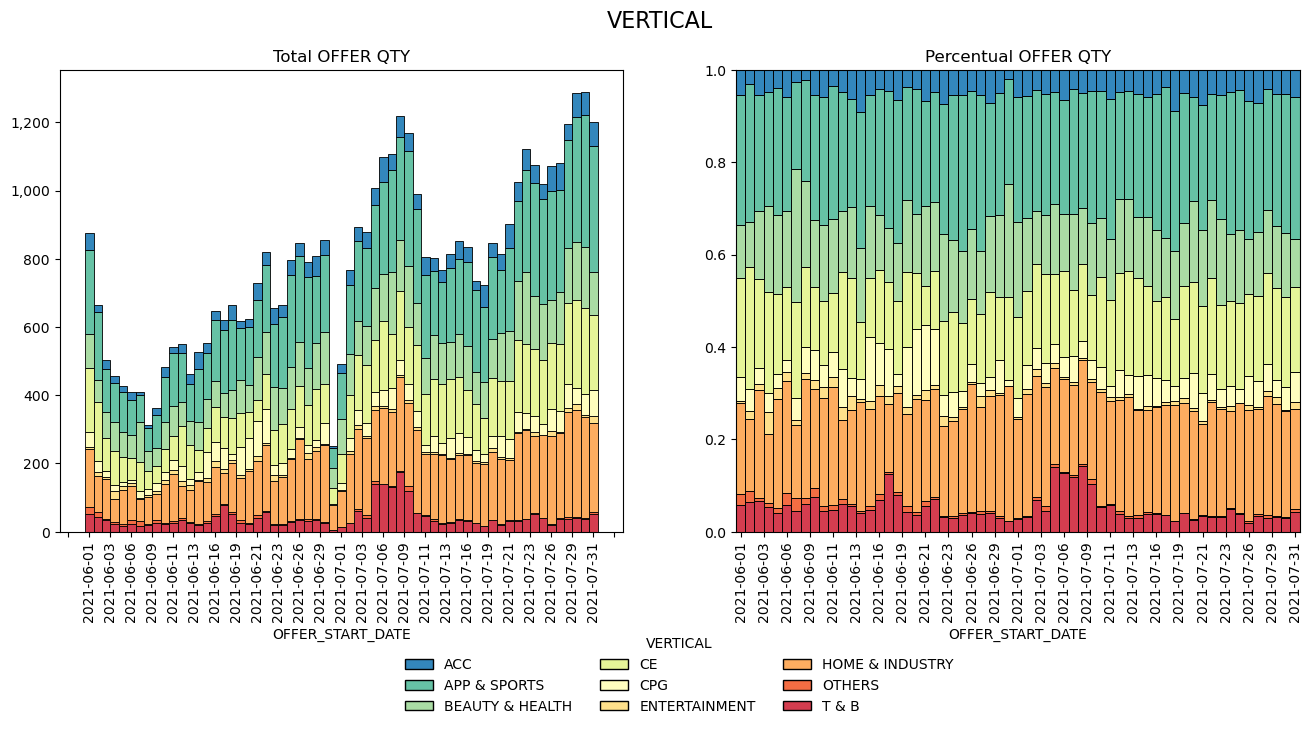

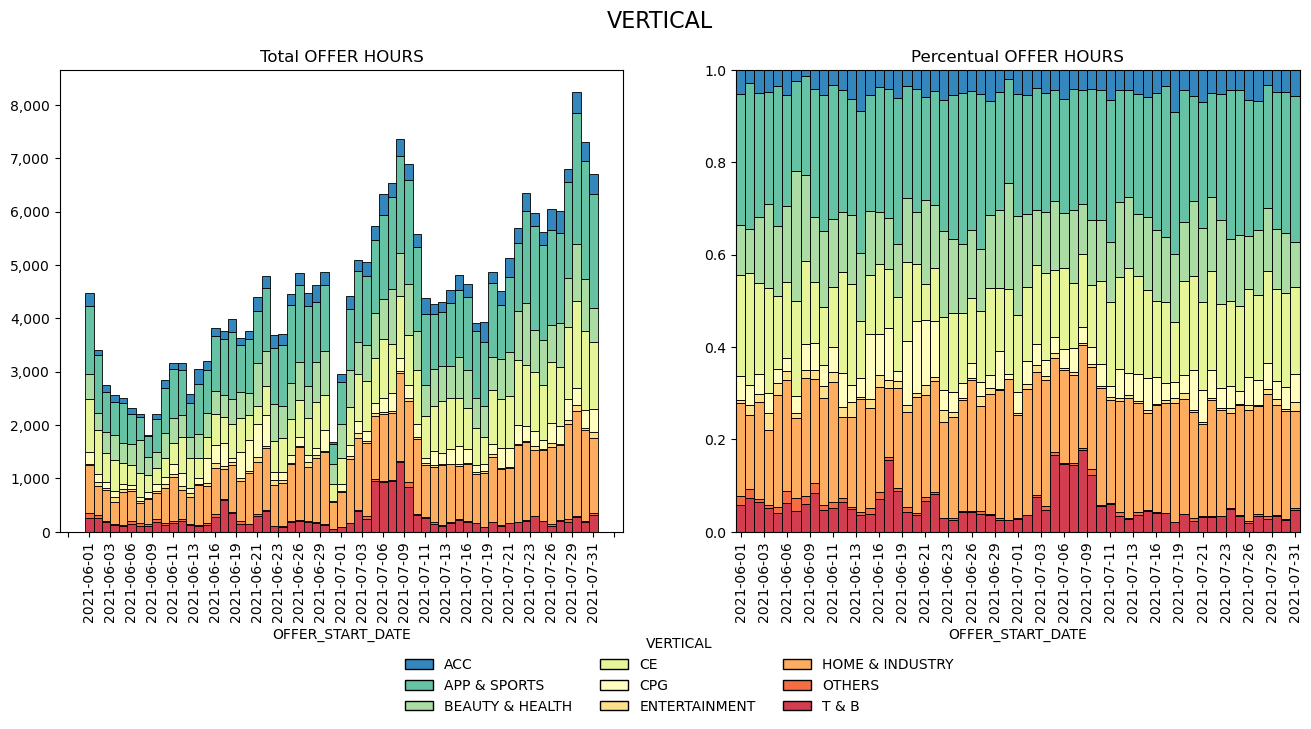

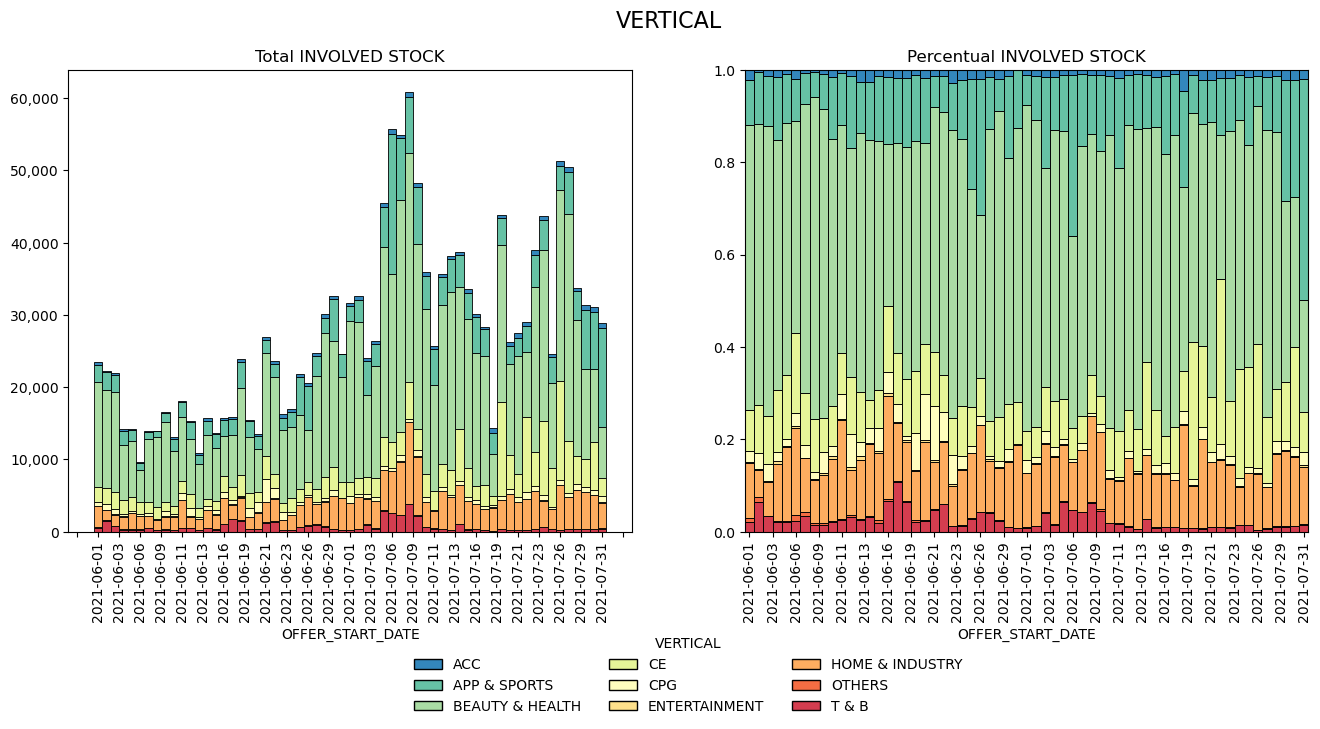

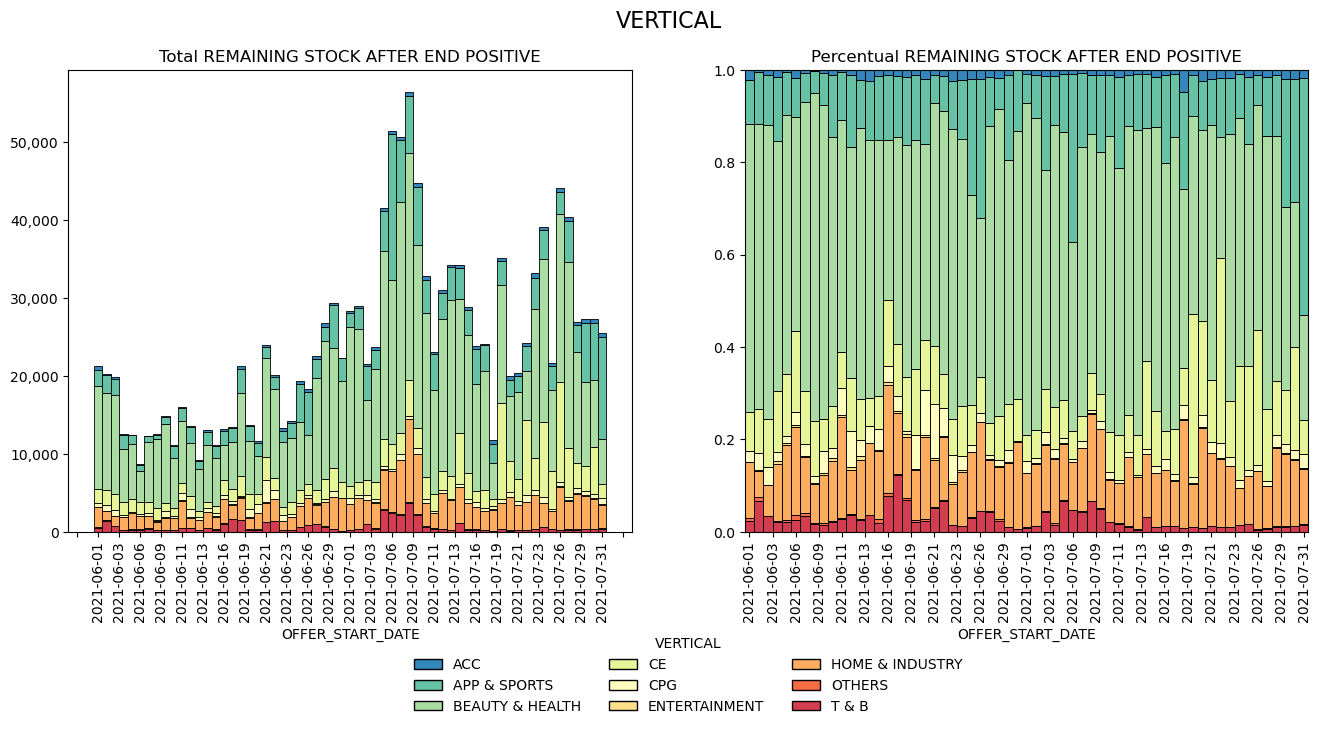

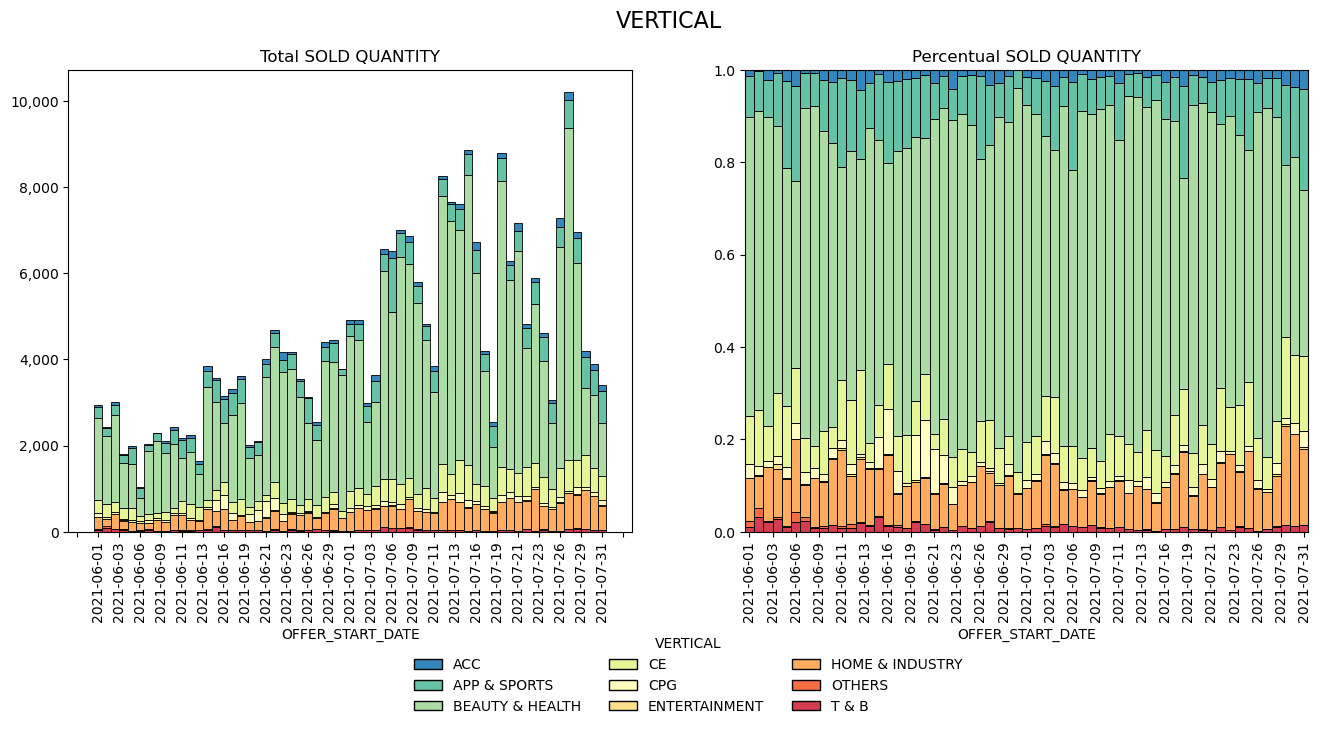

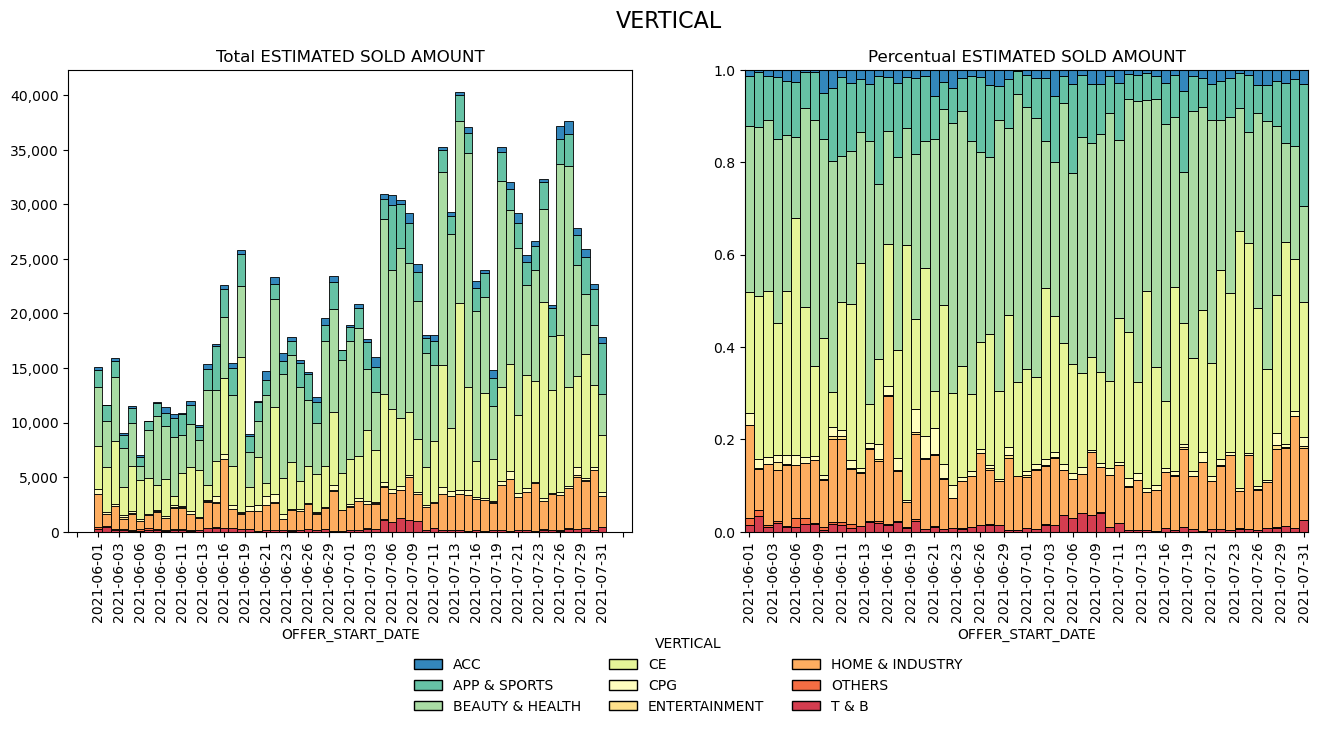

Valores consolidados


VERTICAL                                       ACC  APP & SPORTS  \
TOTAL_OFFER_QTY                           2,553.00     13,065.00   
PCT_OFFER_QTY                                 5.34         27.32   
TOTAL_OFFER_HOURS                        13,729.55     74,952.55   
PCT_OFFER_HOURS                               5.03         27.49   
TOTAL_INVOLVED_STOCK                     24,468.00    238,003.00   
PCT_INVOLVED_STOCK                            1.46         14.16   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE 19,512.00    214,067.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE        1.33         14.57   
TOTAL_SOLD_QUANTITY                       5,198.00     25,654.00   
PCT_SOLD_QUANTITY                             1.93          9.54   
TOTAL_ESTIMATED_SOLD_AMOUNT              27,155.84    131,068.35   
PCT_ESTIMATED_SOLD_AMOUNT                     2.14         10.33   

VERTICAL                                  BEAUTY & HEALTH         CE  \
TOTAL_OFFER_QTY                                  7,068.00   8,373.00   
PCT_OFFER_QTY                                       14.78      17.51   
TOTAL_OFFER_HOURS                               39,133.72  47,166.09   
PCT_OFFER_HOURS                                     14.35      17.30   
TOTAL_INVOLVED_STOCK                           909,081.00 203,814.00   
PCT_INVOLVED_STOCK                                  54.08      12.12   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE       785,729.00 179,260.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE              53.49      12.20   
TOTAL_SOLD_QUANTITY                            178,175.00  23,531.00   
PCT_SOLD_QUANTITY                                   66.23       8.75   
TOTAL_ESTIMATED_SOLD_AMOUNT                    547,483.57 369,789.80   
PCT_ESTIMATED_SOLD_AMOUNT                           43.14      29.14   

VERTICAL                                       CPG  ENTERTAINMENT  \
TOTAL_OFFER_QTY                           2,631.00         498.00   
PCT_OFFER_QTY                                 5.50           1.04   
TOTAL_OFFER_HOURS                        14,905.89       2,881.83   
PCT_OFFER_HOURS                               5.47           1.06   
TOTAL_INVOLVED_STOCK                     38,589.00       3,033.00   
PCT_INVOLVED_STOCK                            2.30           0.18   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE 32,904.00       2,678.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE        2.24           0.18   
TOTAL_SOLD_QUANTITY                       5,849.00         363.00   
PCT_SOLD_QUANTITY                             2.17           0.13   
TOTAL_ESTIMATED_SOLD_AMOUNT              17,257.88       2,083.83   
PCT_ESTIMATED_SOLD_AMOUNT                     1.36           0.16   

VERTICAL                                  HOME & INDUSTRY   OTHERS     T & B  
TOTAL_OFFER_QTY                                 10,822.00   276.00  2,534.00  
PCT_OFFER_QTY                                       22.63     0.58      5.30  
TOTAL_OFFER_HOURS                               62,686.19 1,536.96 15,690.99  
PCT_OFFER_HOURS                                     22.99     0.56      5.75  
TOTAL_INVOLVED_STOCK                           218,857.00 2,855.00 42,321.00  
PCT_INVOLVED_STOCK                                  13.02     0.17      2.52  
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE       192,507.00 2,505.00 39,897.00  
PCT_REMAINING_STOCK_AFTER_END_POSITIVE              13.10     0.17      2.72  
TOTAL_SOLD_QUANTITY                             27,400.00   357.00  2,510.00  
PCT_SOLD_QUANTITY                                   10.18     0.13      0.93  
TOTAL_ESTIMATED_SOLD_AMOUNT                    156,766.13 1,929.24 15,463.97  
PCT_ESTIMATED_SOLD_AMOUNT                           12.35     0.15      1.22

______________________________________________________________________________________________________________________________


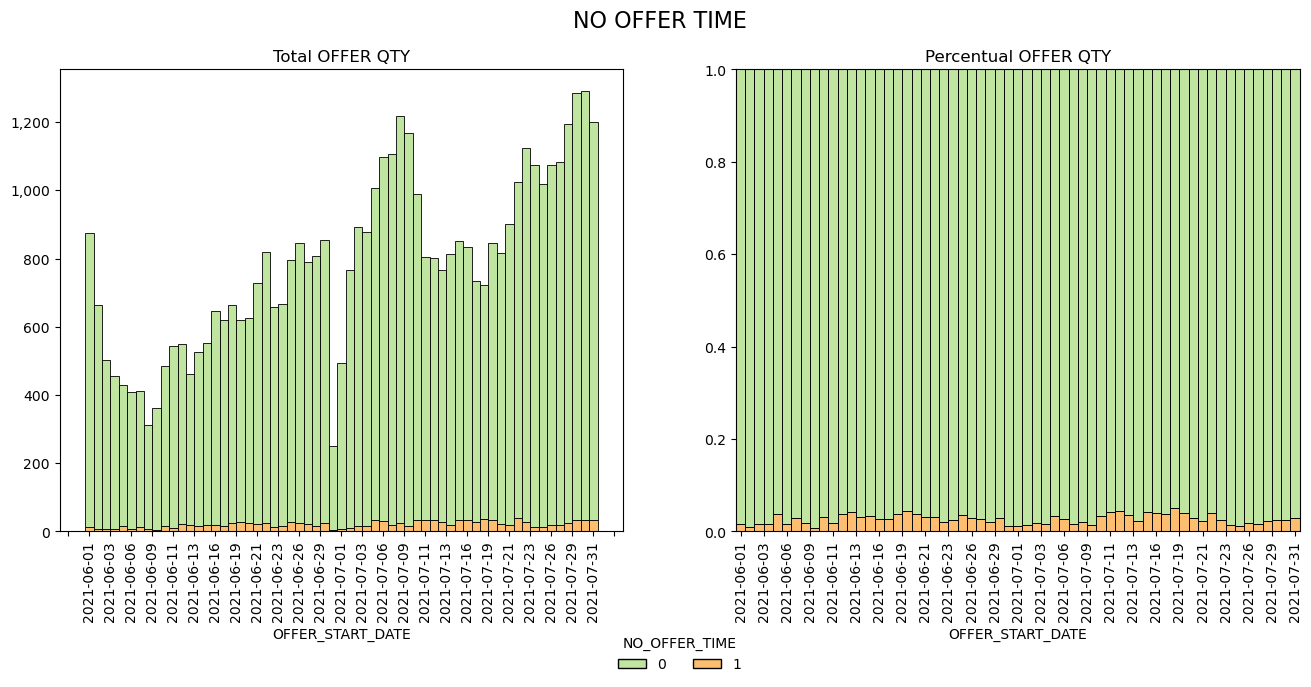

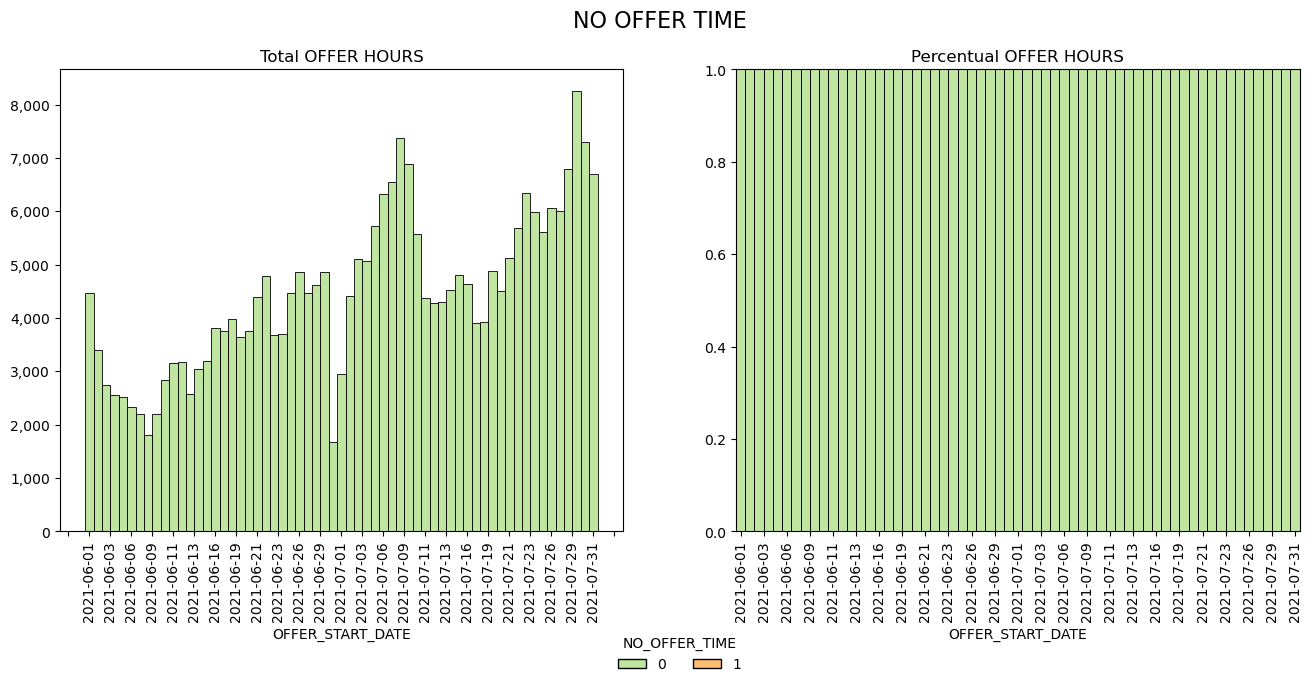

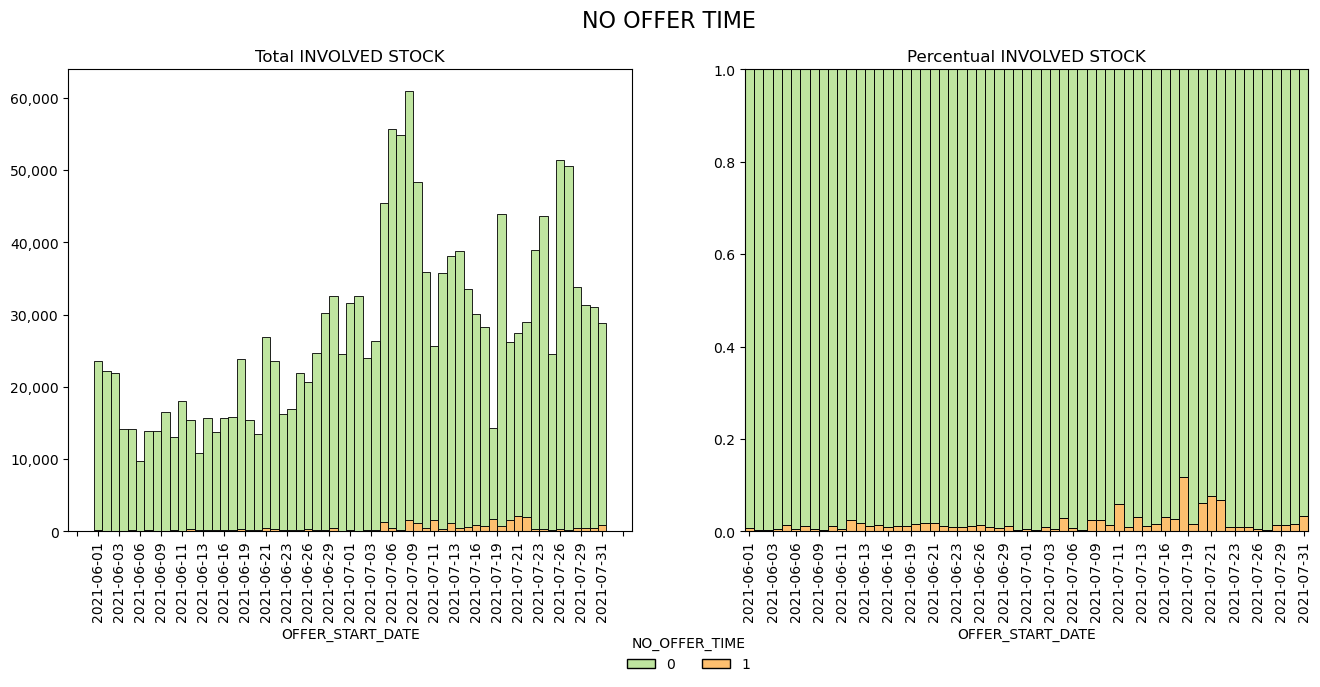

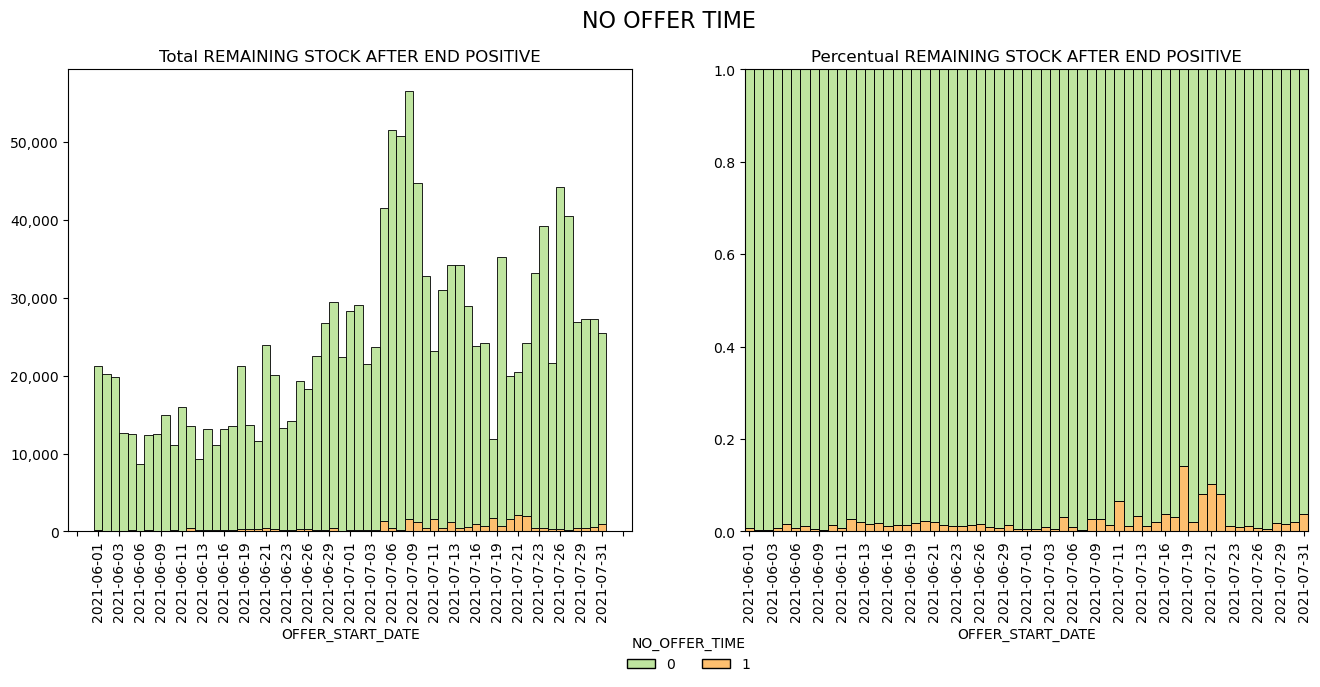

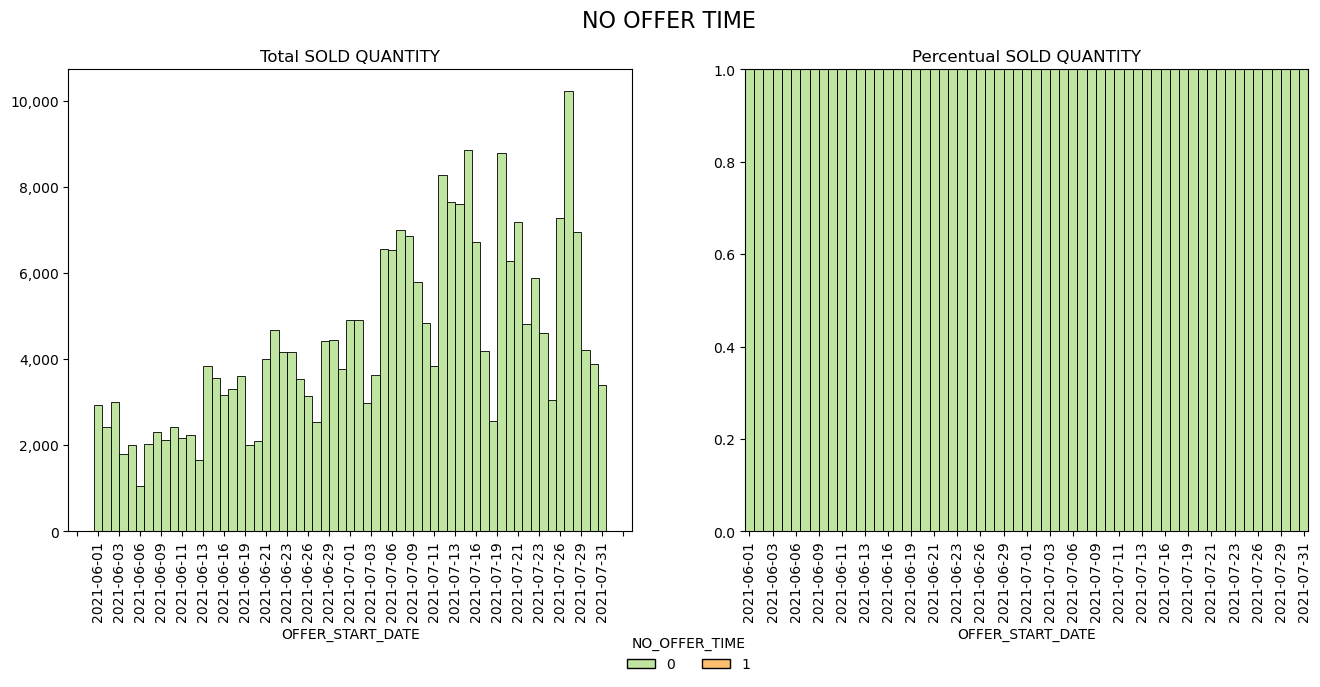

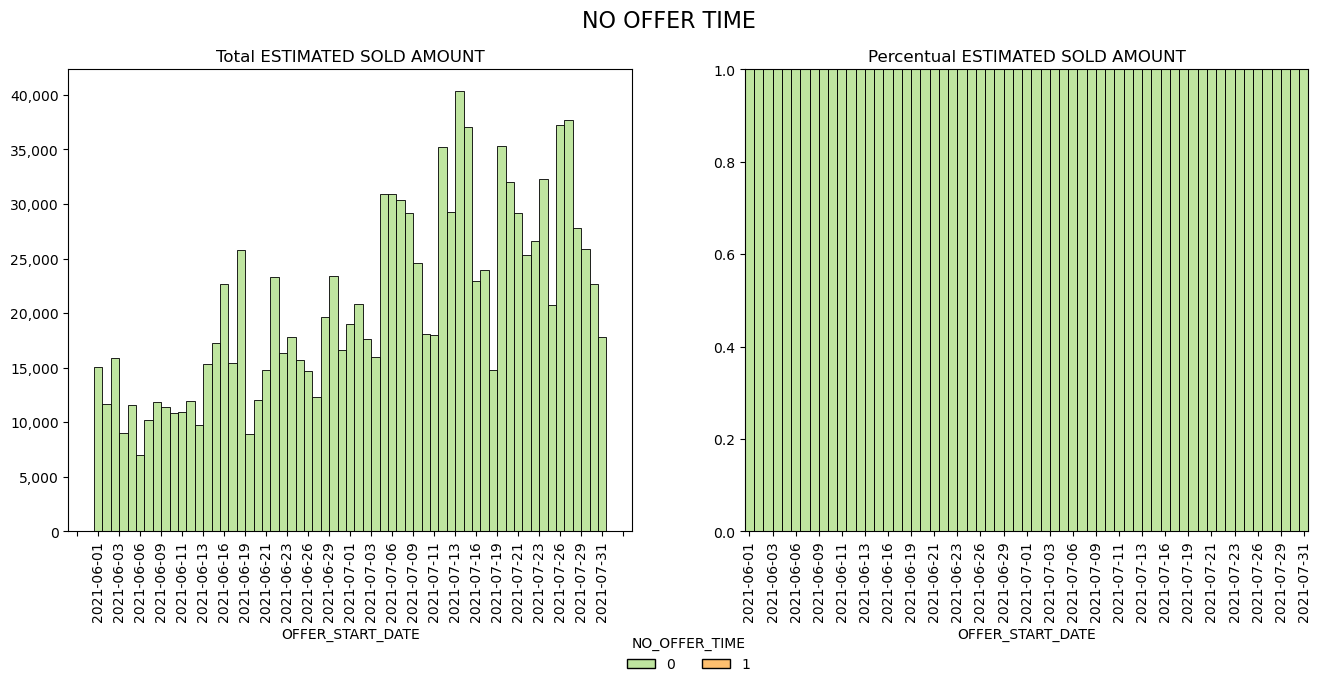

Valores consolidados


NO_OFFER_TIME                                       0         1
TOTAL_OFFER_QTY                             46,549.00  1,271.00
PCT_OFFER_QTY                                   97.34      2.66
TOTAL_OFFER_HOURS                          272,683.78      0.00
PCT_OFFER_HOURS                                100.00      0.00
TOTAL_INVOLVED_STOCK                     1,651,447.00 29,574.00
PCT_INVOLVED_STOCK                              98.24      1.76
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE 1,439,485.00 29,574.00
PCT_REMAINING_STOCK_AFTER_END_POSITIVE          97.99      2.01
TOTAL_SOLD_QUANTITY                        269,037.00      0.00
PCT_SOLD_QUANTITY                              100.00      0.00
TOTAL_ESTIMATED_SOLD_AMOUNT              1,268,998.61      0.00
PCT_ESTIMATED_SOLD_AMOUNT                      100.00      0.00

______________________________________________________________________________________________________________________________


In [42]:
n_col = 2
n_row = 1

for cat in cat_list:
    
    #gerar df plot
    df_plot = df.groupby(["OFFER_START_DATE", cat]).agg(
        TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()),       
        
        TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
        TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
        TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
        TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
        TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum())
    )
    df_plot = df_plot.reset_index()
    df_plot["OFFER_START_DATE"] = df_plot["OFFER_START_DATE"].astype(str)
    
    for num in num_list:

        #gerar plot
        fig, axes = plt.subplots(n_row, n_col, figsize = (n_col*8, n_row*6))
        fig.suptitle(cat.replace("_"," "),size = 16)

        #total
        sns.histplot(data = df_plot, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[0], 
                     hue = cat, multiple = "stack", stat="count", palette = "Spectral_r", alpha = 1, legend = False)
        axes[0].tick_params(axis = 'x', labelrotation = 90)
        axes[0].title.set_text('Total ' + num.replace("_"," "))
        axes[0].xaxis.set_major_locator(plt.MaxNLocator(30))
        axes[0].set(ylabel=None)
        ylabels = ['{:,.0f}'.format(y) for y in axes[0].get_yticks()]
        axes[0].set_yticklabels(ylabels)

        #percentual
        sns.histplot(data = df_plot, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[1], 
                     hue = cat, multiple = "fill", stat="percent", palette = "Spectral_r", alpha = 1)
        axes[1].tick_params(axis = 'x', labelrotation = 90)
        axes[1].title.set_text('Percentual ' + num.replace("_"," "))
        axes[1].xaxis.set_major_locator(plt.MaxNLocator(30))
        axes[1].set(ylabel=None)
        sns.move_legend(axes[1],'upper center', bbox_to_anchor=(-0.1, -0.2), ncol = 3, frameon = False)
        plt.close(fig)
        
        #fig.show
        display(fig)
    #resumo
    df_resumo = df.groupby([cat]).agg(
        TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()), 
        PCT_OFFER_QTY = ("OFFER_START_DATE", lambda x: (x.count()/df["OFFER_HOURS"].count())*100), 
        TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
        PCT_OFFER_HOURS = ("OFFER_HOURS", lambda x: (x.sum()/df["OFFER_HOURS"].sum())*100),
        TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
        PCT_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: (x.sum()/df["INVOLVED_STOCK"].sum())*100),
        TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
        PCT_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: (x.sum()/df["REMAINING_STOCK_AFTER_END_POSITIVE"].sum())*100),
        TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
        PCT_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: (x.sum()/df["SOLD_QUANTITY"].sum())*100),
        TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum()),
        PCT_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: (x.sum()/df["ESTIMATED_SOLD_AMOUNT"].sum())*100)

    ).T
    print("Valores consolidados")
    display(df_resumo)
     
    print("______________________________________________________________________________________________________________________________")




## 3.4 Top categorias nos 2 meses

### Destaques/Observações

- Os principais DOM_DOMAIN_AGG1 em relação à quantidade vendida e ao valor arrecadado são: 'PHARMACEUTICS', 'BEAUTY EQUIPMENT' e 'HOME&DECOR'. Juntos representam 70% dos itens vendidos e 48% do montante.
- Vale destacar a importância de DOM_DOMAIN_AGG1 'MOBILE', já que é responsável por 12% do montante.
- Em relação ao DOMAIN_ID, 'MLM-SURGICAL_AND_INDUSTRIAL_MASKS' foi o principal ID em quantidade vendida, 52%, e valor vendido, 32% do total.

In [43]:
cat_list = ["DOM_DOMAIN_AGG1", "DOMAIN_ID"]

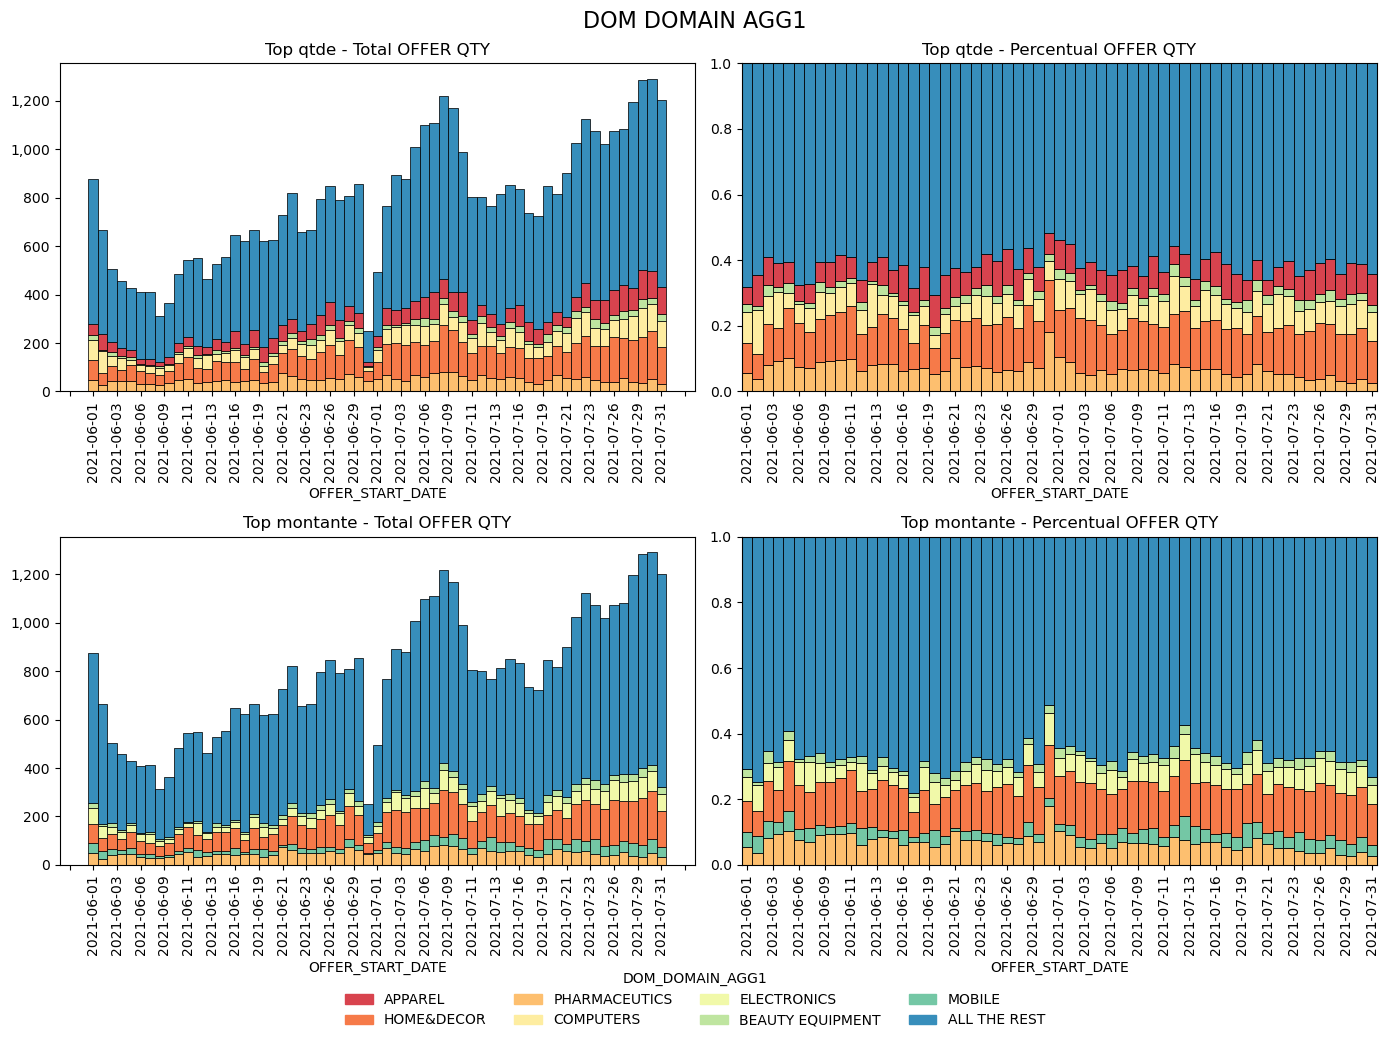

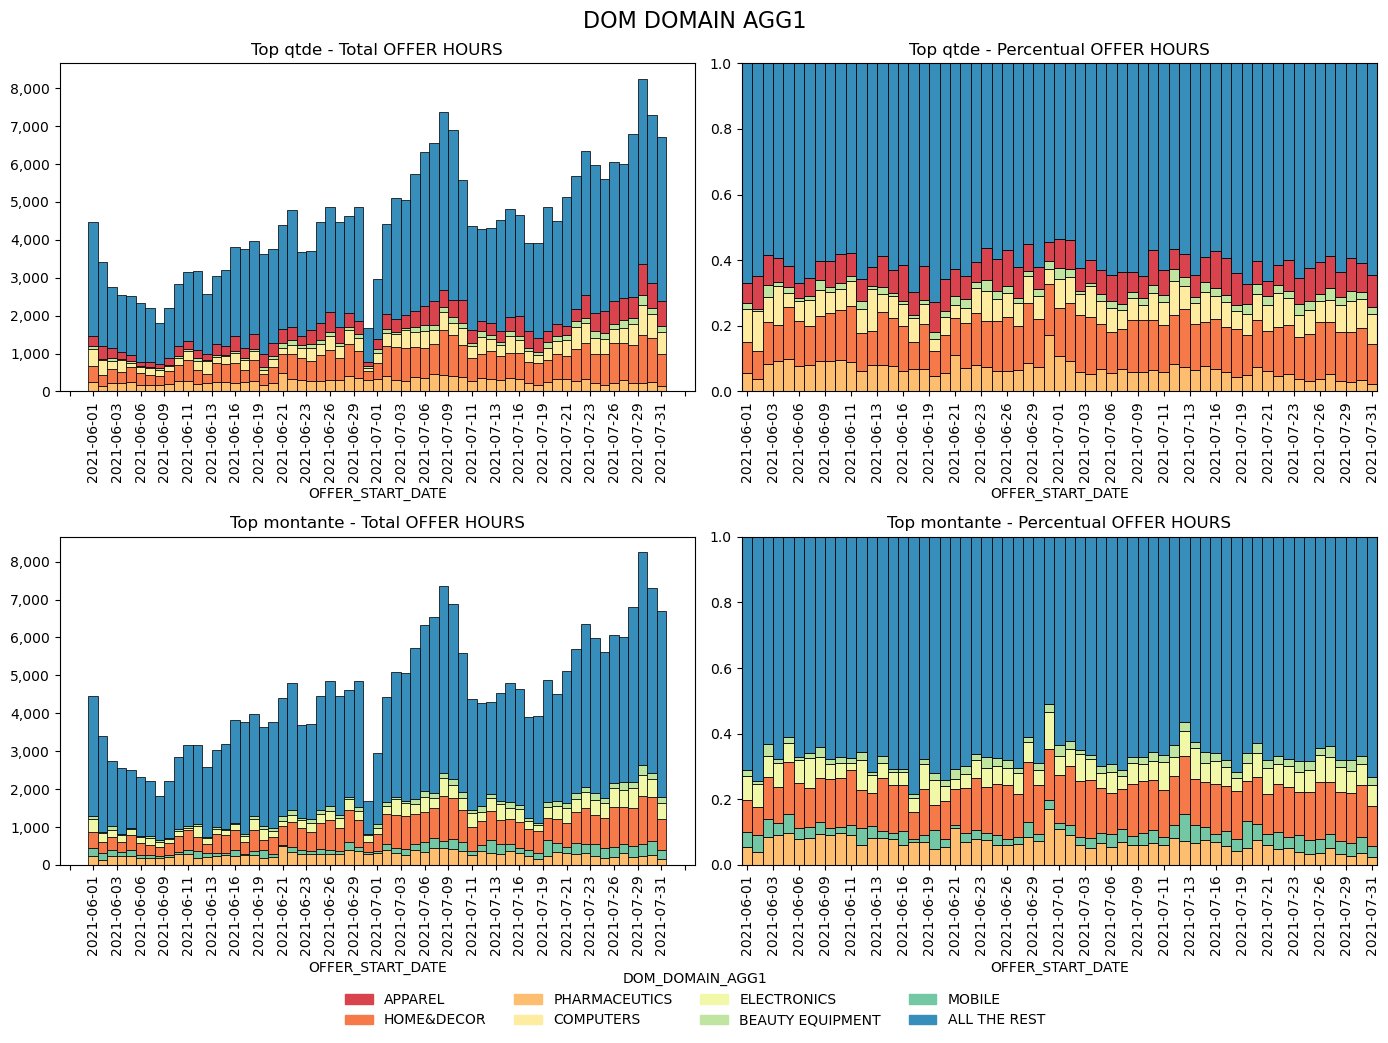

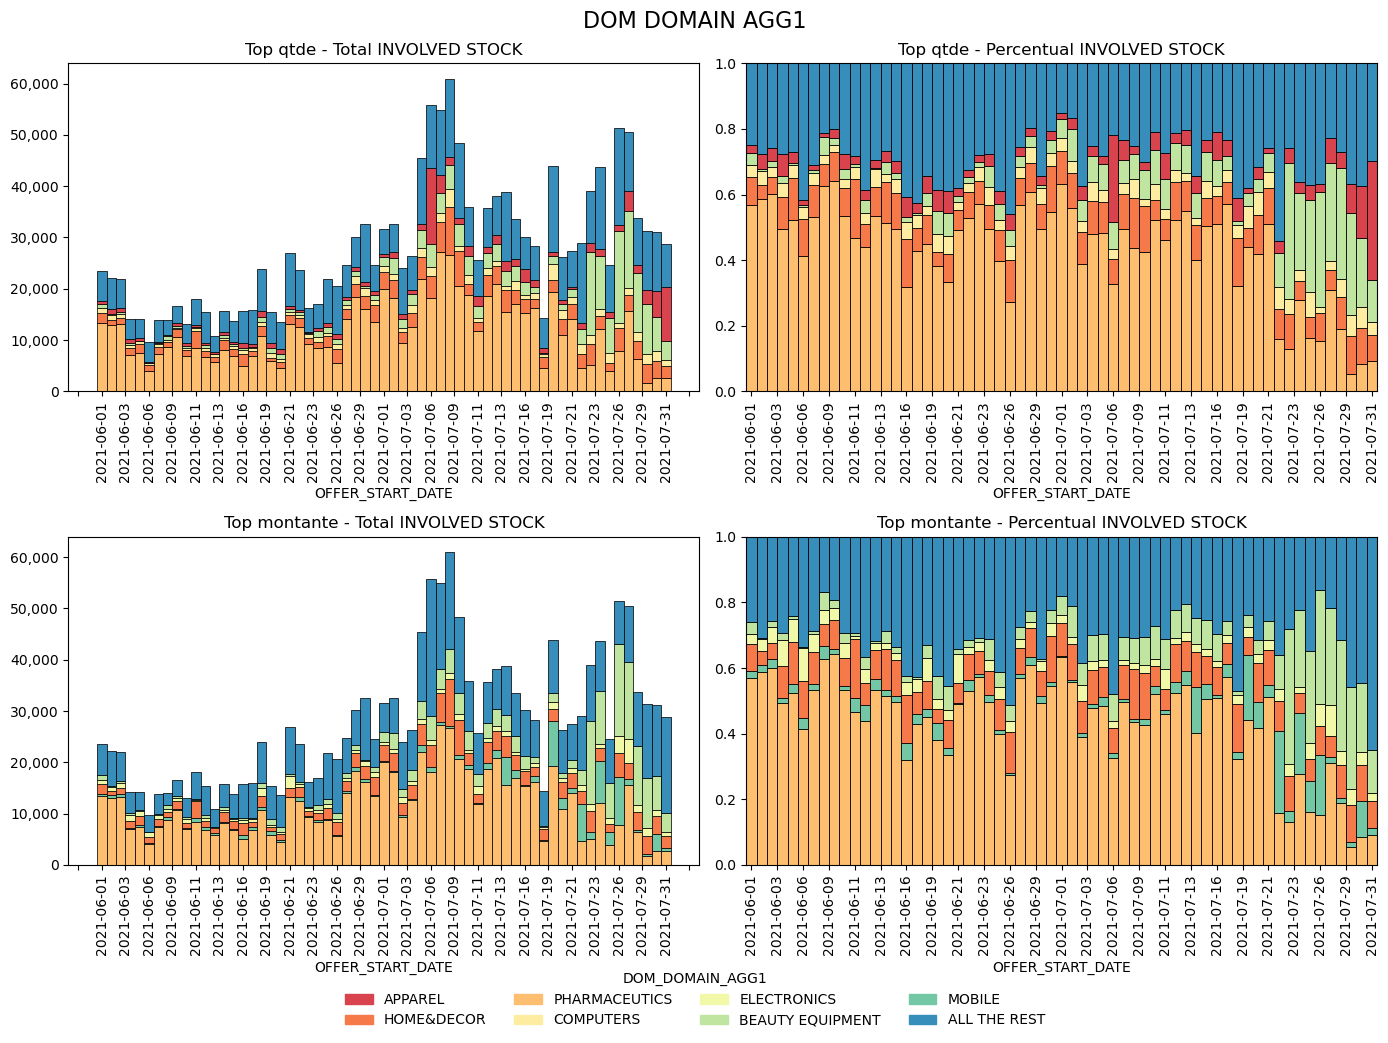

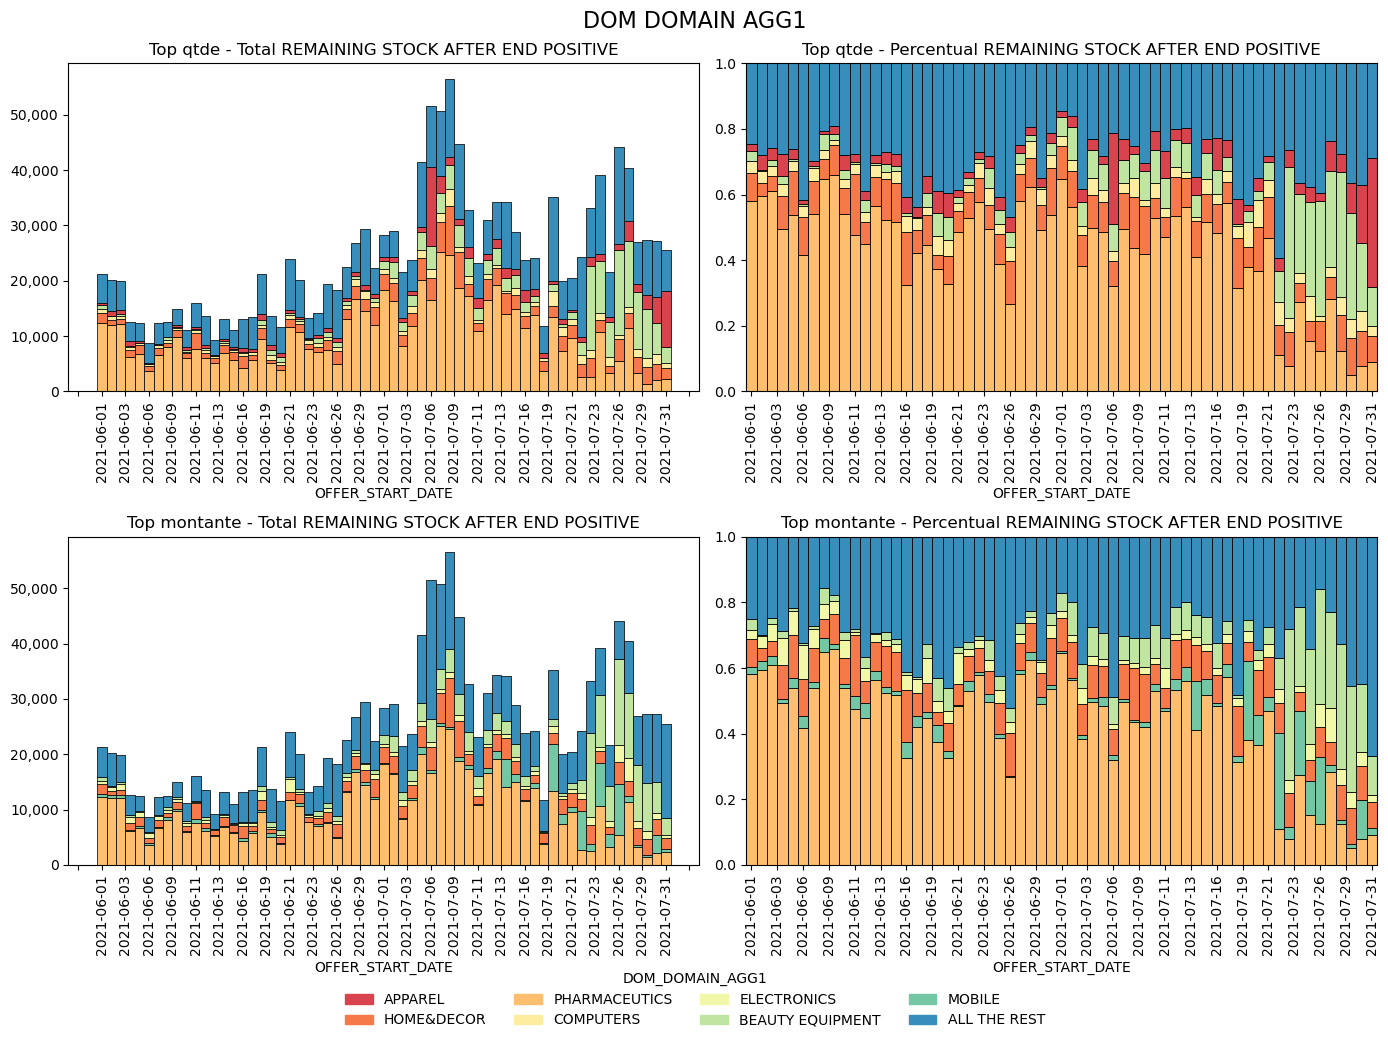

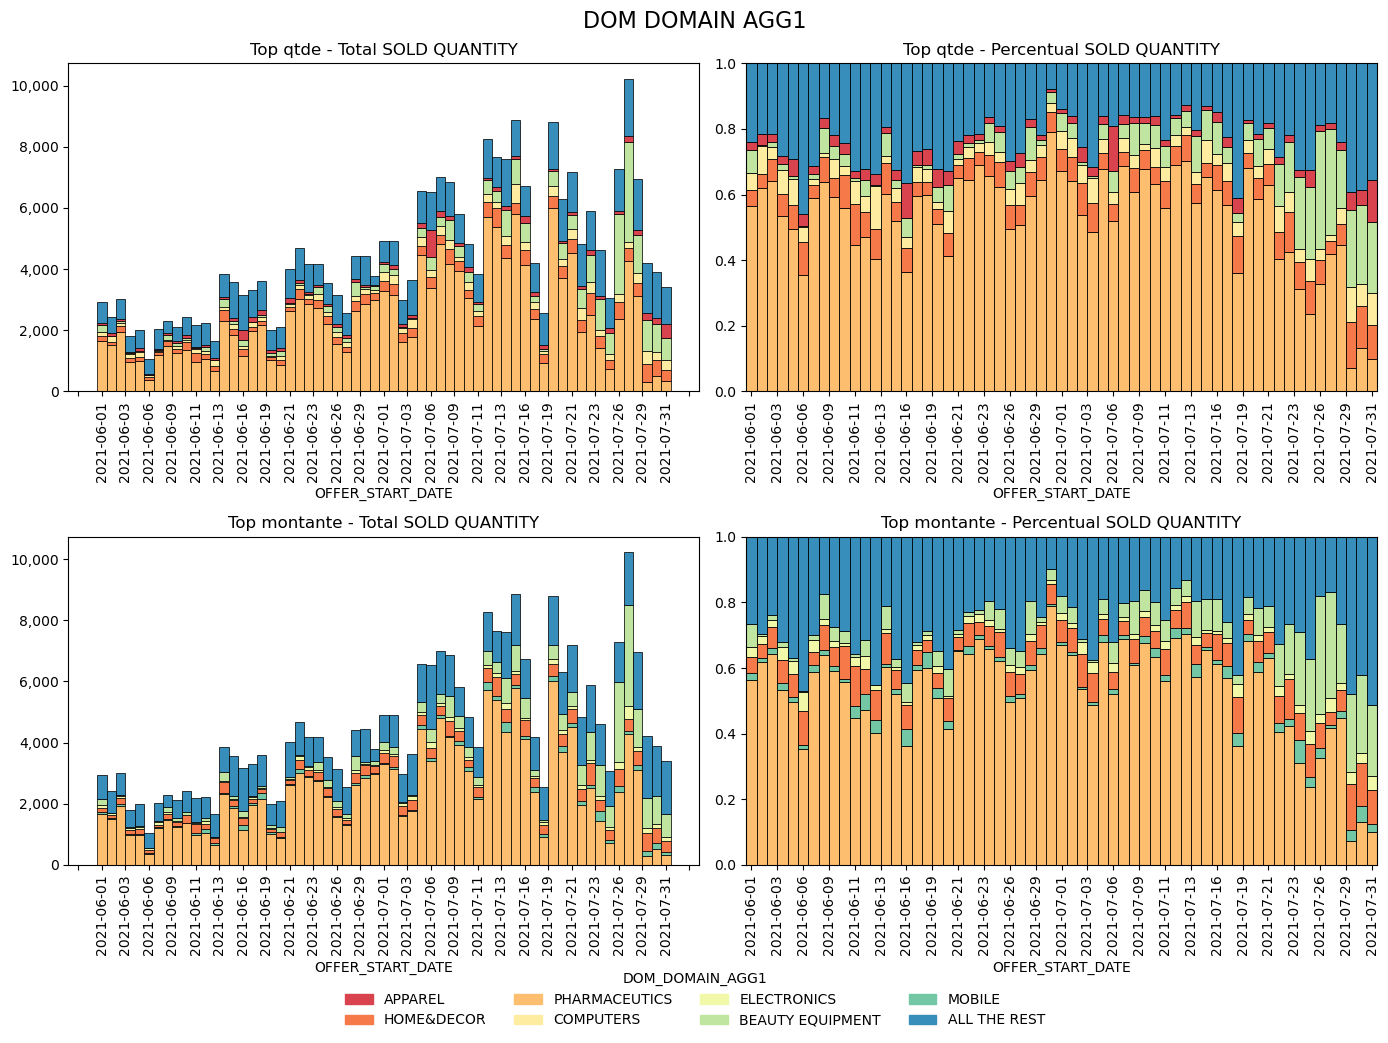

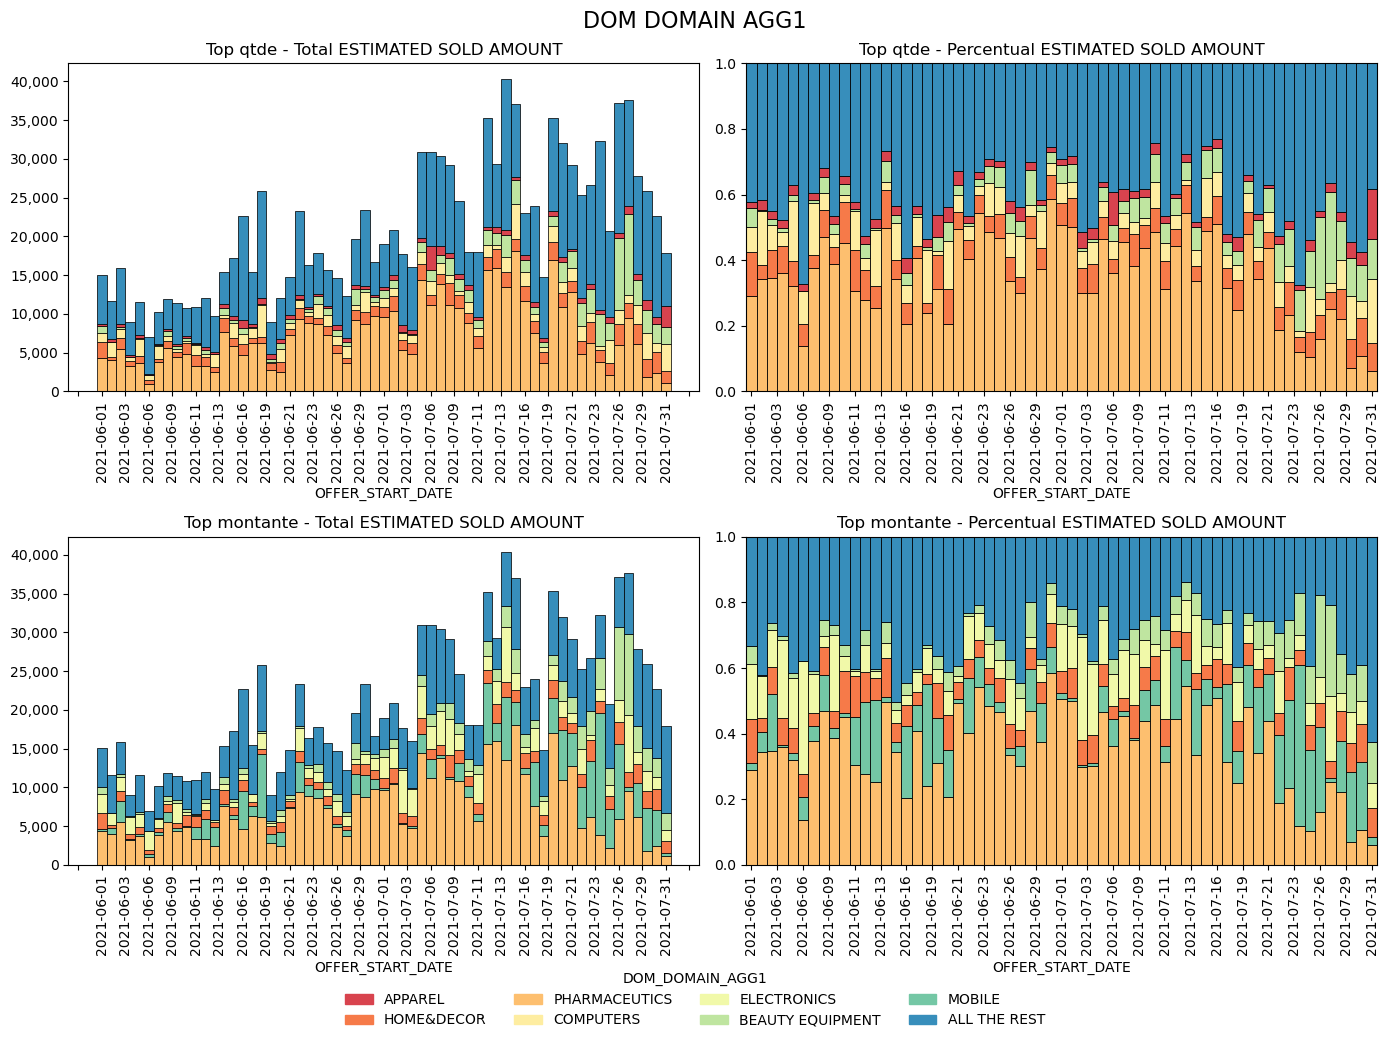

Valores consolidados - TOP qtde


DOM_DOMAIN_AGG1                           PHARMACEUTICS  ALL THE REST  \
TOTAL_OFFER_QTY                                3,014.00     29,600.00   
PCT_OFFER_QTY                                      6.30         61.90   
TOTAL_OFFER_HOURS                             17,092.05    168,209.76   
PCT_OFFER_HOURS                                    6.27         61.69   
TOTAL_INVOLVED_STOCK                         700,822.00    489,847.00   
PCT_INVOLVED_STOCK                                41.69         29.14   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE     606,435.00    432,138.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE            41.28         29.42   
TOTAL_SOLD_QUANTITY                          147,698.00     58,715.00   
PCT_SOLD_QUANTITY                                 54.90         21.82   
TOTAL_ESTIMATED_SOLD_AMOUNT                  440,150.43    529,061.26   
PCT_ESTIMATED_SOLD_AMOUNT                         34.68         41.69   

DOM_DOMAIN_AGG1                           BEAUTY EQUIPMENT  HOME&DECOR  \
TOTAL_OFFER_QTY                                   1,094.00    6,637.00   
PCT_OFFER_QTY                                         2.29       13.88   
TOTAL_OFFER_HOURS                                 6,087.88   38,774.42   
PCT_OFFER_HOURS                                       2.23       14.22   
TOTAL_INVOLVED_STOCK                            172,609.00  157,275.00   
PCT_INVOLVED_STOCK                                   10.27        9.36   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE        149,544.00  139,740.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE               10.18        9.51   
TOTAL_SOLD_QUANTITY                              24,323.00   18,347.00   
PCT_SOLD_QUANTITY                                     9.04        6.82   
TOTAL_ESTIMATED_SOLD_AMOUNT                      88,928.26   88,052.78   
PCT_ESTIMATED_SOLD_AMOUNT                             7.01        6.94   

DOM_DOMAIN_AGG1                           COMPUTERS   APPAREL  
TOTAL_OFFER_QTY                            3,661.00  3,814.00  
PCT_OFFER_QTY                                  7.66      7.98  
TOTAL_OFFER_HOURS                         20,184.84 22,334.83  
PCT_OFFER_HOURS                                7.40      8.19  
TOTAL_INVOLVED_STOCK                      68,461.00 92,007.00  
PCT_INVOLVED_STOCK                             4.07      5.47  
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE  56,322.00 84,880.00  
PCT_REMAINING_STOCK_AFTER_END_POSITIVE         3.83      5.78  
TOTAL_SOLD_QUANTITY                       12,113.00  7,841.00  
PCT_SOLD_QUANTITY                              4.50      2.91  
TOTAL_ESTIMATED_SOLD_AMOUNT               86,266.69 36,539.19  
PCT_ESTIMATED_SOLD_AMOUNT                      6.80      2.88

Valores consolidados - TOP montante


DOM_DOMAIN_AGG1                           PHARMACEUTICS  ALL THE REST  \
TOTAL_OFFER_QTY                                3,014.00     32,363.00   
PCT_OFFER_QTY                                      6.30         67.68   
TOTAL_OFFER_HOURS                             17,092.05    183,748.18   
PCT_OFFER_HOURS                                    6.27         67.39   
TOTAL_INVOLVED_STOCK                         700,822.00    514,962.00   
PCT_INVOLVED_STOCK                                41.69         30.63   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE     606,435.00    450,402.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE            41.28         30.66   
TOTAL_SOLD_QUANTITY                          147,698.00     67,251.00   
PCT_SOLD_QUANTITY                                 54.90         25.00   
TOTAL_ESTIMATED_SOLD_AMOUNT                  440,150.43    368,344.02   
PCT_ESTIMATED_SOLD_AMOUNT                         34.68         29.03   

DOM_DOMAIN_AGG1                           BEAUTY EQUIPMENT  HOME&DECOR  \
TOTAL_OFFER_QTY                                   1,094.00    6,637.00   
PCT_OFFER_QTY                                         2.29       13.88   
TOTAL_OFFER_HOURS                                 6,087.88   38,774.42   
PCT_OFFER_HOURS                                       2.23       14.22   
TOTAL_INVOLVED_STOCK                            172,609.00  157,275.00   
PCT_INVOLVED_STOCK                                   10.27        9.36   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE        149,544.00  139,740.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE               10.18        9.51   
TOTAL_SOLD_QUANTITY                              24,323.00   18,347.00   
PCT_SOLD_QUANTITY                                     9.04        6.82   
TOTAL_ESTIMATED_SOLD_AMOUNT                      88,928.26   88,052.78   
PCT_ESTIMATED_SOLD_AMOUNT                             7.01        6.94   

DOM_DOMAIN_AGG1                              MOBILE  ELECTRONICS  
TOTAL_OFFER_QTY                            1,790.00     2,922.00  
PCT_OFFER_QTY                                  3.74         6.11  
TOTAL_OFFER_HOURS                         10,111.98    16,869.27  
PCT_OFFER_HOURS                                3.71         6.19  
TOTAL_INVOLVED_STOCK                      76,741.00    58,612.00  
PCT_INVOLVED_STOCK                             4.57         3.49  
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE  70,475.00    52,463.00  
PCT_REMAINING_STOCK_AFTER_END_POSITIVE         4.80         3.57  
TOTAL_SOLD_QUANTITY                        5,732.00     5,686.00  
PCT_SOLD_QUANTITY                              2.13         2.11  
TOTAL_ESTIMATED_SOLD_AMOUNT              159,760.40   123,762.72  
PCT_ESTIMATED_SOLD_AMOUNT                     12.59         9.75

______________________________________________________________________________________________________________________________


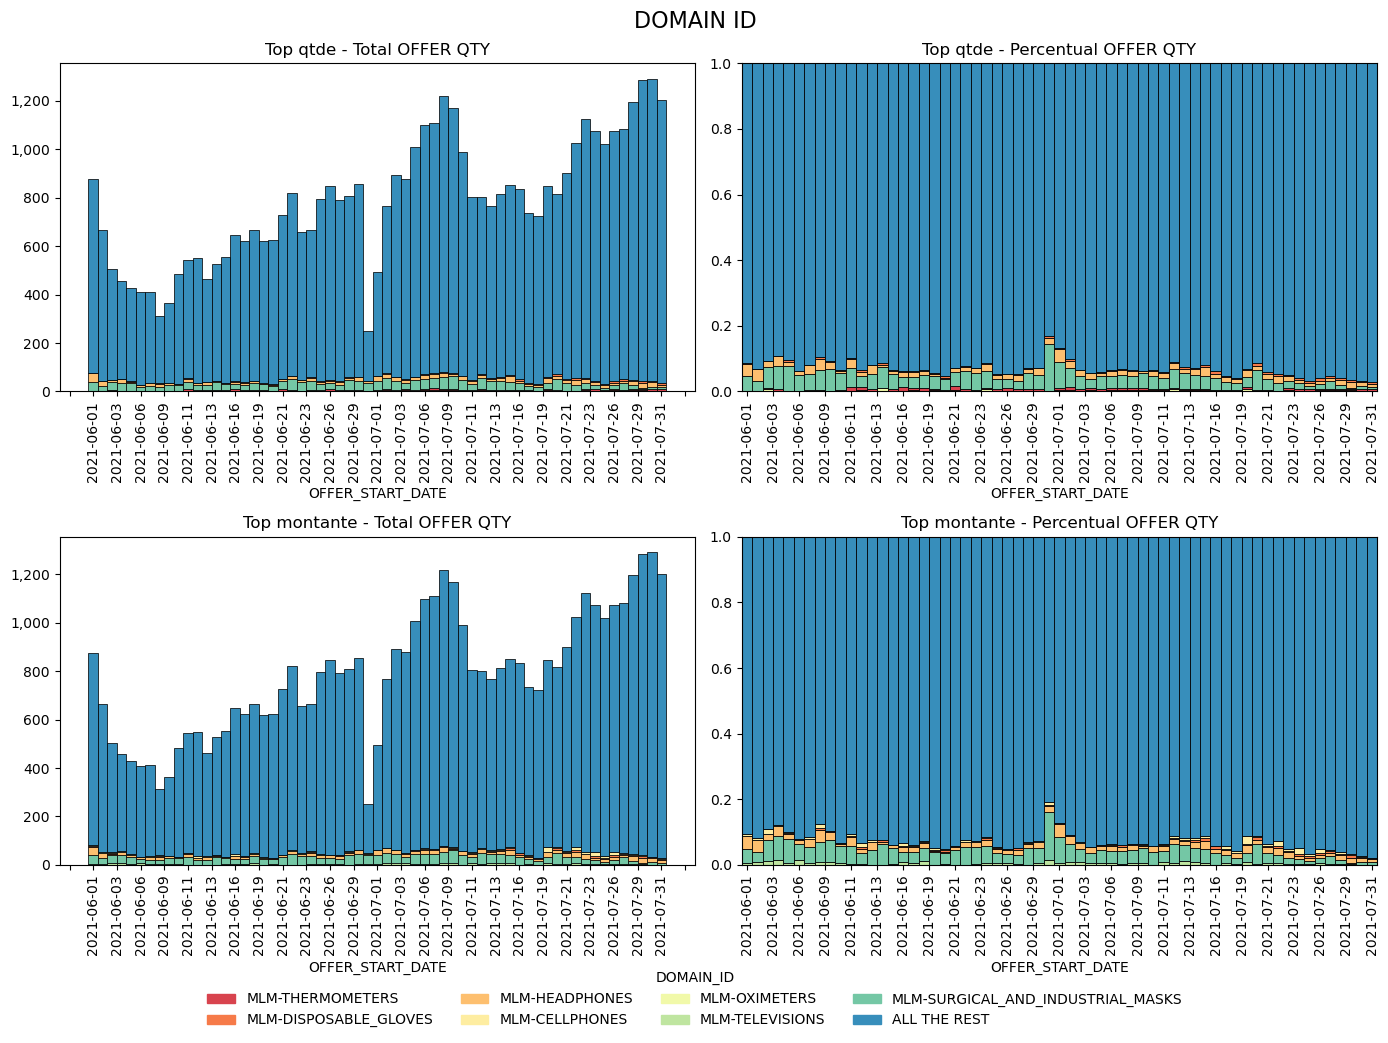

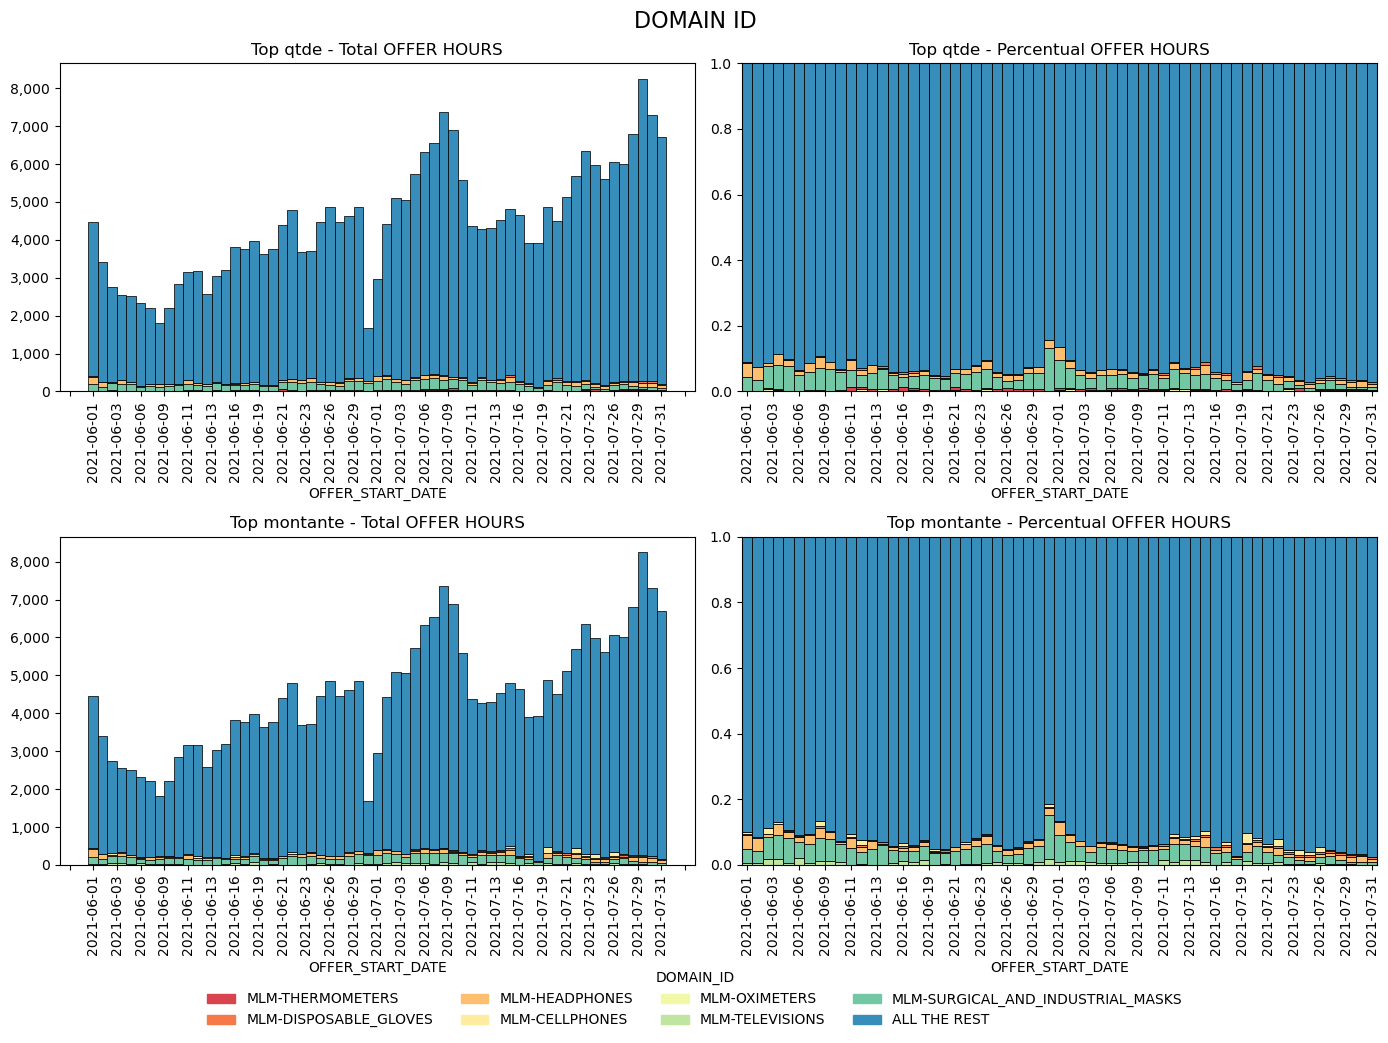

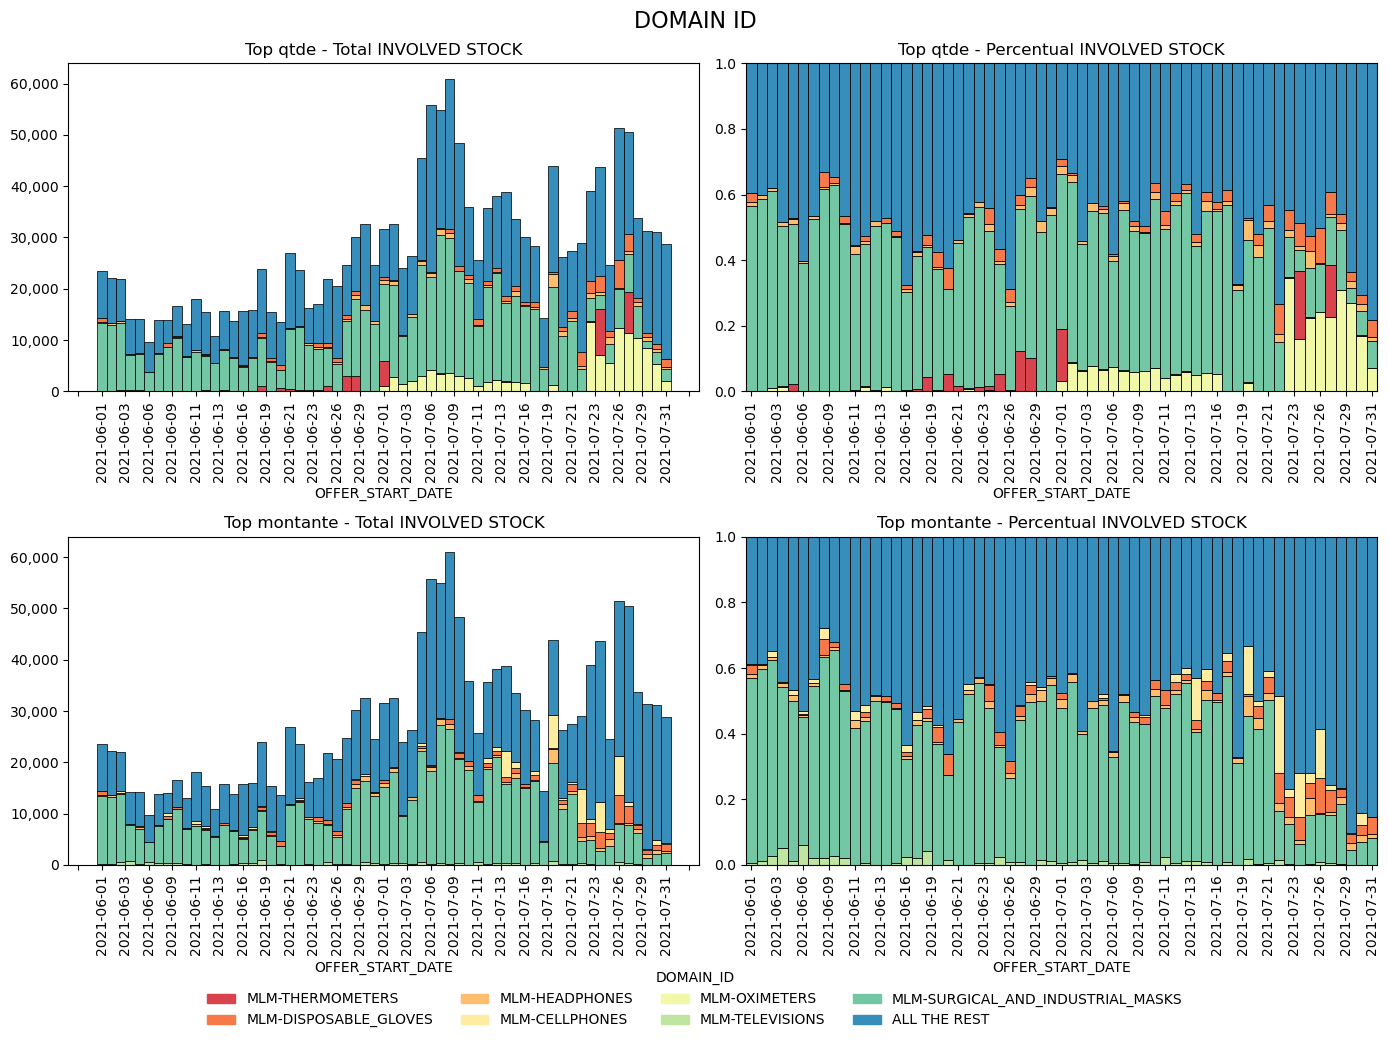

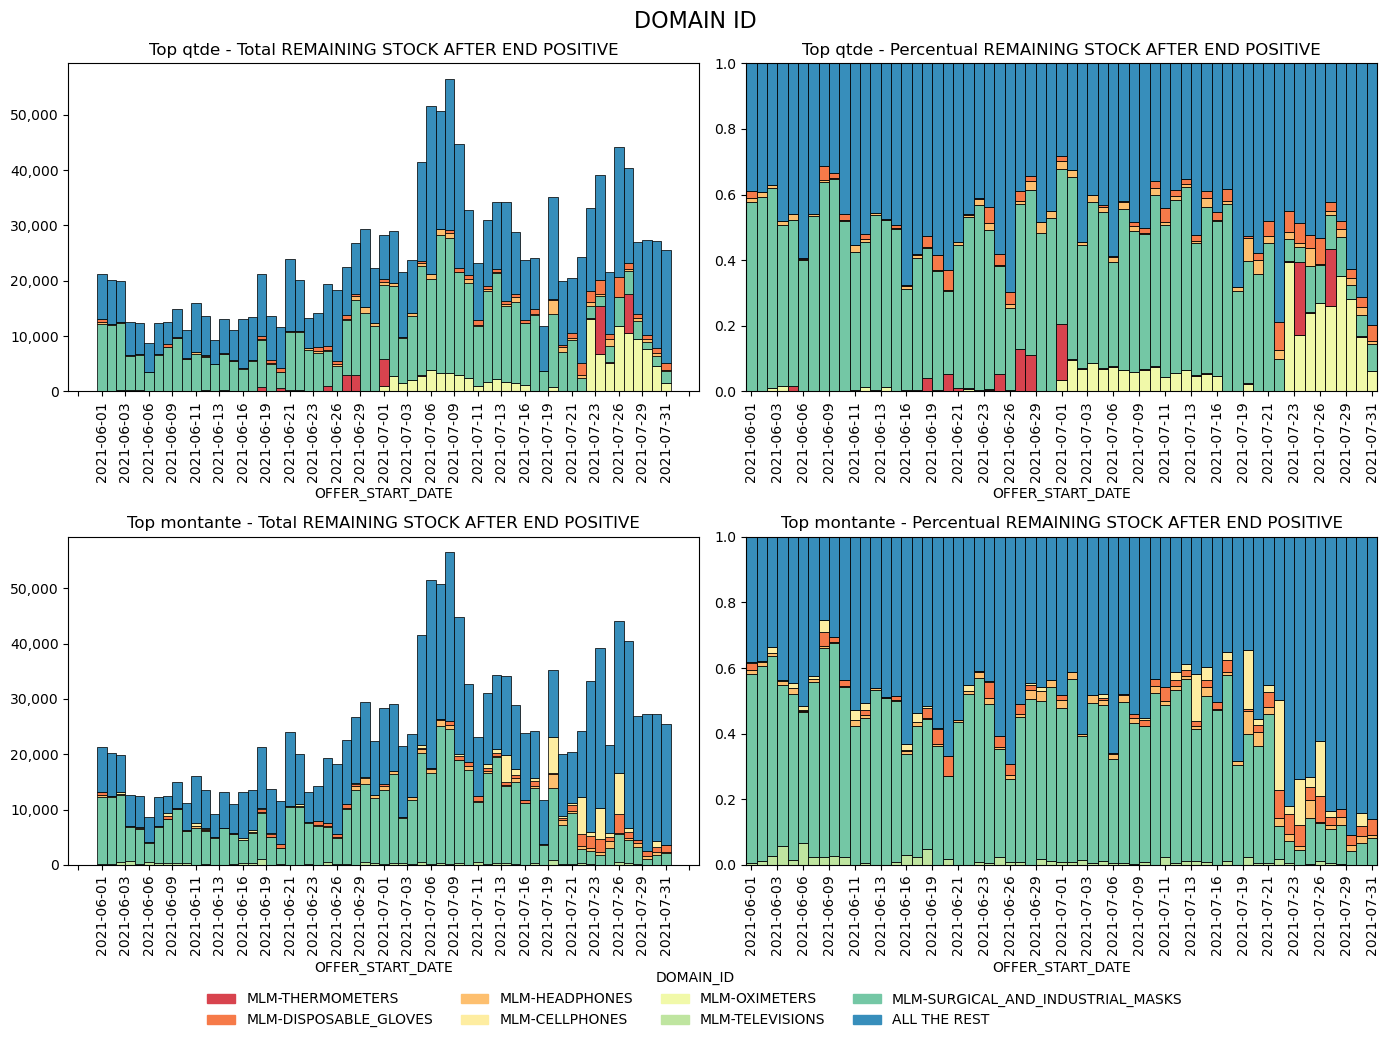

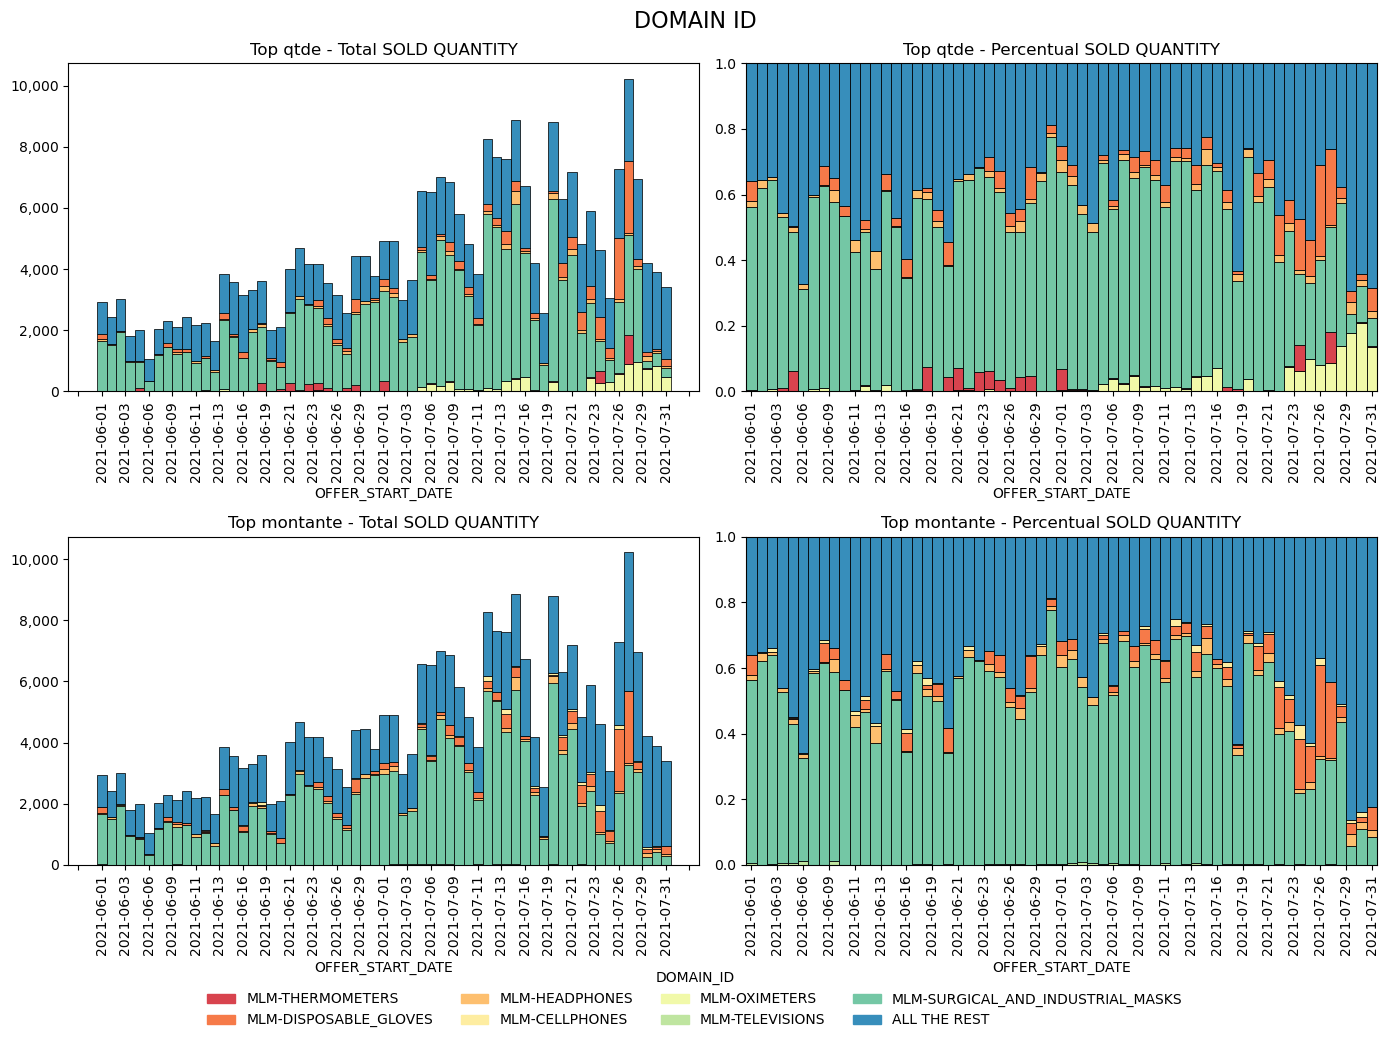

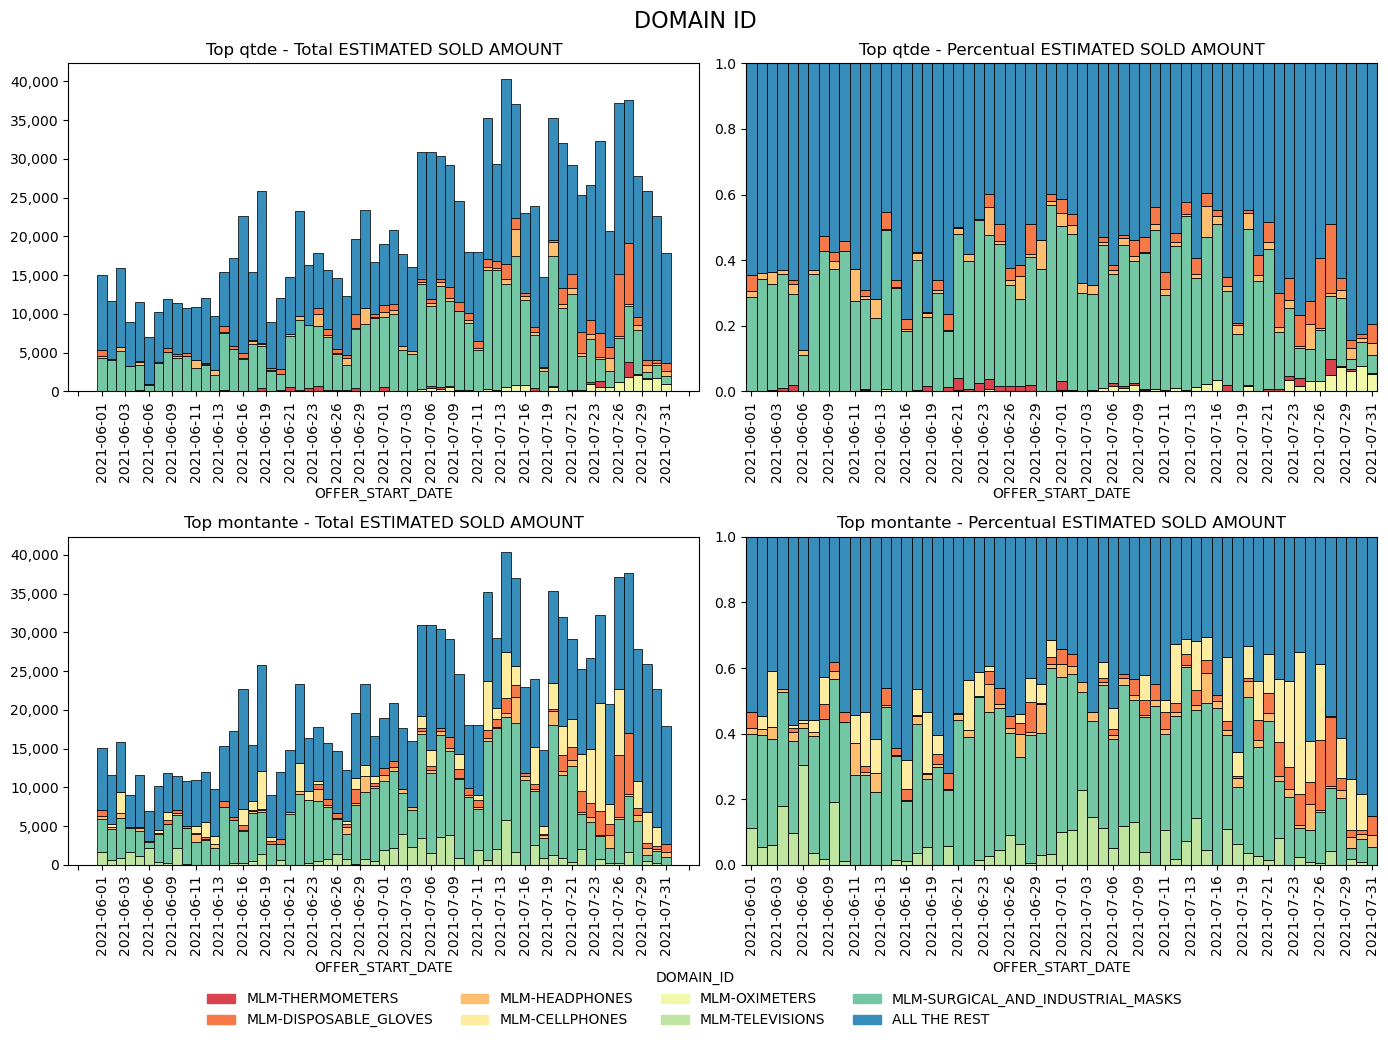

Valores consolidados - TOP qtde


DOMAIN_ID                                 MLM-SURGICAL_AND_INDUSTRIAL_MASKS  \
TOTAL_OFFER_QTY                                                    1,757.00   
PCT_OFFER_QTY                                                          3.67   
TOTAL_OFFER_HOURS                                                 10,107.28   
PCT_OFFER_HOURS                                                        3.71   
TOTAL_INVOLVED_STOCK                                             651,780.00   
PCT_INVOLVED_STOCK                                                    38.77   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE                         563,347.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE                                38.35   
TOTAL_SOLD_QUANTITY                                              141,377.00   
PCT_SOLD_QUANTITY                                                     52.55   
TOTAL_ESTIMATED_SOLD_AMOUNT                                      410,386.91   
PCT_ESTIMATED_SOLD_AMOUNT                                             32.34   

DOMAIN_ID                                 ALL THE REST  MLM-DISPOSABLE_GLOVES  \
TOTAL_OFFER_QTY                              44,772.00                 182.00   
PCT_OFFER_QTY                                    93.63                   0.38   
TOTAL_OFFER_HOURS                           255,400.66               1,020.50   
PCT_OFFER_HOURS                                  93.66                   0.37   
TOTAL_INVOLVED_STOCK                        806,269.00              44,825.00   
PCT_INVOLVED_STOCK                               47.96                   2.67   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE    711,182.00              32,003.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE           48.41                   2.18   
TOTAL_SOLD_QUANTITY                          97,063.00              13,477.00   
PCT_SOLD_QUANTITY                                36.08                   5.01   
TOTAL_ESTIMATED_SOLD_AMOUNT                 745,676.78              55,365.39   
PCT_ESTIMATED_SOLD_AMOUNT                        58.76                   4.36   

DOMAIN_ID                                 MLM-OXIMETERS  MLM-HEADPHONES  \
TOTAL_OFFER_QTY                                  139.00          750.00   
PCT_OFFER_QTY                                      0.29            1.57   
TOTAL_OFFER_HOURS                                862.30        4,179.81   
PCT_OFFER_HOURS                                    0.32            1.53   
TOTAL_INVOLVED_STOCK                         116,024.00       28,067.00   
PCT_INVOLVED_STOCK                                 6.90            1.67   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE     107,942.00       23,536.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE             7.35            1.60   
TOTAL_SOLD_QUANTITY                            8,632.00        4,711.00   
PCT_SOLD_QUANTITY                                  3.21            1.75   
TOTAL_ESTIMATED_SOLD_AMOUNT                   17,606.61       30,458.79   
PCT_ESTIMATED_SOLD_AMOUNT                          1.39            2.40   

DOMAIN_ID                                 MLM-THERMOMETERS  
TOTAL_OFFER_QTY                                     220.00  
PCT_OFFER_QTY                                         0.46  
TOTAL_OFFER_HOURS                                 1,113.21  
PCT_OFFER_HOURS                                       0.41  
TOTAL_INVOLVED_STOCK                             34,056.00  
PCT_INVOLVED_STOCK                                    2.03  
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE         31,049.00  
PCT_REMAINING_STOCK_AFTER_END_POSITIVE                2.11  
TOTAL_SOLD_QUANTITY                               3,777.00  
PCT_SOLD_QUANTITY                                     1.40  
TOTAL_ESTIMATED_SOLD_AMOUNT                       9,504.12  
PCT_ESTIMATED_SOLD_AMOUNT                             0.75

Valores consolidados - TOP montante


DOMAIN_ID                                 MLM-SURGICAL_AND_INDUSTRIAL_MASKS  \
TOTAL_OFFER_QTY                                                    1,757.00   
PCT_OFFER_QTY                                                          3.67   
TOTAL_OFFER_HOURS                                                 10,107.28   
PCT_OFFER_HOURS                                                        3.71   
TOTAL_INVOLVED_STOCK                                             651,780.00   
PCT_INVOLVED_STOCK                                                    38.77   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE                         563,347.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE                                38.35   
TOTAL_SOLD_QUANTITY                                              141,377.00   
PCT_SOLD_QUANTITY                                                     52.55   
TOTAL_ESTIMATED_SOLD_AMOUNT                                      410,386.91   
PCT_ESTIMATED_SOLD_AMOUNT                                             32.34   

DOMAIN_ID                                 ALL THE REST  MLM-DISPOSABLE_GLOVES  \
TOTAL_OFFER_QTY                              44,695.00                 182.00   
PCT_OFFER_QTY                                    93.47                   0.38   
TOTAL_OFFER_HOURS                           254,223.80               1,020.50   
PCT_OFFER_HOURS                                  93.23                   0.37   
TOTAL_INVOLVED_STOCK                        896,084.00              44,825.00   
PCT_INVOLVED_STOCK                               53.31                   2.67   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE    792,846.00              32,003.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE           53.97                   2.18   
TOTAL_SOLD_QUANTITY                         107,068.00              13,477.00   
PCT_SOLD_QUANTITY                                39.80                   5.01   
TOTAL_ESTIMATED_SOLD_AMOUNT                 594,295.93              55,365.39   
PCT_ESTIMATED_SOLD_AMOUNT                        46.83                   4.36   

DOMAIN_ID                                 MLM-HEADPHONES  MLM-CELLPHONES  \
TOTAL_OFFER_QTY                                   750.00          210.00   
PCT_OFFER_QTY                                       1.57            0.44   
TOTAL_OFFER_HOURS                               4,179.81        1,407.97   
PCT_OFFER_HOURS                                     1.53            0.52   
TOTAL_INVOLVED_STOCK                           28,067.00       44,809.00   
PCT_INVOLVED_STOCK                                  1.67            2.67   
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE       23,536.00       42,553.00   
PCT_REMAINING_STOCK_AFTER_END_POSITIVE              1.60            2.90   
TOTAL_SOLD_QUANTITY                             4,711.00        1,833.00   
PCT_SOLD_QUANTITY                                   1.75            0.68   
TOTAL_ESTIMATED_SOLD_AMOUNT                    30,458.79      111,622.69   
PCT_ESTIMATED_SOLD_AMOUNT                           2.40            8.80   

DOMAIN_ID                                 MLM-TELEVISIONS  
TOTAL_OFFER_QTY                                    226.00  
PCT_OFFER_QTY                                        0.47  
TOTAL_OFFER_HOURS                                1,744.40  
PCT_OFFER_HOURS                                      0.64  
TOTAL_INVOLVED_STOCK                            15,456.00  
PCT_INVOLVED_STOCK                                   0.92  
TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE        14,774.00  
PCT_REMAINING_STOCK_AFTER_END_POSITIVE               1.01  
TOTAL_SOLD_QUANTITY                                571.00  
PCT_SOLD_QUANTITY                                    0.21  
TOTAL_ESTIMATED_SOLD_AMOUNT                     66,868.90  
PCT_ESTIMATED_SOLD_AMOUNT                            5.27

______________________________________________________________________________________________________________________________


In [44]:
n_col = 2
n_row = 2

for cat in cat_list:

    df_resumo = df.groupby([cat]).agg(
        TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
        TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum())
    )
    # top 5  
    top_qty_list = list(df_resumo.nlargest(5, 'TOTAL_SOLD_QUANTITY').index)
    top_amt_list = list(df_resumo.nlargest(5, 'TOTAL_ESTIMATED_SOLD_AMOUNT').index)

    df_top_qty = df.copy()
    df_top_qty[cat] = np.where(df_top_qty[cat].isin(top_qty_list) == True, df_top_qty[cat], "ALL THE REST")

    df_top_amt = df.copy()
    df_top_amt[cat] = np.where(df_top_amt[cat].isin(top_amt_list) == True, df_top_amt[cat], "ALL THE REST")

    # gerar cores padronizadas
    top_cat = list(set(top_qty_list+top_amt_list))+["ALL THE REST"]
    ##gerar cores
    cmap = mpl.colormaps['Spectral']
    colors = cmap(np.linspace(0, 1, len(top_cat)+2))[1:-1] # não pegar extremos
    color_cat = dict(zip(top_cat, colors))
    patch = []
    for i in color_cat:
        patch.append(mpatches.Patch(color=color_cat[i], label=i))

    #gerar df plot
    ### qty
    df_plot_qty = df_top_qty.groupby(["OFFER_START_DATE", cat]).agg(
            TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()),       

            TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
            TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
            TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
            TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
            TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum())
        )
    df_plot_qty = df_plot_qty.reset_index()
    df_plot_qty["OFFER_START_DATE"] = df_plot_qty["OFFER_START_DATE"].astype(str)
    ### amt
    df_plot_amt = df_top_amt.groupby(["OFFER_START_DATE", cat]).agg(
            TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()),       

            TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
            TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
            TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
            TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
            TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum())
        )
    df_plot_amt = df_plot_amt.reset_index()
    df_plot_amt["OFFER_START_DATE"] = df_plot_amt["OFFER_START_DATE"].astype(str)

    for num in num_list:

        #gerar plot
        fig, axes = plt.subplots(n_row, n_col, figsize = (n_col*7, n_row*5))
        fig.suptitle(cat.replace("_"," "),size = 16)

        #total
        sns.histplot(data = df_plot_qty, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[0][0], 
                     hue = cat, multiple = "stack", stat="count", palette = color_cat, alpha = 1, legend = False)
        axes[0][0].tick_params(axis = 'x', labelrotation = 90)
        axes[0][0].title.set_text('Top qtde - Total ' + num.replace("_"," "))
        axes[0][0].xaxis.set_major_locator(plt.MaxNLocator(30))
        ylabels = ['{:,.0f}'.format(y) for y in axes[0][0].get_yticks()]
        axes[0][0].set_yticklabels(ylabels)
        axes[0][0].set(ylabel=None)

        #percentual
        sns.histplot(data = df_plot_qty, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[0][1], 
                     hue = cat, multiple = "fill", stat="percent", palette = color_cat, alpha = 1, legend = False)
        axes[0][1].tick_params(axis = 'x', labelrotation = 90)
        axes[0][1].title.set_text('Top qtde - Percentual ' + num.replace("_"," "))
        axes[0][1].xaxis.set_major_locator(plt.MaxNLocator(30))
        axes[0][1].set(ylabel=None)

        #total
        sns.histplot(data = df_plot_amt, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[1][0], 
                     hue = cat, multiple = "stack", stat="count", palette = color_cat, alpha = 1, legend = False)
        axes[1][0].tick_params(axis = 'x', labelrotation = 90)
        axes[1][0].title.set_text('Top montante - Total ' + num.replace("_"," "))
        axes[1][0].xaxis.set_major_locator(plt.MaxNLocator(30))
        ylabels = ['{:,.0f}'.format(y) for y in axes[1][0].get_yticks()]
        axes[1][0].set_yticklabels(ylabels)
        axes[1][0].set(ylabel=None)

        #percentual
        sns.histplot(data = df_plot_amt, x = "OFFER_START_DATE", weights = "TOTAL_" + num, ax = axes[1][1], 
                     hue = cat, multiple = "fill", stat="percent", palette = color_cat, alpha = 1, legend = False)
        axes[1][1].tick_params(axis = 'x', labelrotation = 90)
        axes[1][1].title.set_text('Top montante - Percentual ' + num.replace("_"," "))
        axes[1][1].xaxis.set_major_locator(plt.MaxNLocator(30))
        axes[1][1].set(ylabel=None)    

        fig.tight_layout()
        fig.legend(handles=patch,ncol=4, loc = 'lower center', bbox_to_anchor=(0.5, -0.05),frameon = False,title = cat )
        plt.close(fig)

        display(fig)
    #resumo
    df_resumo_qty = df_top_qty.groupby([cat]).agg(
        TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()), 
        PCT_OFFER_QTY = ("OFFER_START_DATE", lambda x: (x.count()/df_top_qty["OFFER_HOURS"].count()*100)), 
        TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
        PCT_OFFER_HOURS = ("OFFER_HOURS", lambda x:(x.sum()/df_top_qty["OFFER_HOURS"].sum()*100)),
        TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
        PCT_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: (x.sum()/df_top_qty["INVOLVED_STOCK"].sum()*100)),
        TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
        PCT_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: (x.sum()/df_top_qty["REMAINING_STOCK_AFTER_END_POSITIVE"].sum()*100)),
        TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
        PCT_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: (x.sum()/df_top_qty["SOLD_QUANTITY"].sum()*100)),
        TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum()),
        PCT_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: (x.sum()/df_top_qty["ESTIMATED_SOLD_AMOUNT"].sum()*100))

    ).sort_values(by="TOTAL_SOLD_QUANTITY", ascending = False).T
    

    df_resumo_amt = df_top_amt.groupby([cat]).agg(
        TOTAL_OFFER_QTY = ("OFFER_START_DATE", lambda x: x.count()), 
        PCT_OFFER_QTY = ("OFFER_START_DATE", lambda x: (x.count()/df_top_amt["OFFER_HOURS"].count()*100)), 
        TOTAL_OFFER_HOURS = ("OFFER_HOURS", lambda x: x.sum()),
        PCT_OFFER_HOURS = ("OFFER_HOURS", lambda x: (x.sum()/df_top_amt["OFFER_HOURS"].sum()*100)),
        TOTAL_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: x.sum()),
        PCT_INVOLVED_STOCK = ("INVOLVED_STOCK", lambda x: (x.sum()/df_top_amt["INVOLVED_STOCK"].sum()*100)),
        TOTAL_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: x.sum()),
        PCT_REMAINING_STOCK_AFTER_END_POSITIVE = ("REMAINING_STOCK_AFTER_END_POSITIVE", lambda x: (x.sum()/df_top_amt["REMAINING_STOCK_AFTER_END_POSITIVE"].sum()*100)),
        TOTAL_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: x.sum()),
        PCT_SOLD_QUANTITY = ("SOLD_QUANTITY", lambda x: (x.sum()/df_top_amt["SOLD_QUANTITY"].sum()*100)),
        TOTAL_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: x.sum()),
        PCT_ESTIMATED_SOLD_AMOUNT = ("ESTIMATED_SOLD_AMOUNT", lambda x: (x.sum()/df_top_amt["ESTIMATED_SOLD_AMOUNT"].sum()*100))

    ).sort_values(by="TOTAL_SOLD_QUANTITY", ascending = False).T
    print("Valores consolidados - TOP qtde")
    display(df_resumo_qty)
    print("Valores consolidados - TOP montante")
    display(df_resumo_amt)
    print("______________________________________________________________________________________________________________________________")

